<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Group Project 3

### Regression and Classification with the Housing Data - Kaggle Competition
### Team: NTM for GA DSI 2 Course
---
### Kaggle Competition Links
https://www.kaggle.com/c/dsi-regression
https://www.kaggle.com/c/dsi-classification

---

In [114]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the data
train_data=pd.read_csv('./train.csv')
test_data=pd.read_csv('./test.csv')

In [3]:
train_df=pd.DataFrame(train_data,columns=train_data.columns)
test_df=pd.DataFrame(test_data,columns=test_data.columns)

In [4]:
train_df.columns = train_df.columns.str.replace(' ', '')
test_df.columns = test_df.columns.str.replace(' ', '')

In [117]:
train_df.shape , test_df.shape

((2051, 82), (879, 80))

In [118]:
set(train_df.SaleCondition)

{0, 1}

# 1. EDA

## <font color='green'>Train Set</font>


In [119]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 82 columns):
Id               2051 non-null int64
PID              2051 non-null int64
MSSubClass       2051 non-null int64
MSZoning         2051 non-null object
LotFrontage      2051 non-null float64
LotArea          2051 non-null int64
Street           2051 non-null object
Alley            2051 non-null object
LotShape         2051 non-null object
LandContour      2051 non-null object
Utilities        2051 non-null object
LotConfig        2051 non-null object
LandSlope        2051 non-null object
Neighborhood     2051 non-null object
Condition1       2051 non-null object
Condition2       2051 non-null object
BldgType         2051 non-null object
HouseStyle       2051 non-null object
OverallQual      2051 non-null int64
OverallCond      2051 non-null int64
YearBuilt        2051 non-null int64
YearRemod/Add    2051 non-null int64
RoofStyle        2051 non-null object
RoofMatl         2051 non-

In [120]:
for x in train_df.columns:
    if x not in test_df.columns:
        print(x)

SaleCondition
SalePrice


In [121]:
#categorical & numerical features train set
categorical_train = [var for var in train_df.columns if train_df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical_train)))
numerical_train = [var for var in train_df.columns if train_df[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical_train)))

There are 42 categorical variables
There are 40 numerical variables


In [122]:
discrete_train = []
for var in numerical_train:
    if len(train_df[var].unique())<20:
        print(var, ' values: ', train_df[var].unique())
        discrete_train.append(var)
        
print('There are {} discrete variables'.format(len(discrete_train)))

MSSubClass  values:  [ 60  20  50 180 160  70 120 190  85  30  90  80  75  45  40 150]
OverallQual  values:  [ 6  7  5  8 10  4  9  3  2  1]
OverallCond  values:  [8 5 7 6 3 9 2 4 1]
BsmtFullBath  values:  [0. 1. 2. 3.]
BsmtHalfBath  values:  [0. 1. 2.]
FullBath  values:  [2 1 3 0 4]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 2 5 1 0 6 8]
KitchenAbvGr  values:  [1 2 0 3]
TotRmsAbvGrd  values:  [ 6  8  5  7  9  4 12 11 10  3 14  2 13 15]
Fireplaces  values:  [0 1 2 4 3]
GarageCars  values:  [2. 1. 3. 0. 4. 5.]
PoolArea  values:  [  0 519 576 800 228 480 648 738 368 561]
MoSold  values:  [ 3  4  1  6  5  9  7  2 12 10 11  8]
YrSold  values:  [2010 2009 2006 2007 2008]
SaleCondition  values:  [0 1]
There are 16 discrete variables


In [123]:
#perecntage of nan values per feature
for var in train_df.columns:
    if train_df[var].isnull().sum()>0:
        print(var, train_df[var].isnull().mean())

In [124]:
# Most of the values in PoolQC and MiscFeature are nans. 

In [125]:
train_df.columns[train_df.isna().any()].tolist()  #list of features which have nan values

[]

### Handling Nan values


In [126]:
train_df.head()

Id        PID  MSSubClass MSZoning  LotFrontage  LotArea Street  \
0  109  533352170          60       RL          0.0    13517   Pave   
1  544  531379050          60       RL         43.0    11492   Pave   
2  153  535304180          20       RL         68.0     7922   Pave   
3  318  916386060          60       RL         73.0     9802   Pave   
4  255  906425045          50       RL         82.0    14235   Pave   

       Alley LotShape LandContour    ...     PoolArea   PoolQC     Fence  \
0  no-access      IR1         Lvl    ...            0  no-pool  no-Fence   
1  no-access      IR1         Lvl    ...            0  no-pool  no-Fence   
2  no-access      Reg         Lvl    ...            0  no-pool  no-Fence   
3  no-access      Reg         Lvl    ...            0  no-pool  no-Fence   
4  no-access      IR1         Lvl    ...            0  no-pool  no-Fence   

  MiscFeature MiscVal MoSold YrSold SaleType  SaleCondition  SalePrice  
0        None       0      3   2010      WD               0     130500  
1        None       0      4   2009      WD               0     220000  
2        None       0      1   2010      WD               1     109000  
3        None       0      4   2010      WD               0     174000  
4        None       0      3   2010      WD               0     138500  

[5 rows x 82 columns]

In [127]:
MM=train_df.columns[train_df.isna().any()].tolist()  #list of features which have nan values

for x in MM:
    print(x,"," , train_df[x].dtype)

In [128]:
train_df.GarageCars.dtype

dtype('float64')

In [129]:


train_df.Alley=train_df.Alley.fillna('no-access') 
train_df.BsmtQual=train_df.BsmtQual.fillna('no-Basement') 
train_df.BsmtCond=train_df.BsmtCond.fillna('no-Basement') 
train_df.BsmtExposure=train_df.BsmtExposure.fillna('no-Basement') 
train_df.BsmtFinType1=train_df.BsmtFinType1.fillna('no-Basement') 
train_df.FireplaceQu=train_df.FireplaceQu.fillna('no-Fireplace') 
train_df.GarageType=train_df.GarageType.fillna('no-Garage') 
train_df.GarageFinish=train_df.GarageFinish.fillna('no-Garage') 
train_df.GarageQual=train_df.GarageQual.fillna('no-Garage')
train_df.GarageCond=train_df.GarageCond.fillna('no-Garage')
train_df.PoolQC=train_df.PoolQC.fillna('no-pool')
train_df.Fence=train_df.Fence.fillna('no-Fence')
train_df.MiscFeature=train_df.MiscFeature.fillna('None')
train_df.MasVnrType=train_df.MasVnrType.fillna('None') #numerical var with nan --> fill it with 0
train_df.BsmtFinType2=train_df.BsmtFinType2.fillna('no-Basement') #numerical var with nan --> fill it with 0


In [130]:
train_df.LotFrontage=train_df.LotFrontage.fillna(0) #numerical var with nan --> fill it with 0
train_df.MasVnrArea=train_df.MasVnrArea.fillna(0) #numerical var with nan --> fill it with 0
train_df.GarageCars=train_df.GarageCars.fillna(0)

train_df.BsmtFinSF2=train_df.BsmtFinSF2.fillna(0) #numerical var with nan --> fill it with 0
train_df.BsmtUnfSF=train_df.BsmtUnfSF.fillna(0) #numerical var with nan --> fill it with 0
train_df.TotalBsmtSF=train_df.TotalBsmtSF.fillna(0) #numerical var with nan --> fill it with 0
train_df.BsmtFullBath=train_df.BsmtFullBath.fillna(0) #numerical var with nan --> fill it with 0
train_df.BsmtHalfBath=train_df.BsmtHalfBath.fillna(0) #numerical var with nan --> fill it with 0
train_df.GarageYrBlt=train_df.GarageYrBlt.fillna(0) #numerical var with nan --> fill it with 0
train_df.GarageArea=train_df.GarageArea.fillna(0)
train_df.BsmtFinSF1=train_df.BsmtFinSF1.fillna(0) 


In [131]:
train_df.columns[train_df.isna().any()].tolist()  #list of features which have nan values

[]

### 1.1  Numerical features

In [132]:
#Find discrete variables
discrete = []
for var in numerical_train:
    if len(train_df[var].unique())<20:
        print(var, ' values: ', train_df[var].unique())
        discrete.append(var)
    
        
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  50 180 160  70 120 190  85  30  90  80  75  45  40 150]
OverallQual  values:  [ 6  7  5  8 10  4  9  3  2  1]
OverallCond  values:  [8 5 7 6 3 9 2 4 1]
BsmtFullBath  values:  [0. 1. 2. 3.]
BsmtHalfBath  values:  [0. 1. 2.]
FullBath  values:  [2 1 3 0 4]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 2 5 1 0 6 8]
KitchenAbvGr  values:  [1 2 0 3]
TotRmsAbvGrd  values:  [ 6  8  5  7  9  4 12 11 10  3 14  2 13 15]
Fireplaces  values:  [0 1 2 4 3]
GarageCars  values:  [2. 1. 3. 0. 4. 5.]
PoolArea  values:  [  0 519 576 800 228 480 648 738 368 561]
MoSold  values:  [ 3  4  1  6  5  9  7  2 12 10 11  8]
YrSold  values:  [2010 2009 2006 2007 2008]
SaleCondition  values:  [0 1]
There are 16 discrete variables


#### 1.1.1 Numerical outliers

In [133]:
# a list of continuous variables (from the numerical ones)
continuous_train = [var for var in numerical_train if var not in discrete_train and var not in ['Id', 'SalePrice']]
continuous_train

['PID',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemod/Add',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

C:\Users\R.A\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


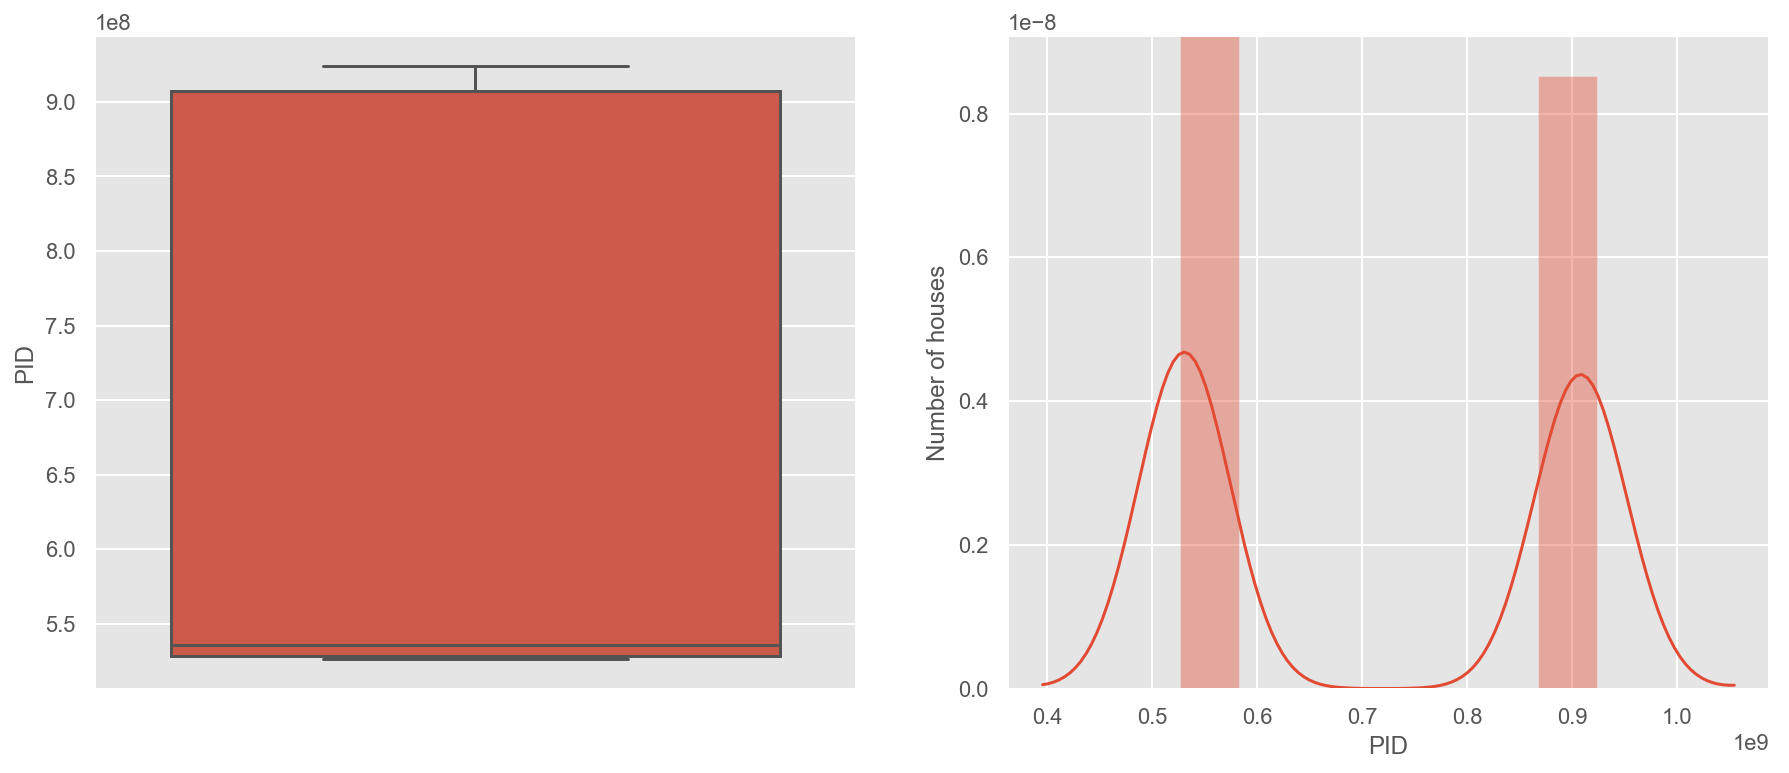

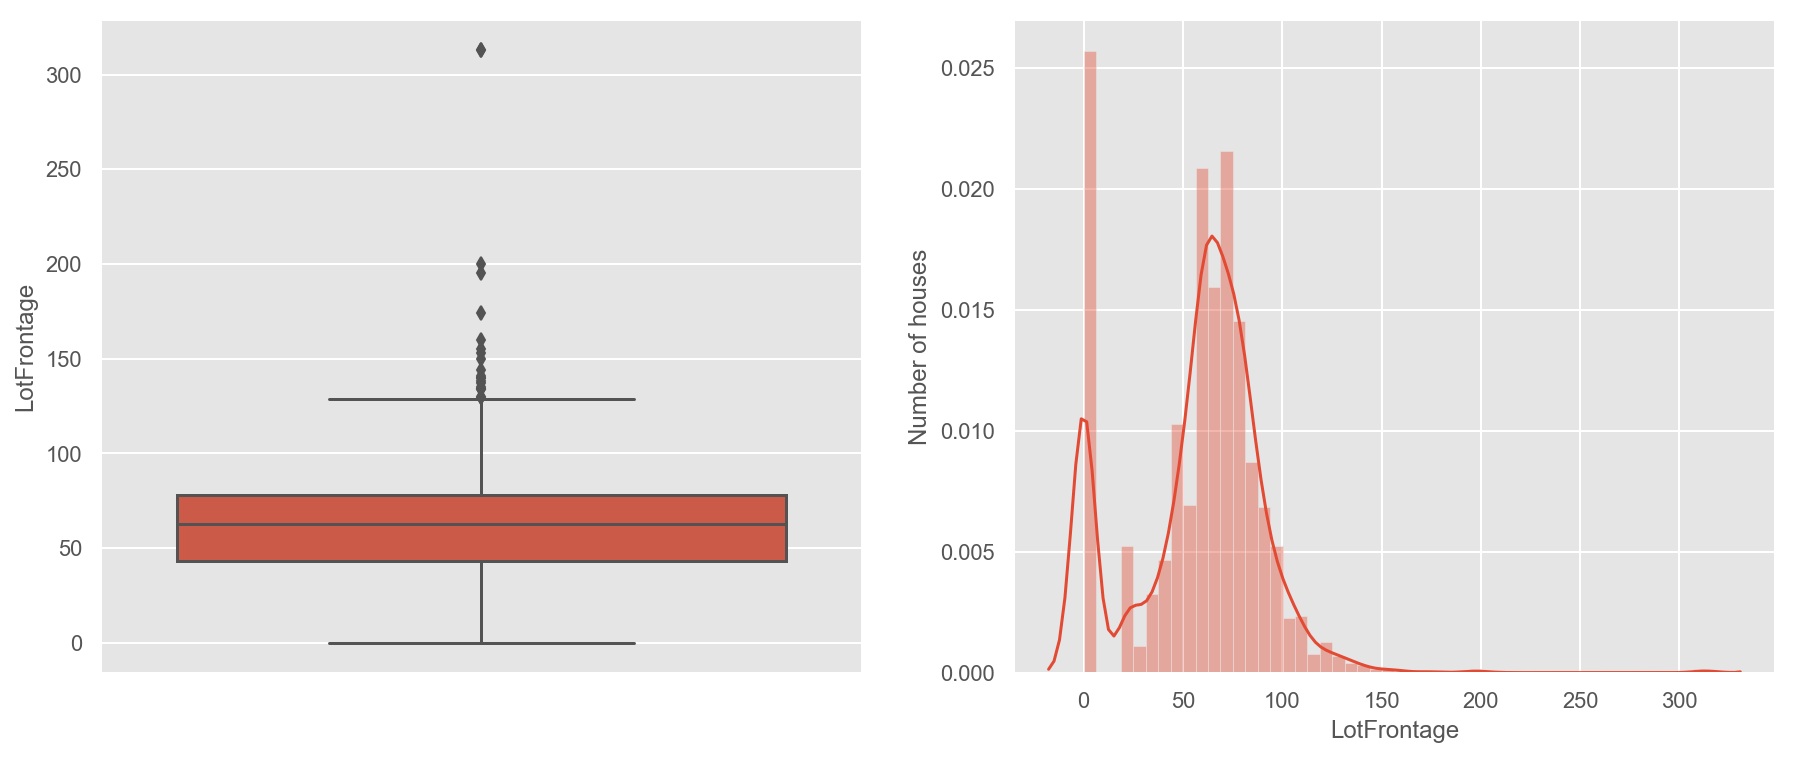

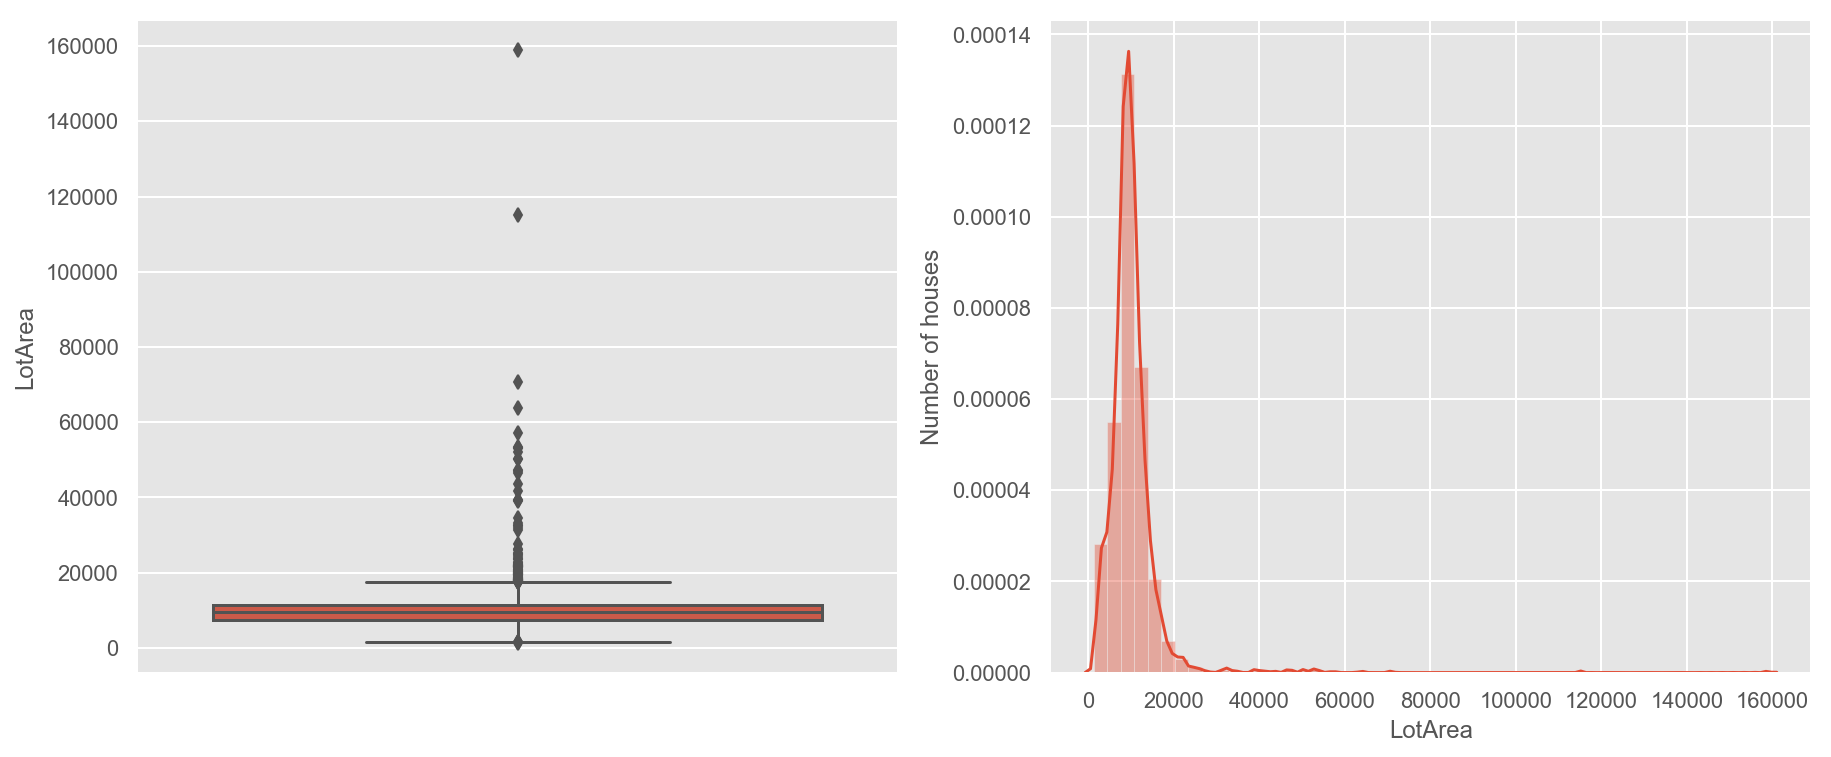

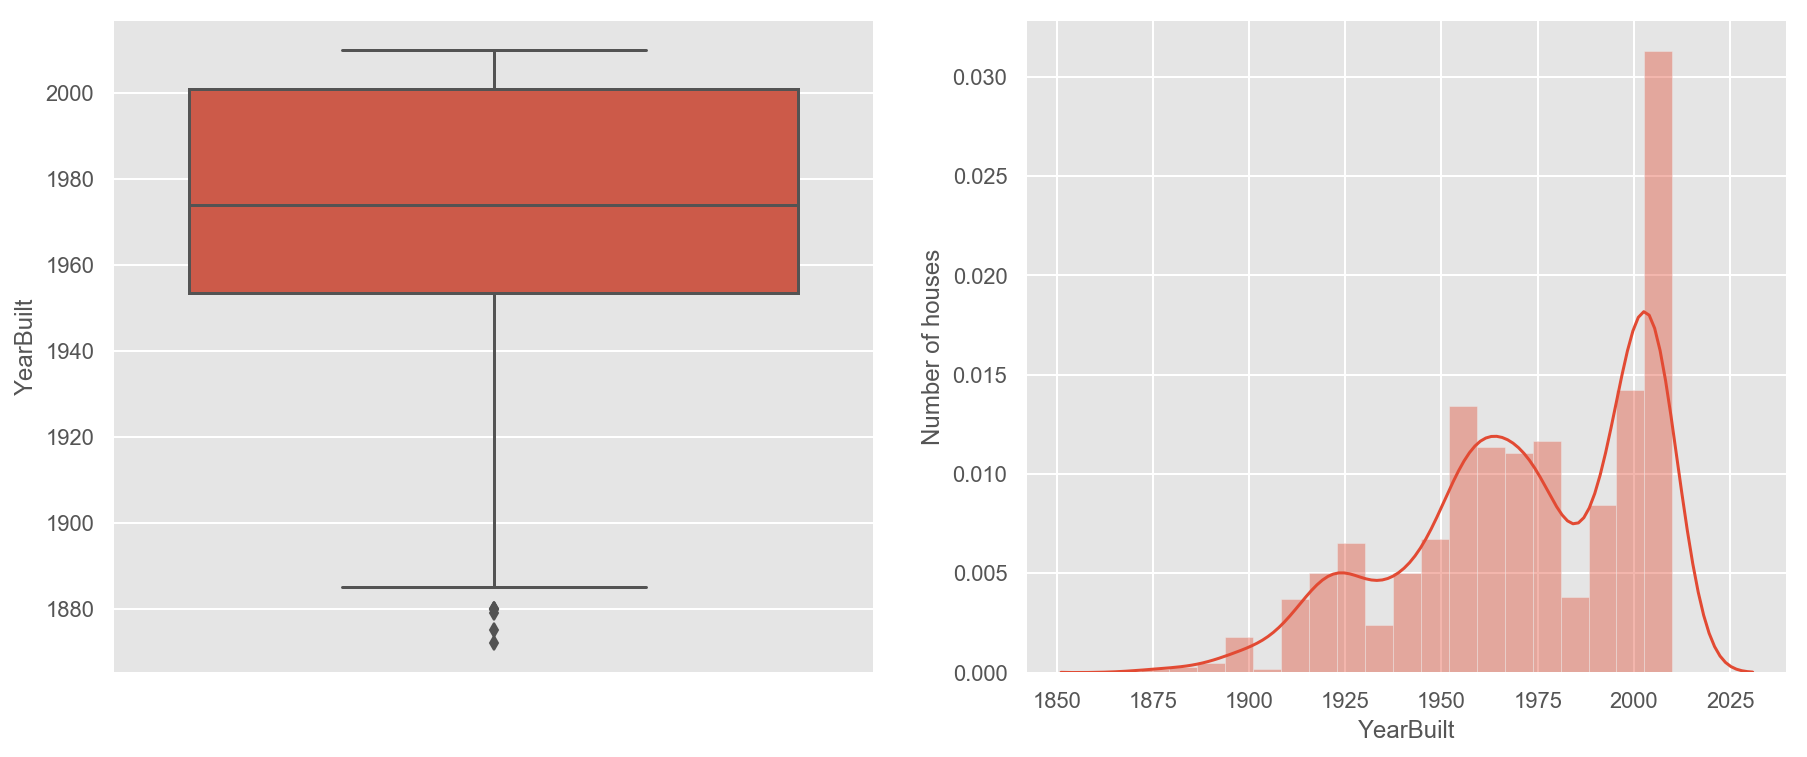

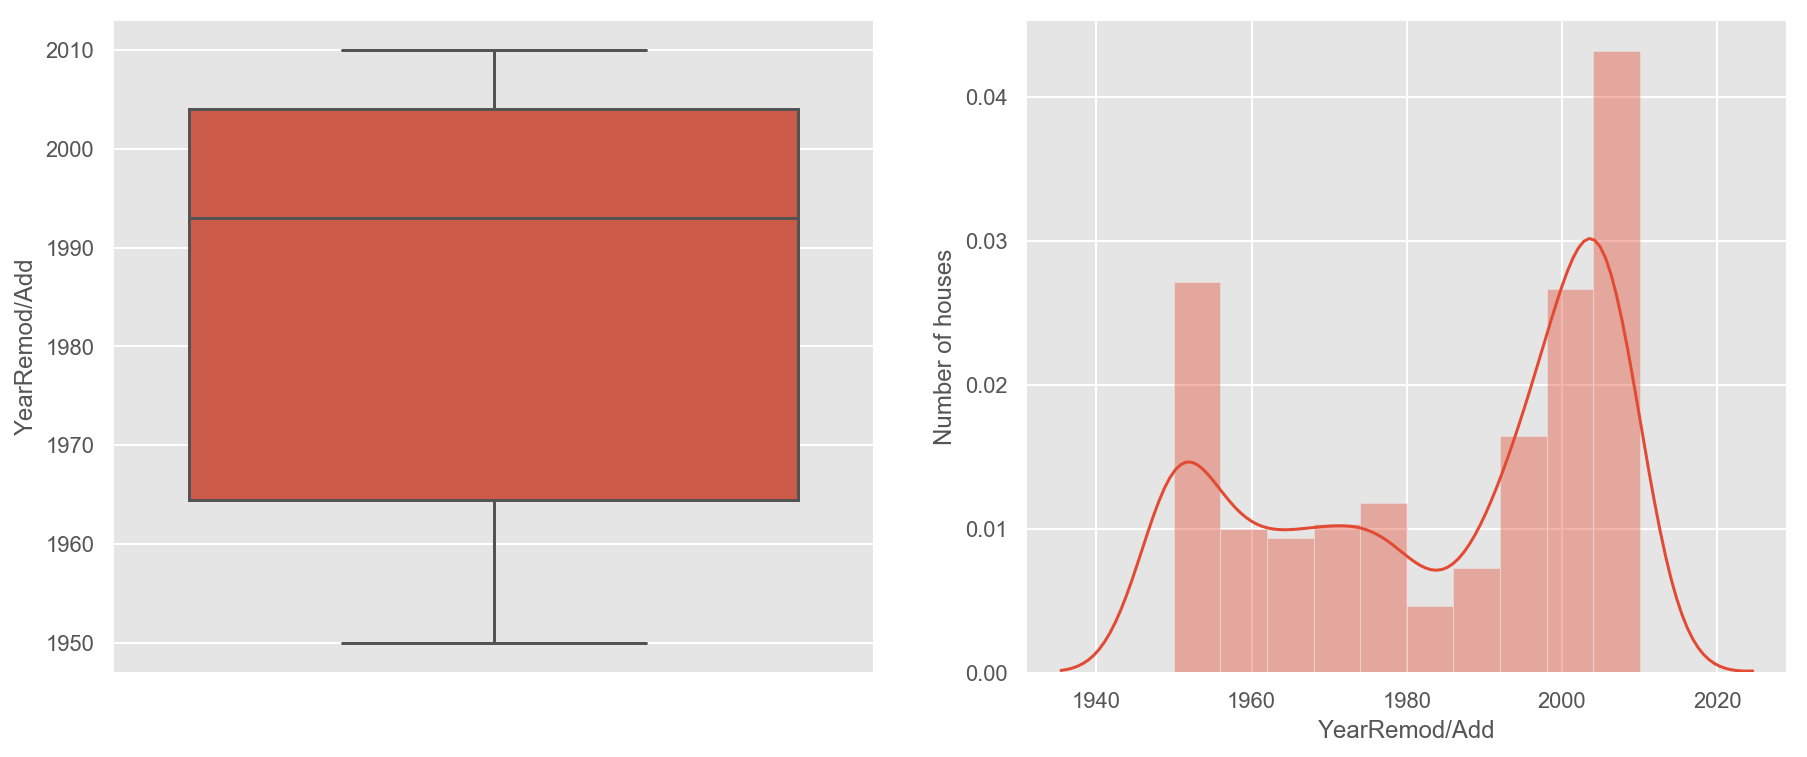

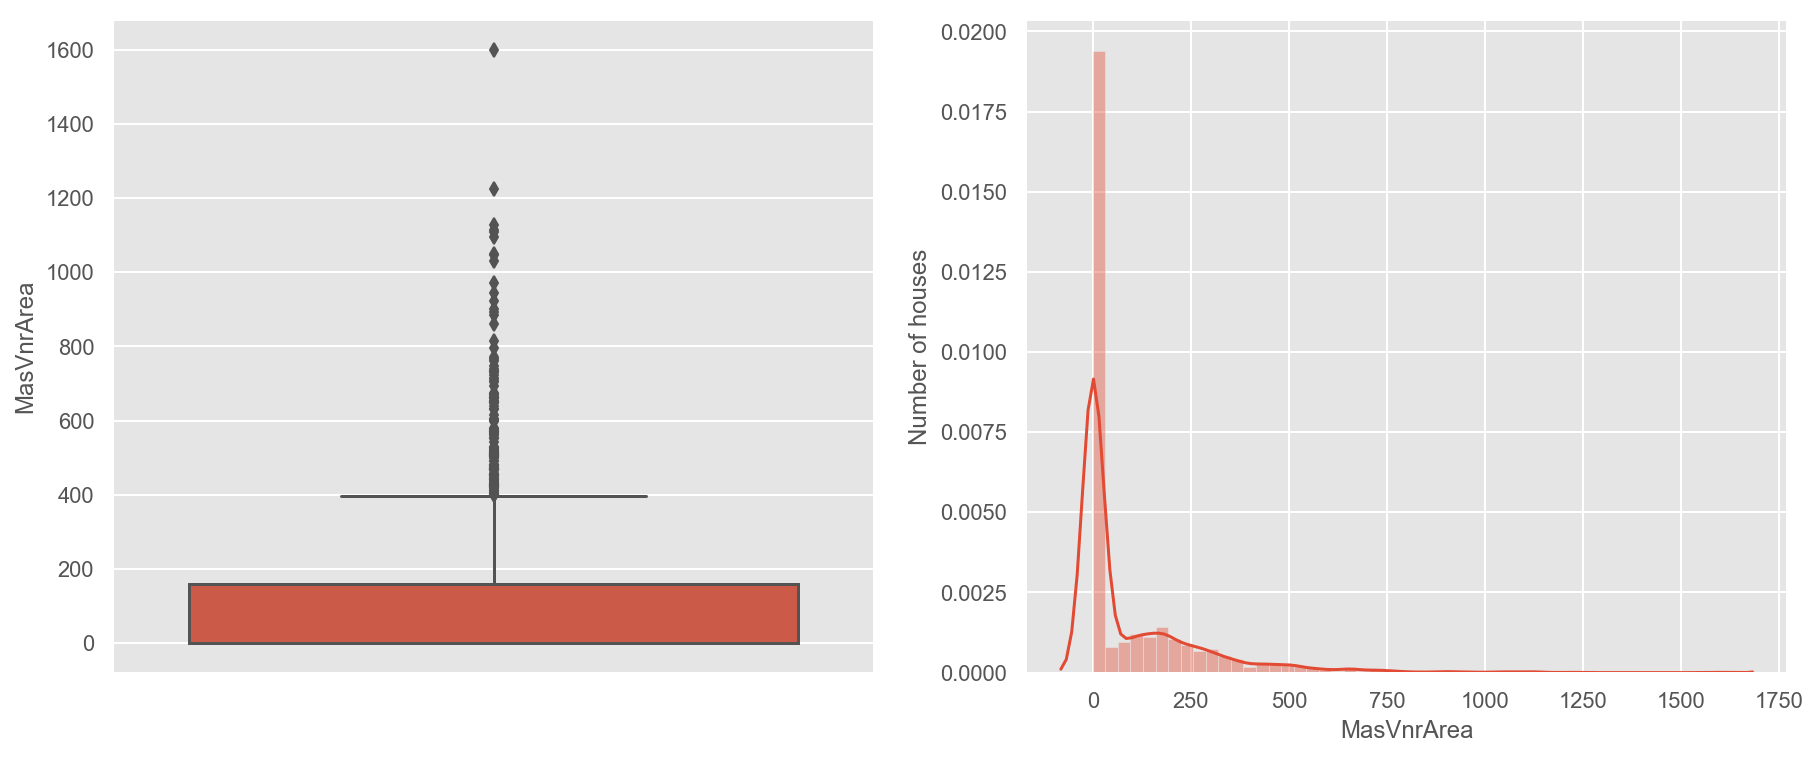

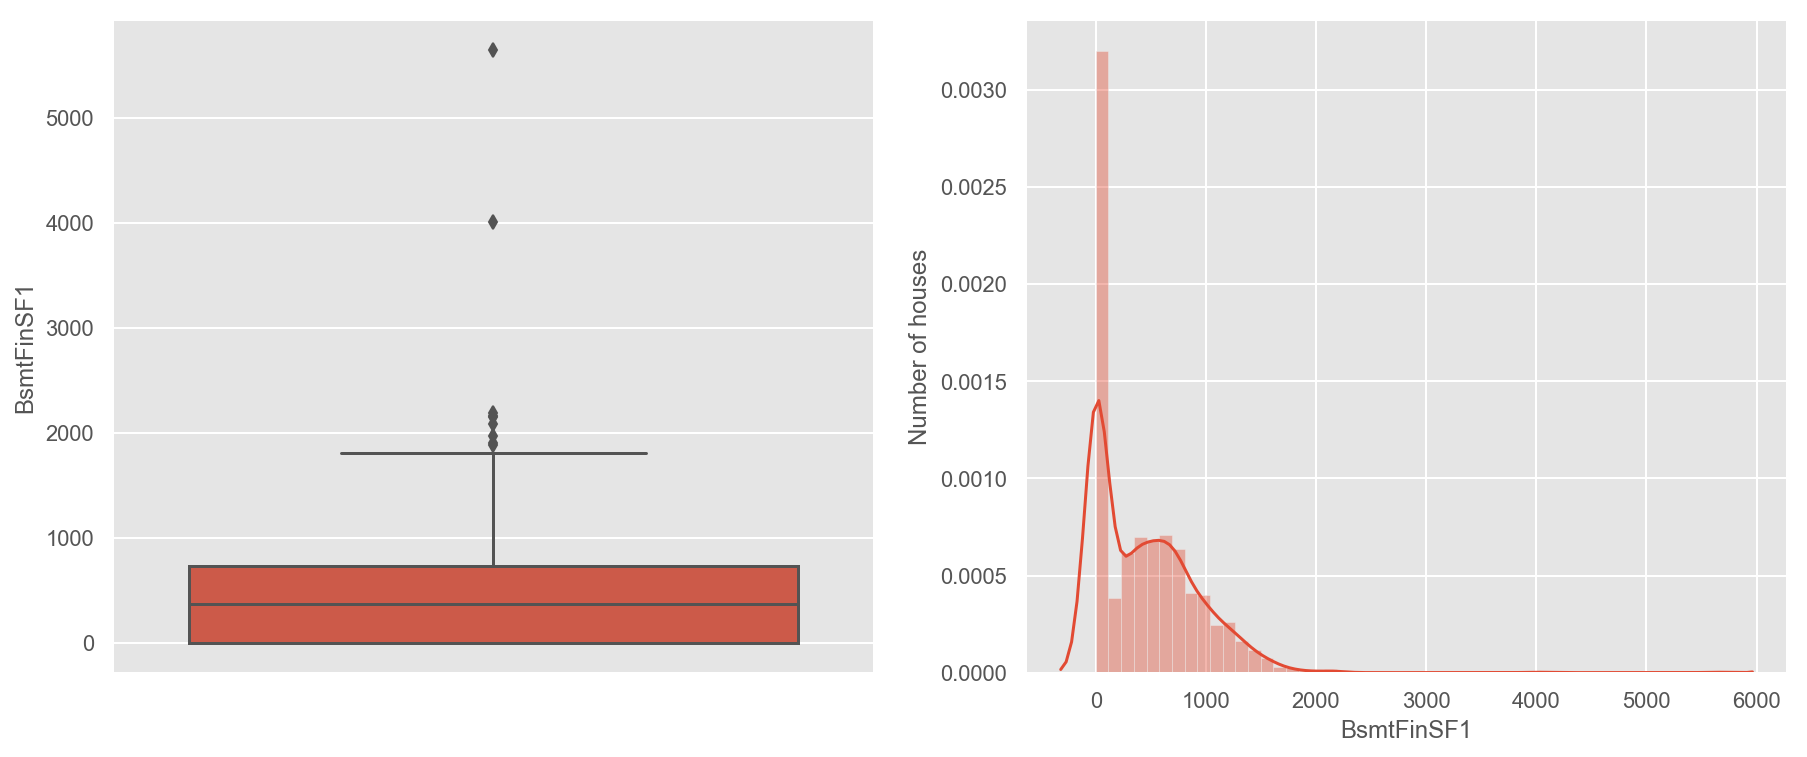

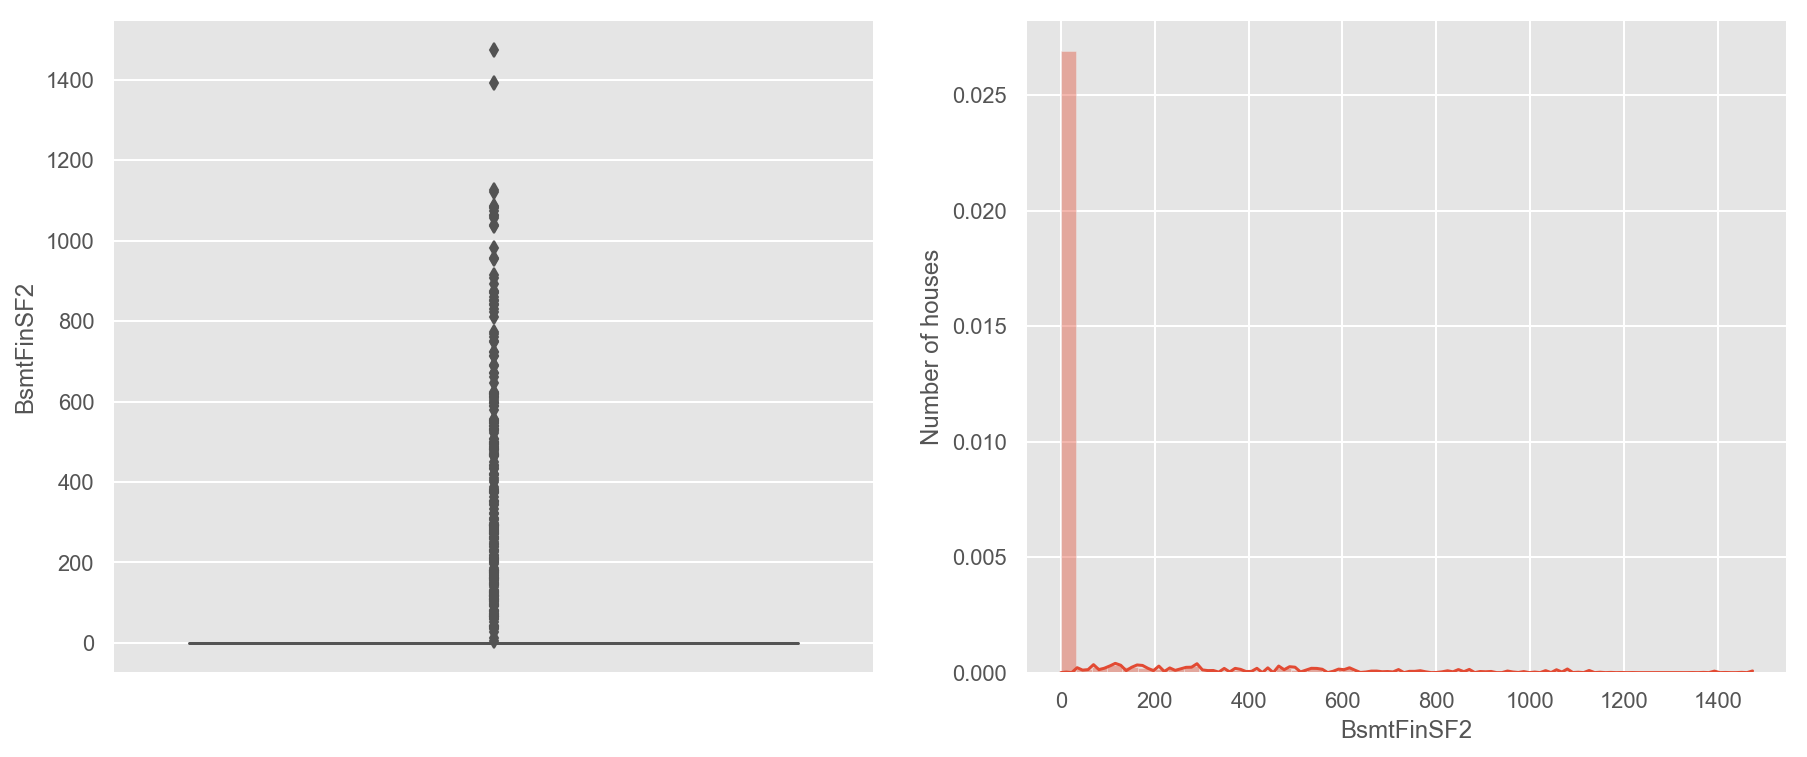

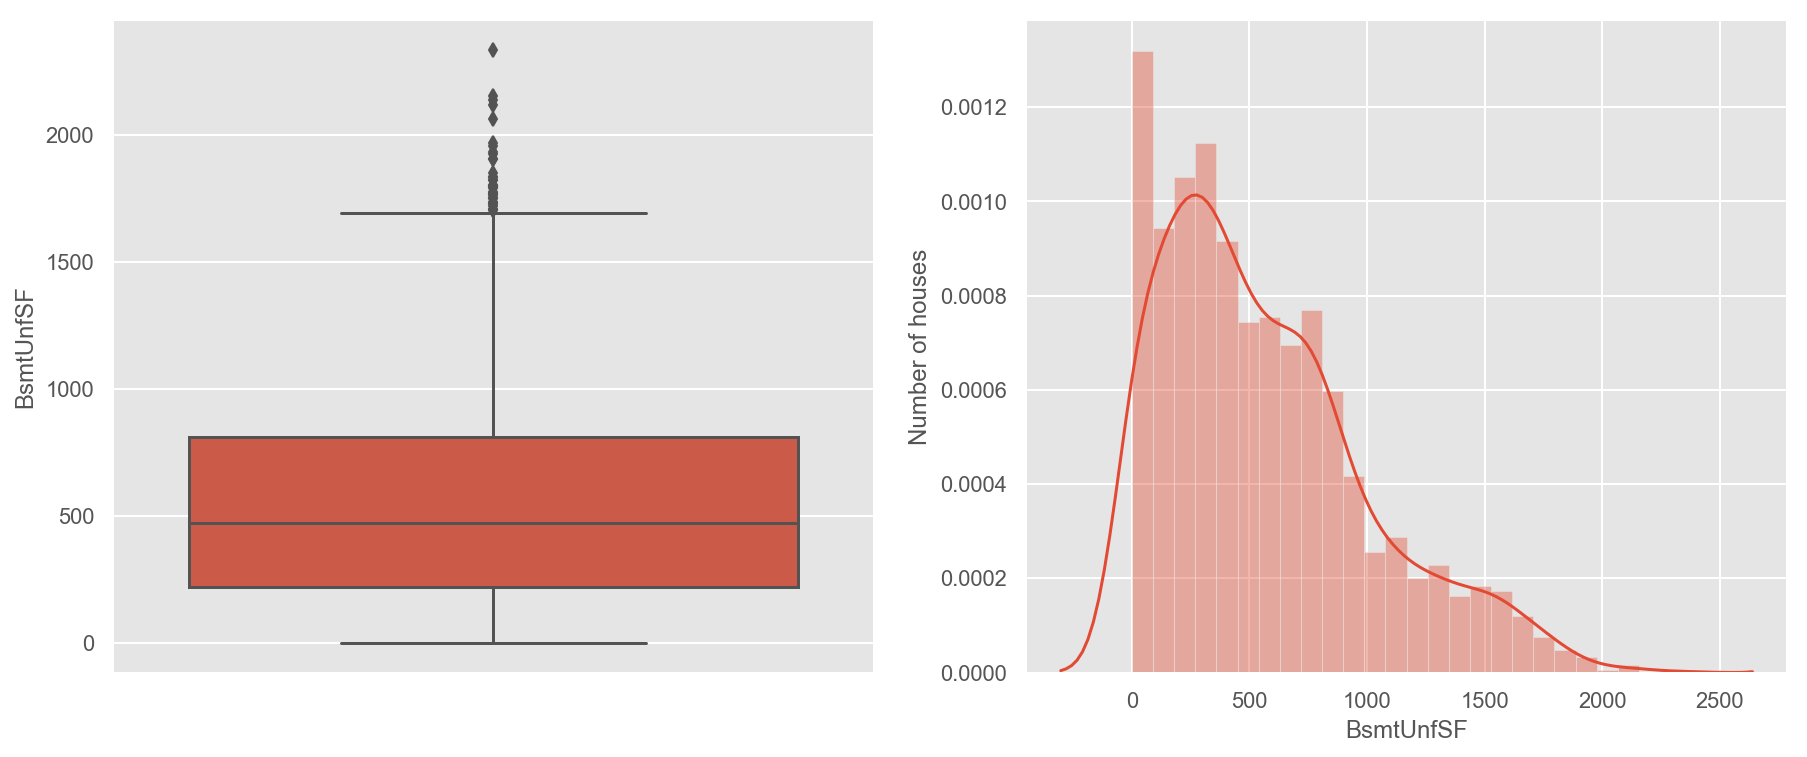

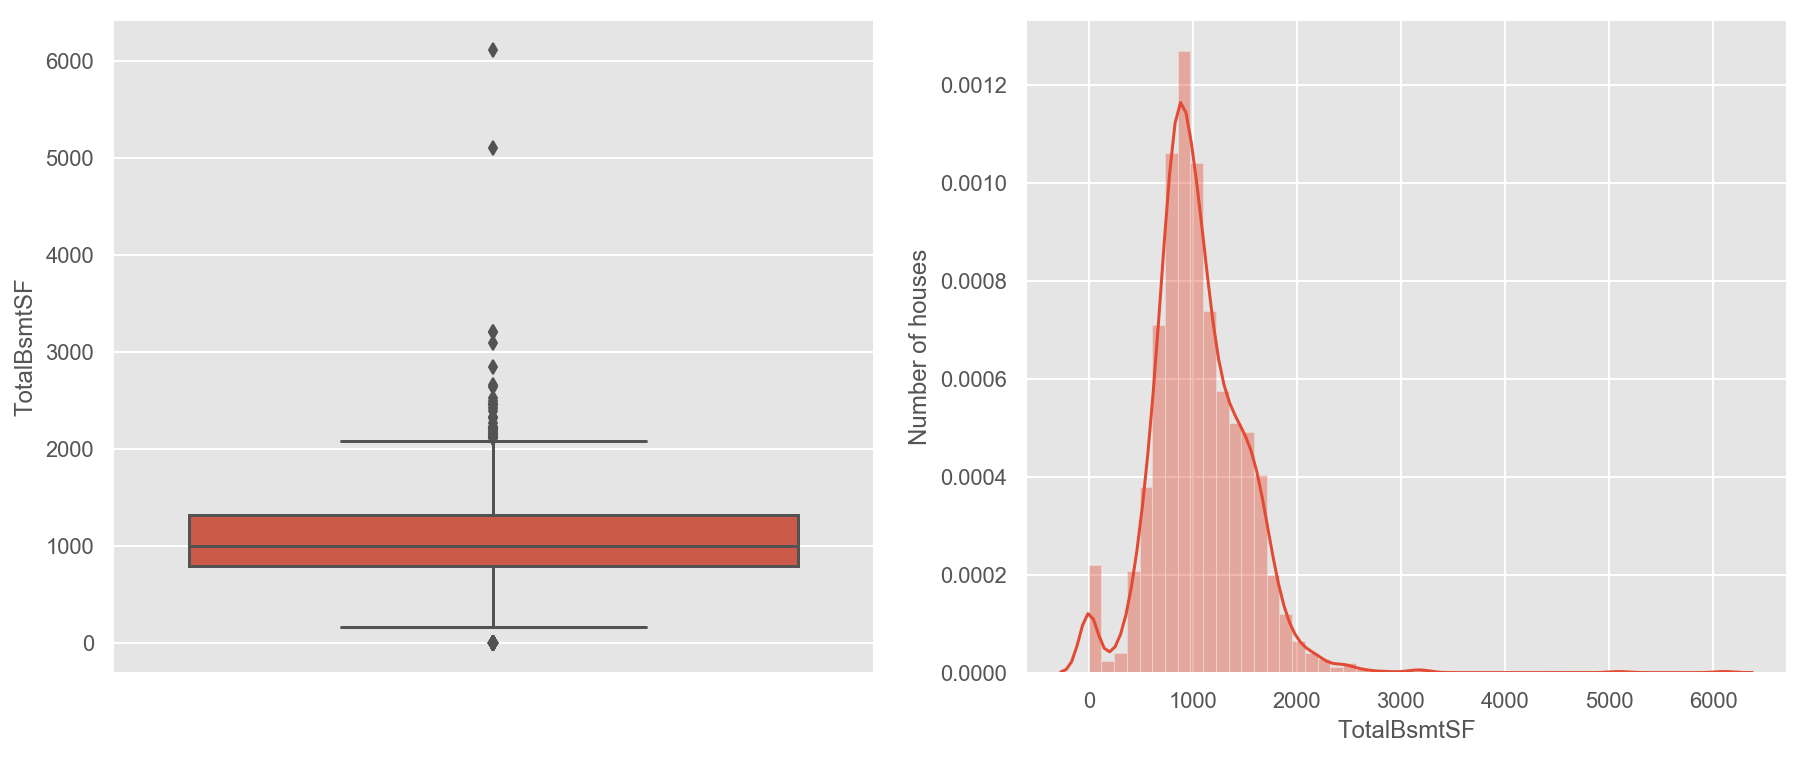

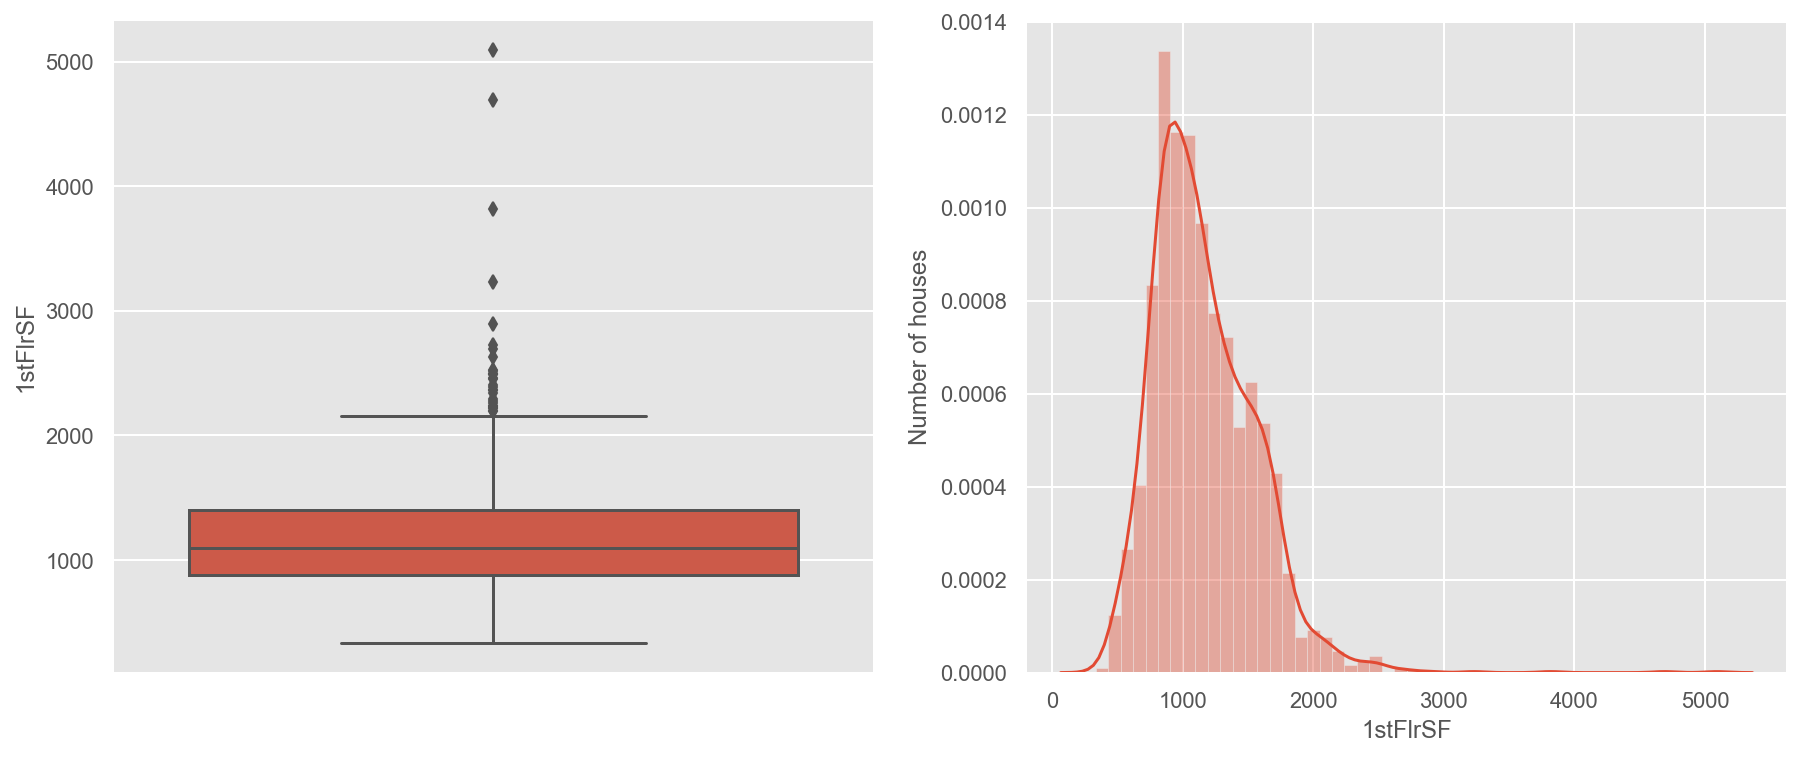

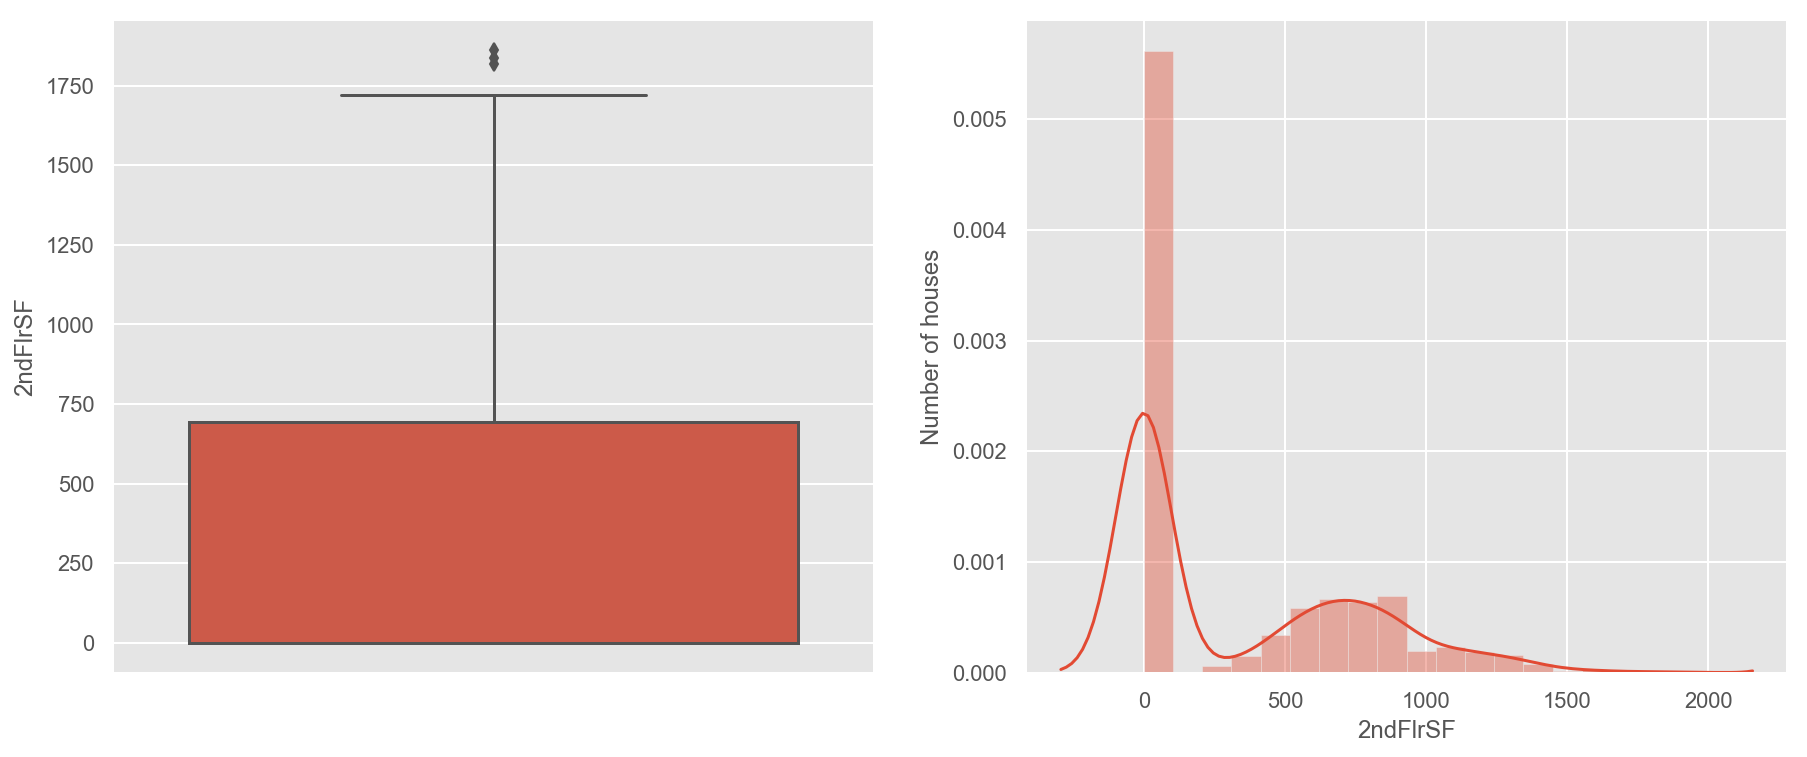

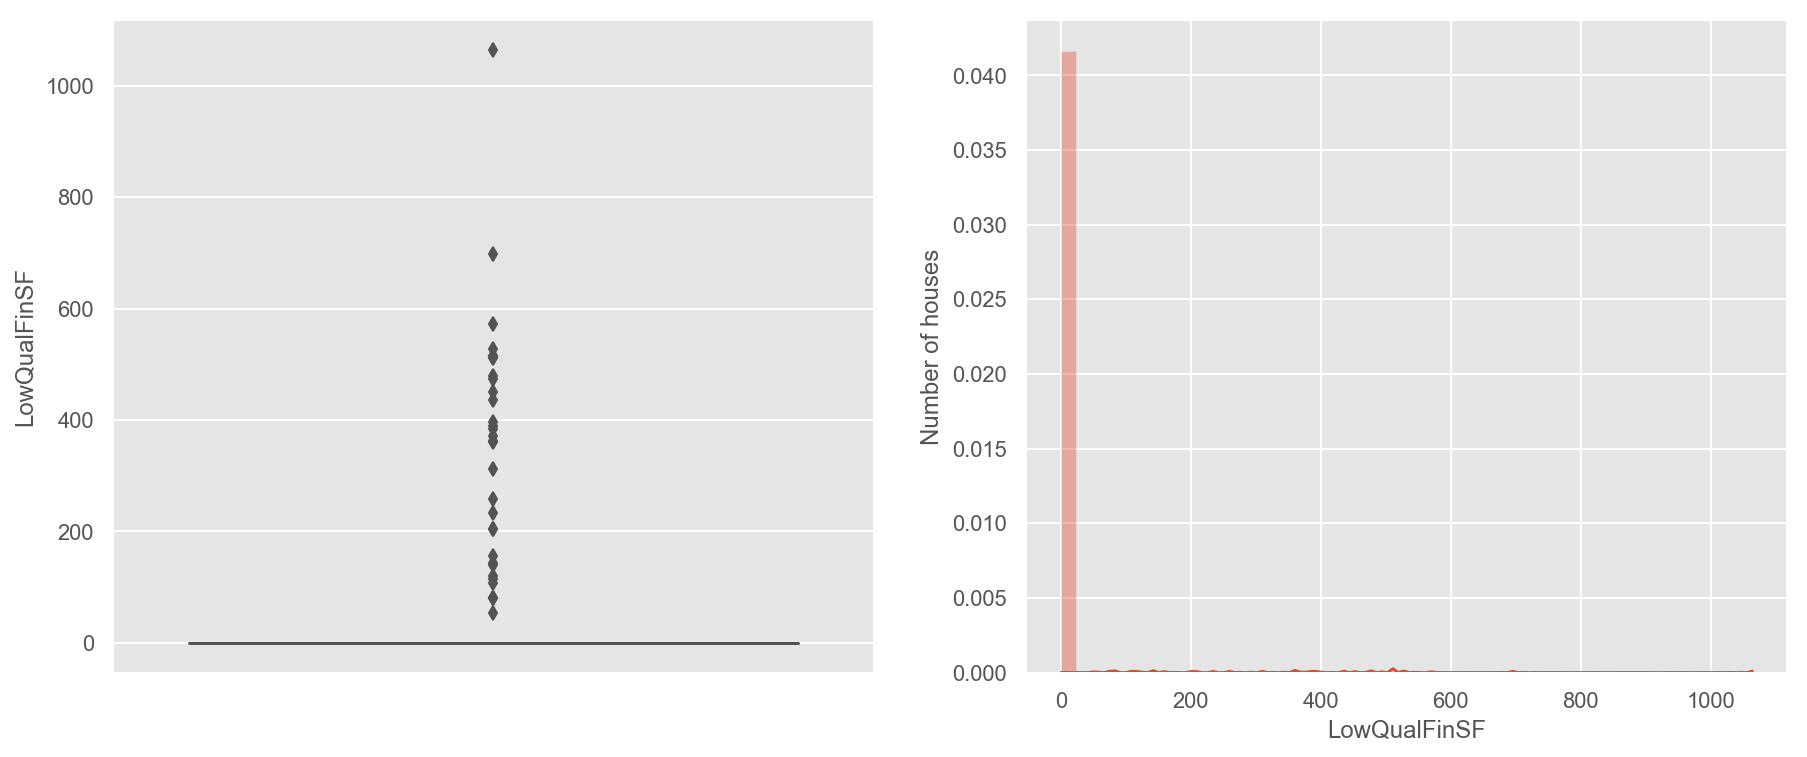

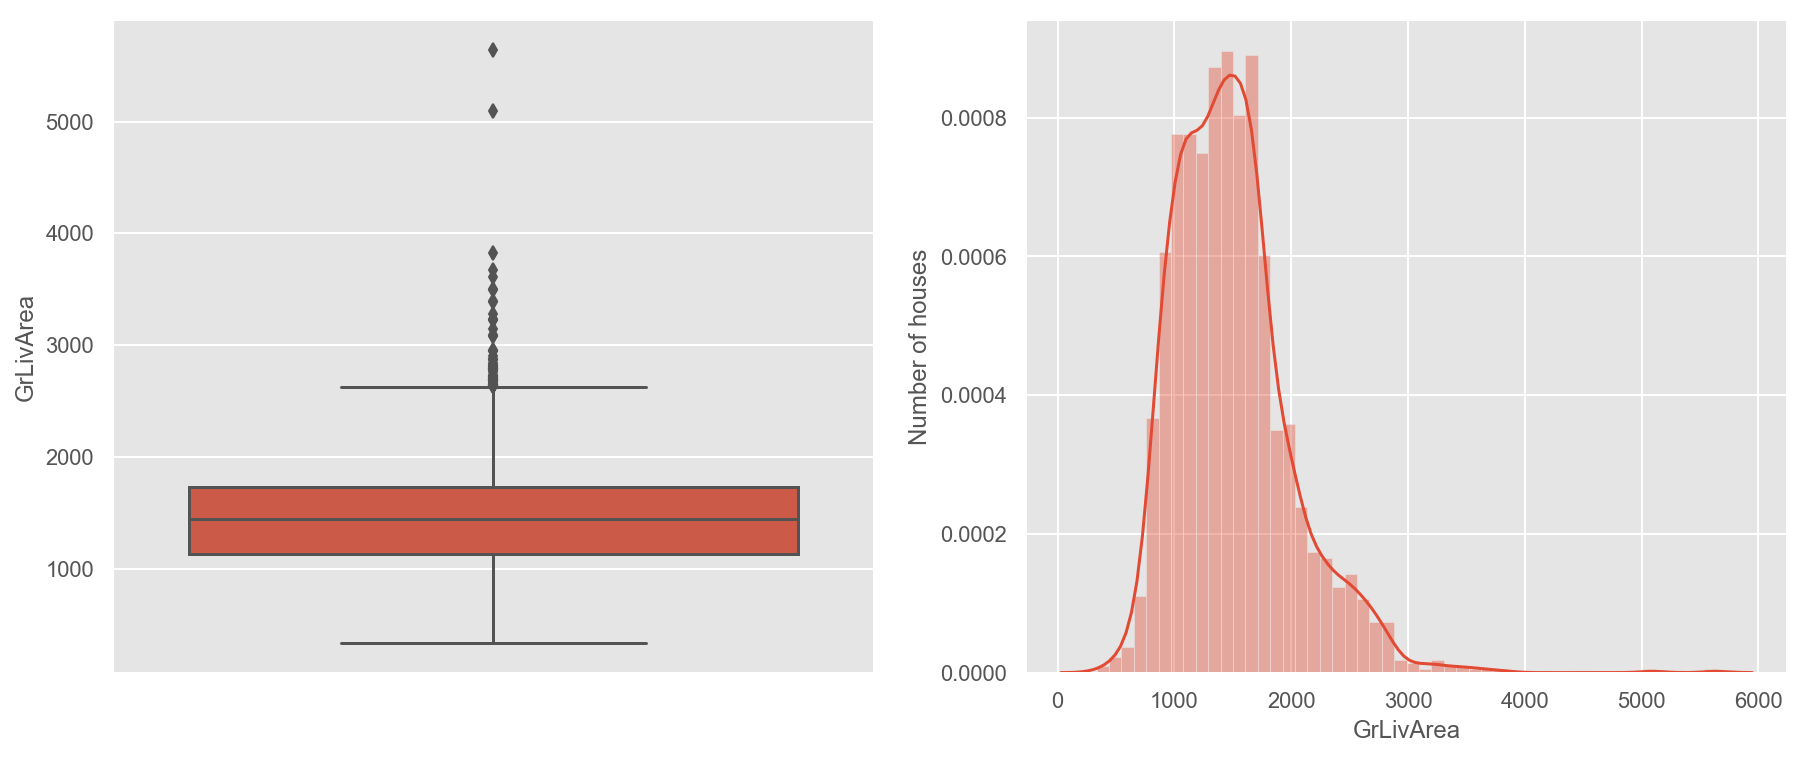

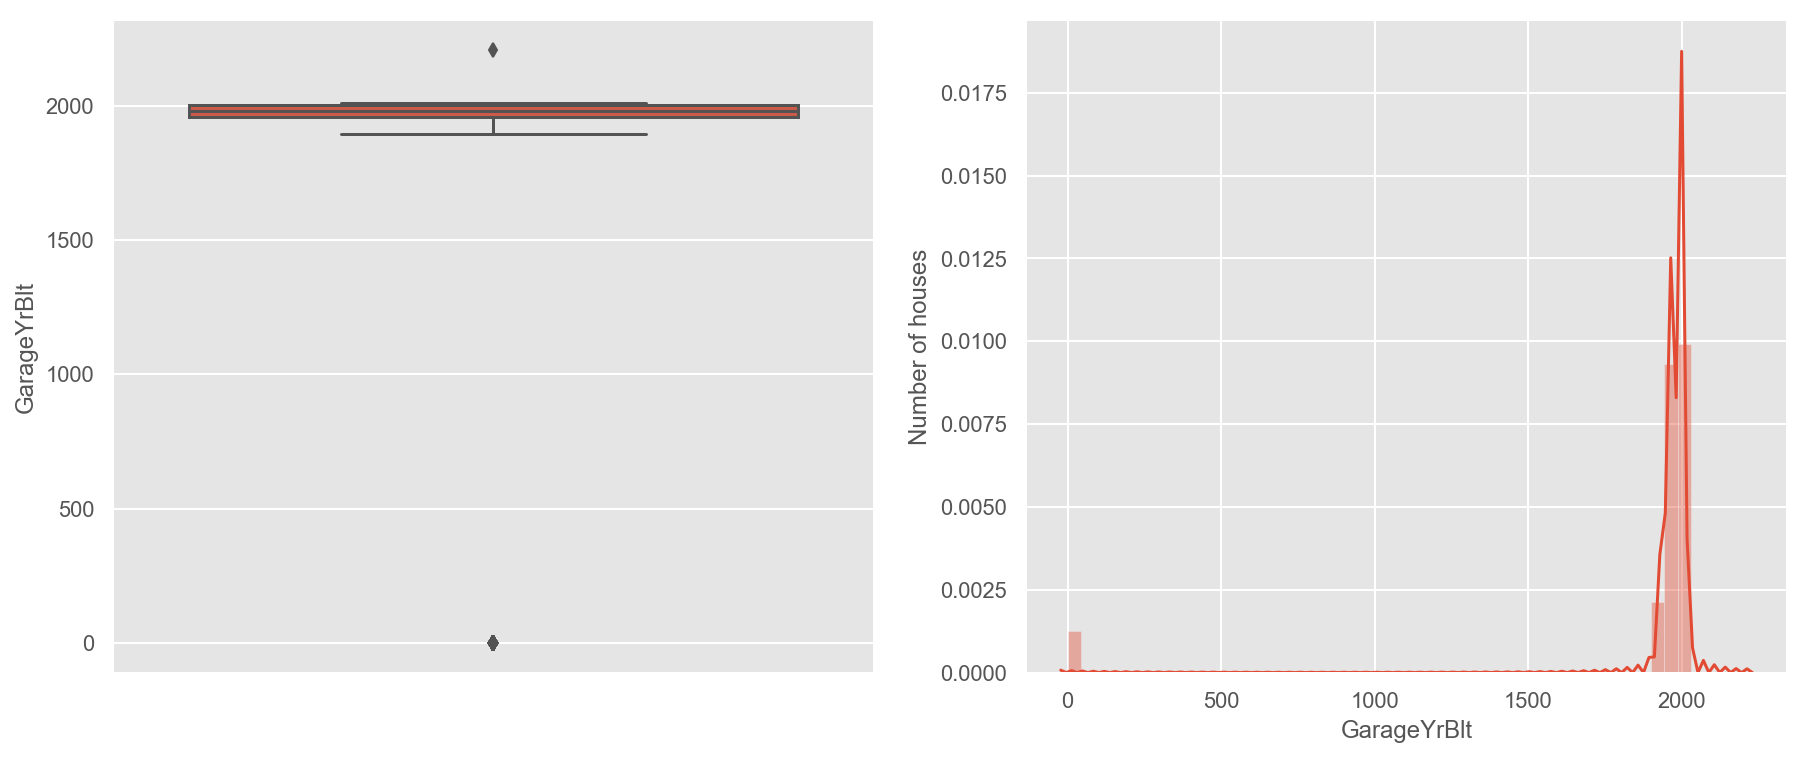

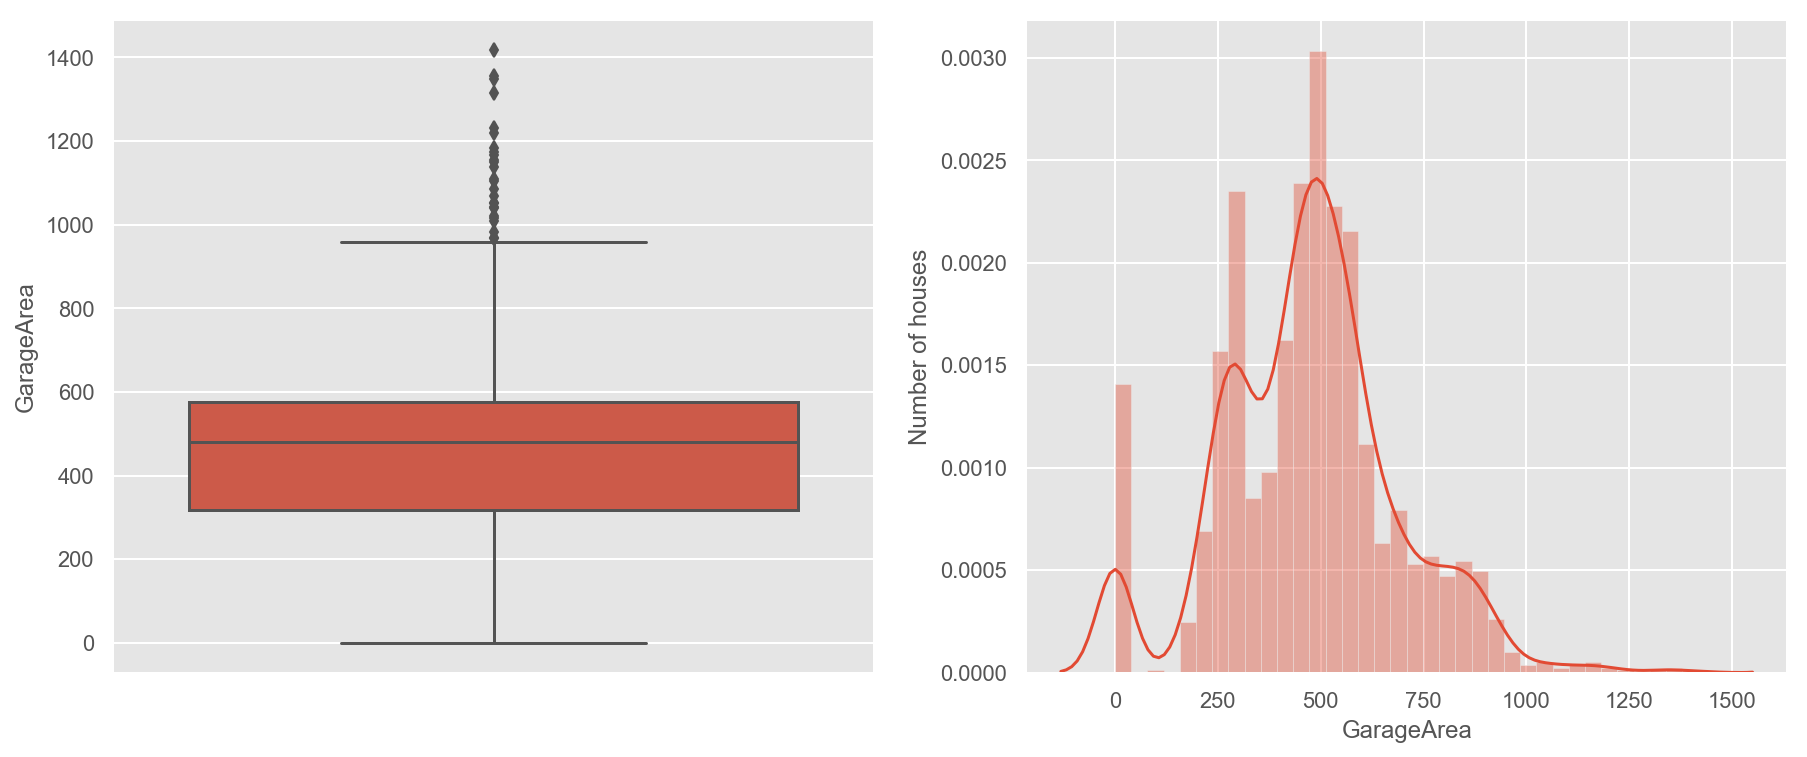

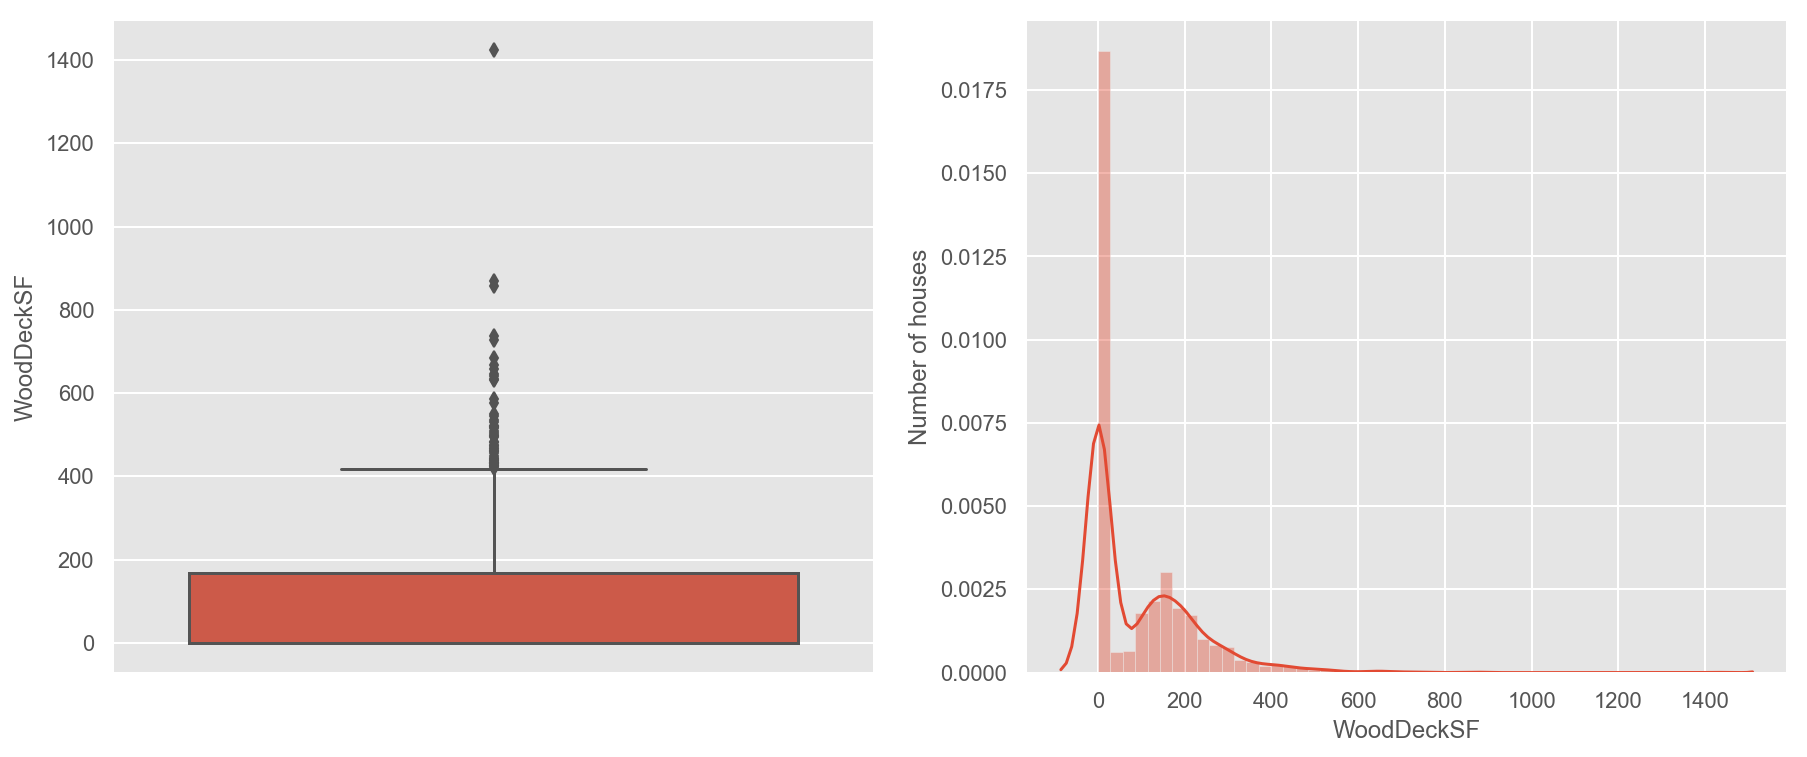

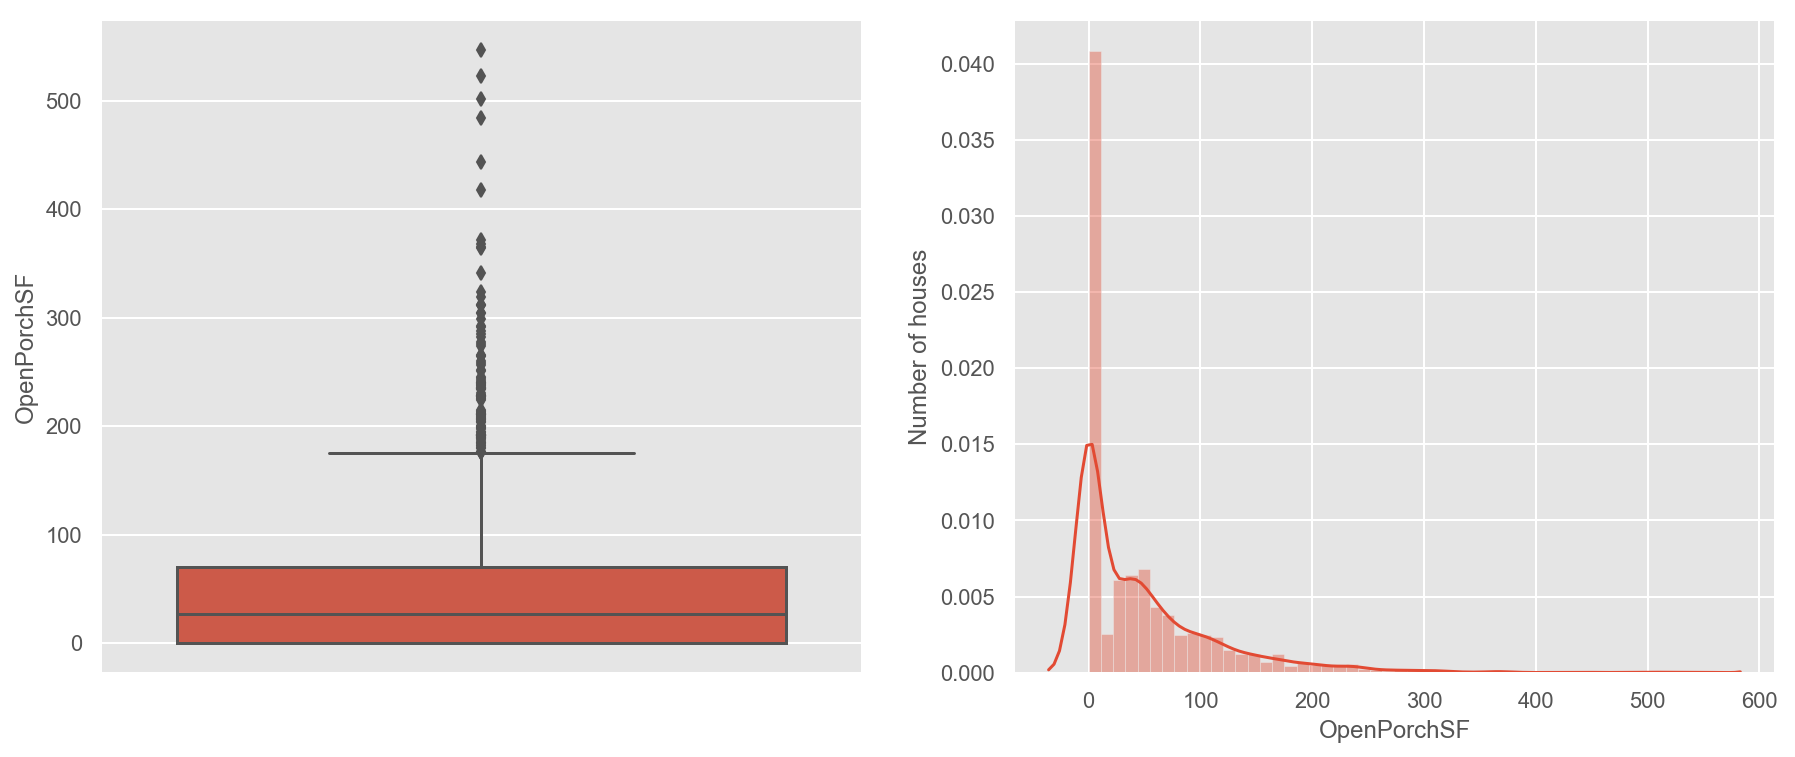

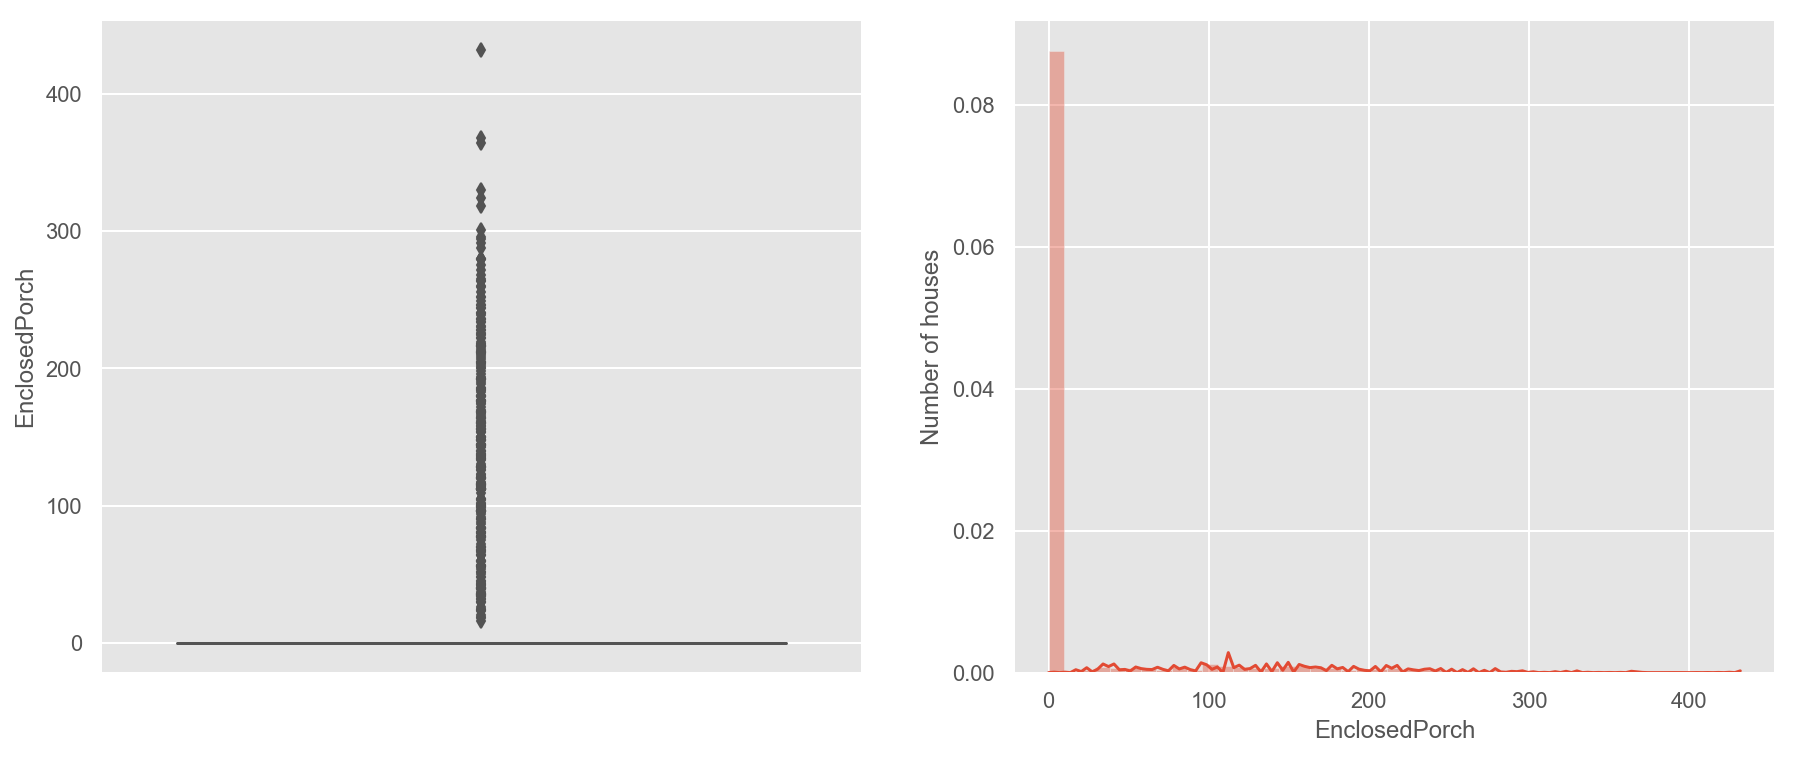

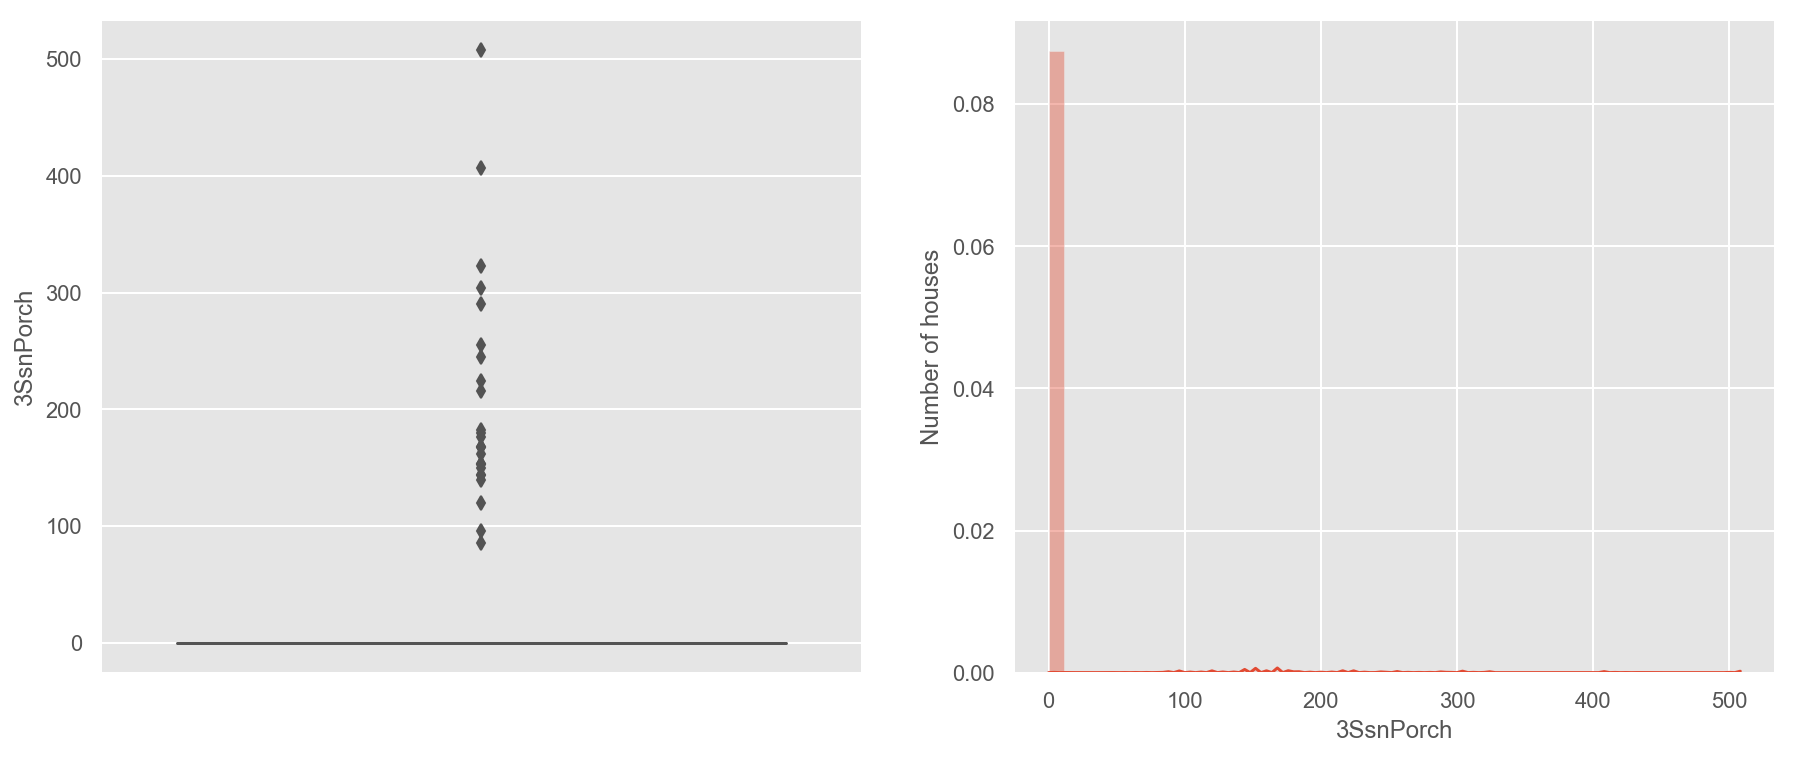

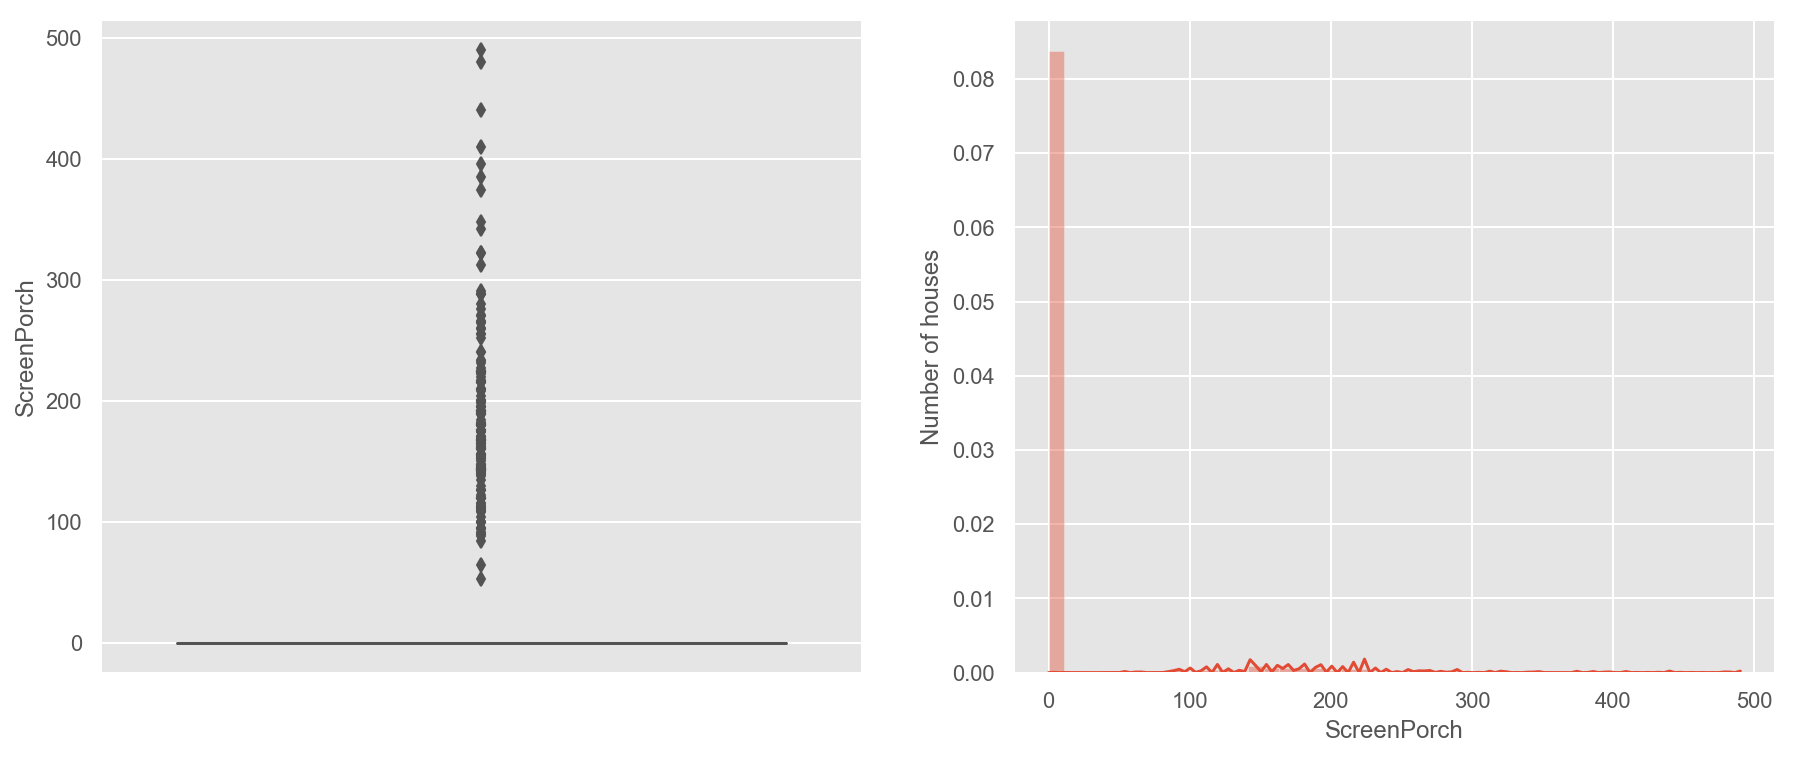

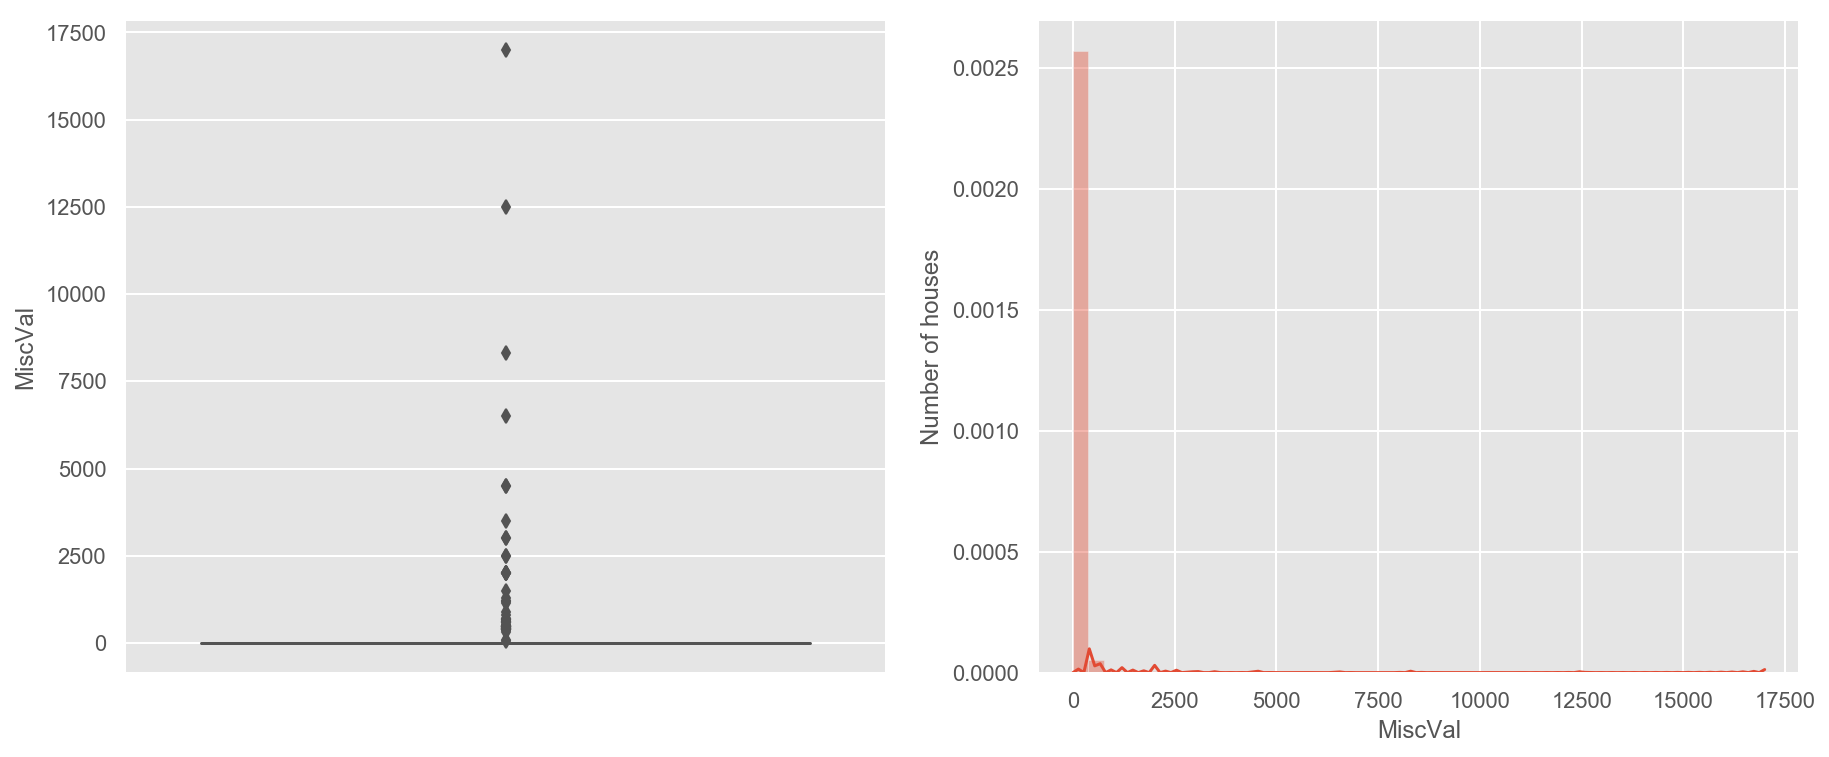

In [134]:
#  boxplots to visualise outliers in the continuous numerical variables 
# and histograms to get an idea of the distribution
for var in continuous_train:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=train_df[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(train_df[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

##### Most of the continuous numerical variables have outliers and not normally distributed

In [135]:
#find the outlies in discrete variables
for var in discrete:
    print(train_df[var].value_counts() / np.float(len(train_df)))
    print()

20     0.375427
60     0.192101
50     0.096538
120    0.064359
30     0.049244
70     0.043881
160    0.042906
80     0.041931
90     0.036568
190    0.022428
85     0.013652
75     0.007801
45     0.005363
180    0.005363
40     0.001950
150    0.000488
Name: MSSubClass, dtype: float64

5     0.274500
6     0.246709
7     0.210141
8     0.121892
4     0.077523
9     0.037543
3     0.014139
10    0.011214
2     0.004388
1     0.001950
Name: OverallQual, dtype: float64

5    0.569478
6    0.179425
7    0.131643
8    0.049244
4    0.034130
3    0.017065
9    0.014139
2    0.002925
1    0.001950
Name: OverallCond, dtype: float64

0.0    0.586056
1.0    0.401755
2.0    0.011214
3.0    0.000975
Name: BsmtFullBath, dtype: float64

0.0    0.938567
1.0    0.059483
2.0    0.001950
Name: BsmtHalfBath, dtype: float64

2    0.534373
1    0.438810
3    0.021941
0    0.003901
4    0.000975
Name: FullBath, dtype: float64

0    0.637738
1    0.353486
2    0.008776
Name: HalfBath, dtype: float64

3   

C:\Users\R.A\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


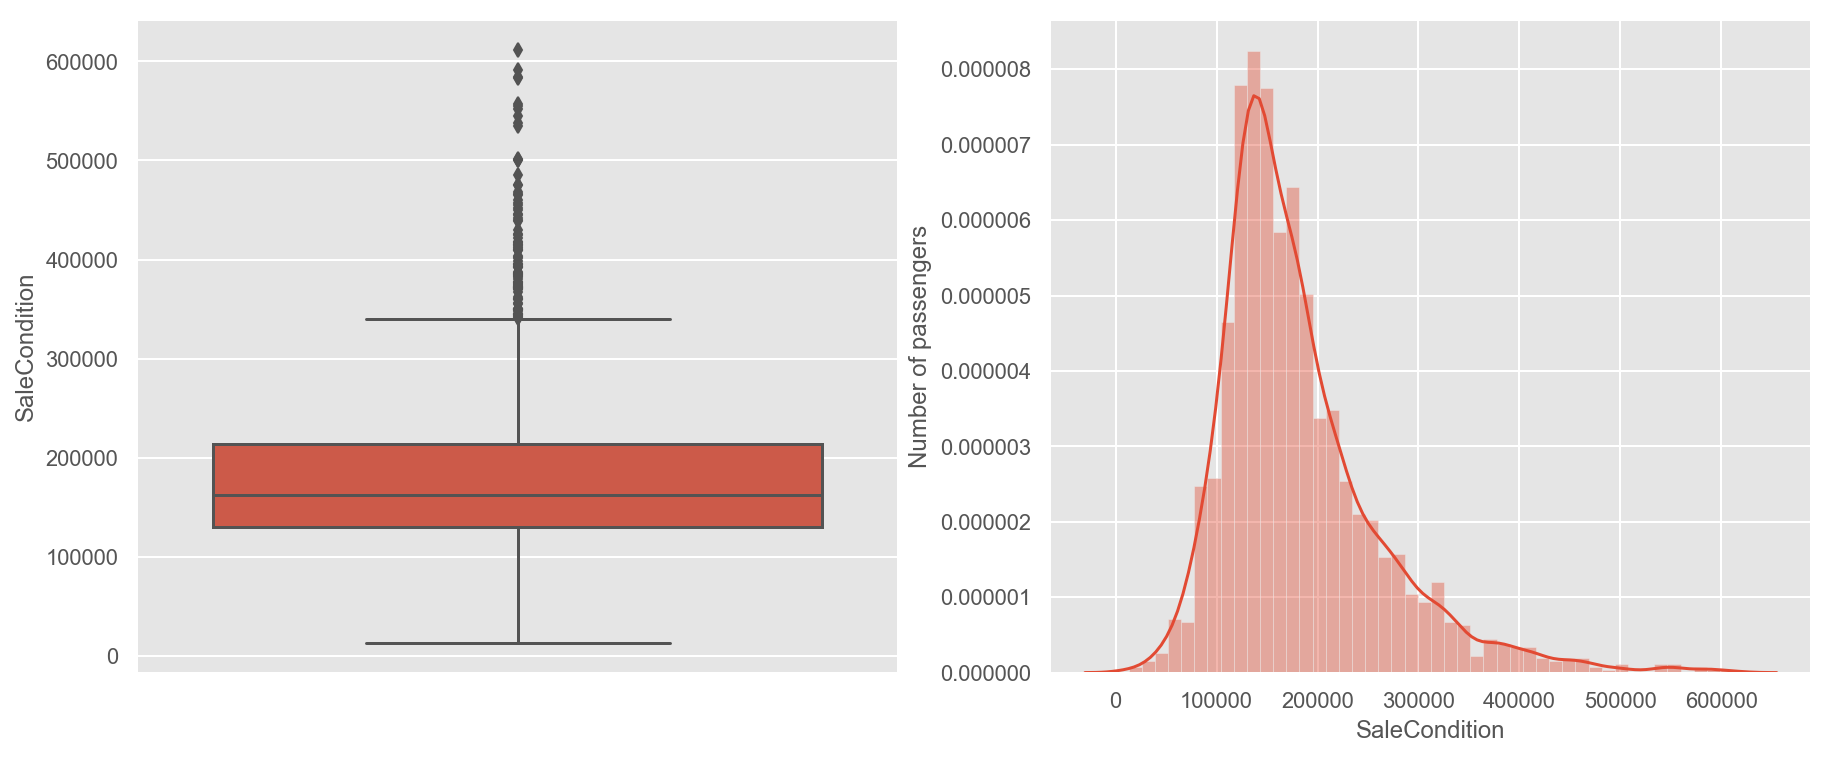

In [136]:
#visulaizing the target
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=train_df['SalePrice'])
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(train_df['SalePrice'].dropna())#.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel(var)

plt.show()

### 2. Categorical data

In [137]:
for var in categorical_train:
    print(var, ' contains ', len(train_df[var].unique()), ' labels')

MSZoning  contains  7  labels
Street  contains  2  labels
Alley  contains  3  labels
LotShape  contains  4  labels
LandContour  contains  4  labels
Utilities  contains  3  labels
LotConfig  contains  5  labels
LandSlope  contains  3  labels
Neighborhood  contains  28  labels
Condition1  contains  9  labels
Condition2  contains  8  labels
BldgType  contains  5  labels
HouseStyle  contains  8  labels
RoofStyle  contains  6  labels
RoofMatl  contains  6  labels
Exterior1st  contains  15  labels
Exterior2nd  contains  15  labels
MasVnrType  contains  4  labels
ExterQual  contains  4  labels
ExterCond  contains  5  labels
Foundation  contains  6  labels
BsmtQual  contains  6  labels
BsmtCond  contains  6  labels
BsmtExposure  contains  5  labels
BsmtFinType1  contains  7  labels
BsmtFinType2  contains  7  labels
Heating  contains  5  labels
HeatingQC  contains  5  labels
CentralAir  contains  2  labels
Electrical  contains  5  labels
KitchenQual  contains  4  labels
Functional  contains  8 

In [138]:
for x in categorical_train:
    print(x,"," , train_df[x].dtype)

MSZoning , object
Street , object
Alley , object
LotShape , object
LandContour , object
Utilities , object
LotConfig , object
LandSlope , object
Neighborhood , object
Condition1 , object
Condition2 , object
BldgType , object
HouseStyle , object
RoofStyle , object
RoofMatl , object
Exterior1st , object
Exterior2nd , object
MasVnrType , object
ExterQual , object
ExterCond , object
Foundation , object
BsmtQual , object
BsmtCond , object
BsmtExposure , object
BsmtFinType1 , object
BsmtFinType2 , object
Heating , object
HeatingQC , object
CentralAir , object
Electrical , object
KitchenQual , object
Functional , object
FireplaceQu , object
GarageType , object
GarageFinish , object
GarageQual , object
GarageCond , object
PavedDrive , object
PoolQC , object
Fence , object
MiscFeature , object
SaleType , object


In [139]:
# Dummifying only the target SaleCondition

df1_SCdummy=train_df
cc=pd.get_dummies(df1_SCdummy[categorical_train],drop_first=True)
df1_SCdummy=df1_SCdummy.drop(df1_SCdummy[categorical_train],axis=1)
df1_SCdummy=df1_SCdummy.join(cc)
df1_SCdummy=df1_SCdummy.sort_values('Id')


df1_SCdummy

Id        PID  MSSubClass  LotFrontage  LotArea  OverallQual  \
1080     1  526301100          20        141.0    31770            6   
304      3  526351010          20         81.0    14267            6   
574      5  527105010          60         74.0    13830            5   
1673     8  527145080         120         43.0     5005            8   
458      9  527146030         120         39.0     5389            8   
2050    10  527162130          60         60.0     7500            7   
1649    11  527163010          60         75.0    10000            6   
23      12  527165230          20          0.0     7980            6   
1146    13  527166040          60         63.0     8402            6   
1123    14  527180040          20         85.0    10176            7   
1313    15  527182190         120          0.0     6820            8   
823     16  527216070          60         47.0    53504            8   
140     19  527276150          20        140.0    19138            4   
1917    20  527302110          20         85.0    13175            6   
37      21  527358140          20        105.0    11751            6   
1533    23  527368020          60          0.0     7500            7   
210     24  527402200          20          0.0    11241            6   
2031    25  527402250          20          0.0    12537            5   
1034    26  527403020          20         65.0     8450            5   
1037    28  527425090          20         70.0    10500            4   
1350    29  527427230         120         26.0     5858            7   
179     30  527451180         160         21.0     1680            6   
1834    32  527451410         160         21.0     1680            6   
1297    33  527452190         120         53.0     4043            6   
282     34  527453130         160         24.0     2280            6   
634     35  527453150         120         24.0     2280            7   
398     37  528108120          60        102.0    12858            9   
778     38  528112020          20         98.0    11478            8   
1063    41  528120100          20         95.0    12182            7   
979     43  528138020          20         79.0    14122            8   
...    ...        ...         ...          ...      ...          ...   
245   2886  913350030          20         69.0    23580            6   
1349  2887  914452060          90         65.0     8385            6   
752   2888  914474020          20         70.0     9116            8   
1344  2890  914476130          80        140.0    11080            6   
1948  2891  914476500          90         82.0    11070            7   
1211  2893  916252170         120          0.0     8239            7   
1726  2894  916325040          20          0.0    50102            6   
1194  2896  916402125          20         54.0    13811            6   
699   2897  916403020          20         50.0     8049            7   
742   2899  916460070          20          0.0     8098            6   
475   2900  916475100          20         85.0    14331            8   
998   2903  921205050          20         88.0    11577            9   
635   2904  923125030          20        125.0    31250            1   
1016  2905  923202025          90         78.0     7020            7   
583   2906  923203090         120         32.0     4500            6   
1008  2907  923203100         120         32.0     4500            6   
36    2910  923225240         160         41.0     2665            5   
1131  2911  923225260         160         42.0     3964            6   
769   2912  923225510          20         58.0    10172            5   
290   2913  923226150          90          0.0    11836            5   
1544  2914  923226180         180         21.0     1470            4   
1447  2915  923226290         160         21.0     1484            4   
315   2918  923228180         160         21.0     1533            4   
1788  2920  923228260         160         21.0  

In [140]:
df1_SCdummy.SaleCondition

1080    0
304     0
574     0
1673    0
458     0
2050    0
1649    0
23      0
1146    0
1123    0
1313    0
823     0
140     0
1917    0
37      0
1533    0
210     0
2031    0
1034    0
1037    0
1350    0
179     0
1834    0
1297    0
282     0
634     0
398     0
778     0
1063    0
979     0
       ..
245     0
1349    0
752     0
1344    0
1948    0
1211    0
1726    0
1194    0
699     0
742     0
475     0
998     0
635     0
1016    0
583     0
1008    0
36      0
1131    0
769     0
290     0
1544    0
1447    0
315     1
1788    0
1878    0
1013    0
1478    0
416     0
651     0
522     0
Name: SaleCondition, Length: 2051, dtype: int64

In [141]:
categorical_train

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

#### Integer Encoding & Dummification

In [142]:
# from sklearn import preprocessing
# encoder = preprocessing.LabelEncoder()
# train_enc=train_df

# train_enc["SaleCondition"] = encoder.fit_transform(train_enc["SaleCondition"].fillna('Nan'))


In [143]:
# GarageFinish  contains  4  labels
# GarageQual  contains  6  labels
# GarageCond  contains  6  labels
# PavedDrive  contains  3  labels
# PoolQC  contains  5  labels
# MiscFeature  contains  6  labels
# SaleType  contains  9  labels
# SaleCondition  contains  6  labels
# train_enc["GarageFinish"] = encoder.fit_transform(train_enc["GarageFinish"])
# train_enc["GarageQual"] = encoder.fit_transform(train_enc["GarageQual"])

# train_enc["GarageCond"] = encoder.fit_transform(train_enc["GarageCond"])

# train_enc["PavedDrive"] = encoder.fit_transform(train_enc["PavedDrive"])

# train_enc["PoolQC"] = encoder.fit_transform(train_enc["PoolQC"])
# train_enc["MiscFeature"] = encoder.fit_transform(train_enc["MiscFeature"])
# train_enc["SaleType"] = encoder.fit_transform(train_enc["SaleType"])
# train_enc["SaleCondition"] = encoder.fit_transform(train_enc["SaleCondition"])


# train_enc

### Finding Correlation with the target (SalePrice) -train

In [144]:
df_num_corr = train_df.corr()['SalePrice'][:-1] # -1 because the latest col is SalePrice
SalePrice_corr_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(SalePrice_corr_features_list), SalePrice_corr_features_list))

There is 11 strongly correlated values with SalePrice:
OverallQual      0.800207
GrLivArea        0.697038
GarageArea       0.649897
GarageCars       0.647781
TotalBsmtSF      0.629303
1stFlrSF         0.618486
YearBuilt        0.571849
YearRemod/Add    0.550370
FullBath         0.537969
TotRmsAbvGrd     0.504014
MasVnrArea       0.503579
Name: SalePrice, dtype: float64


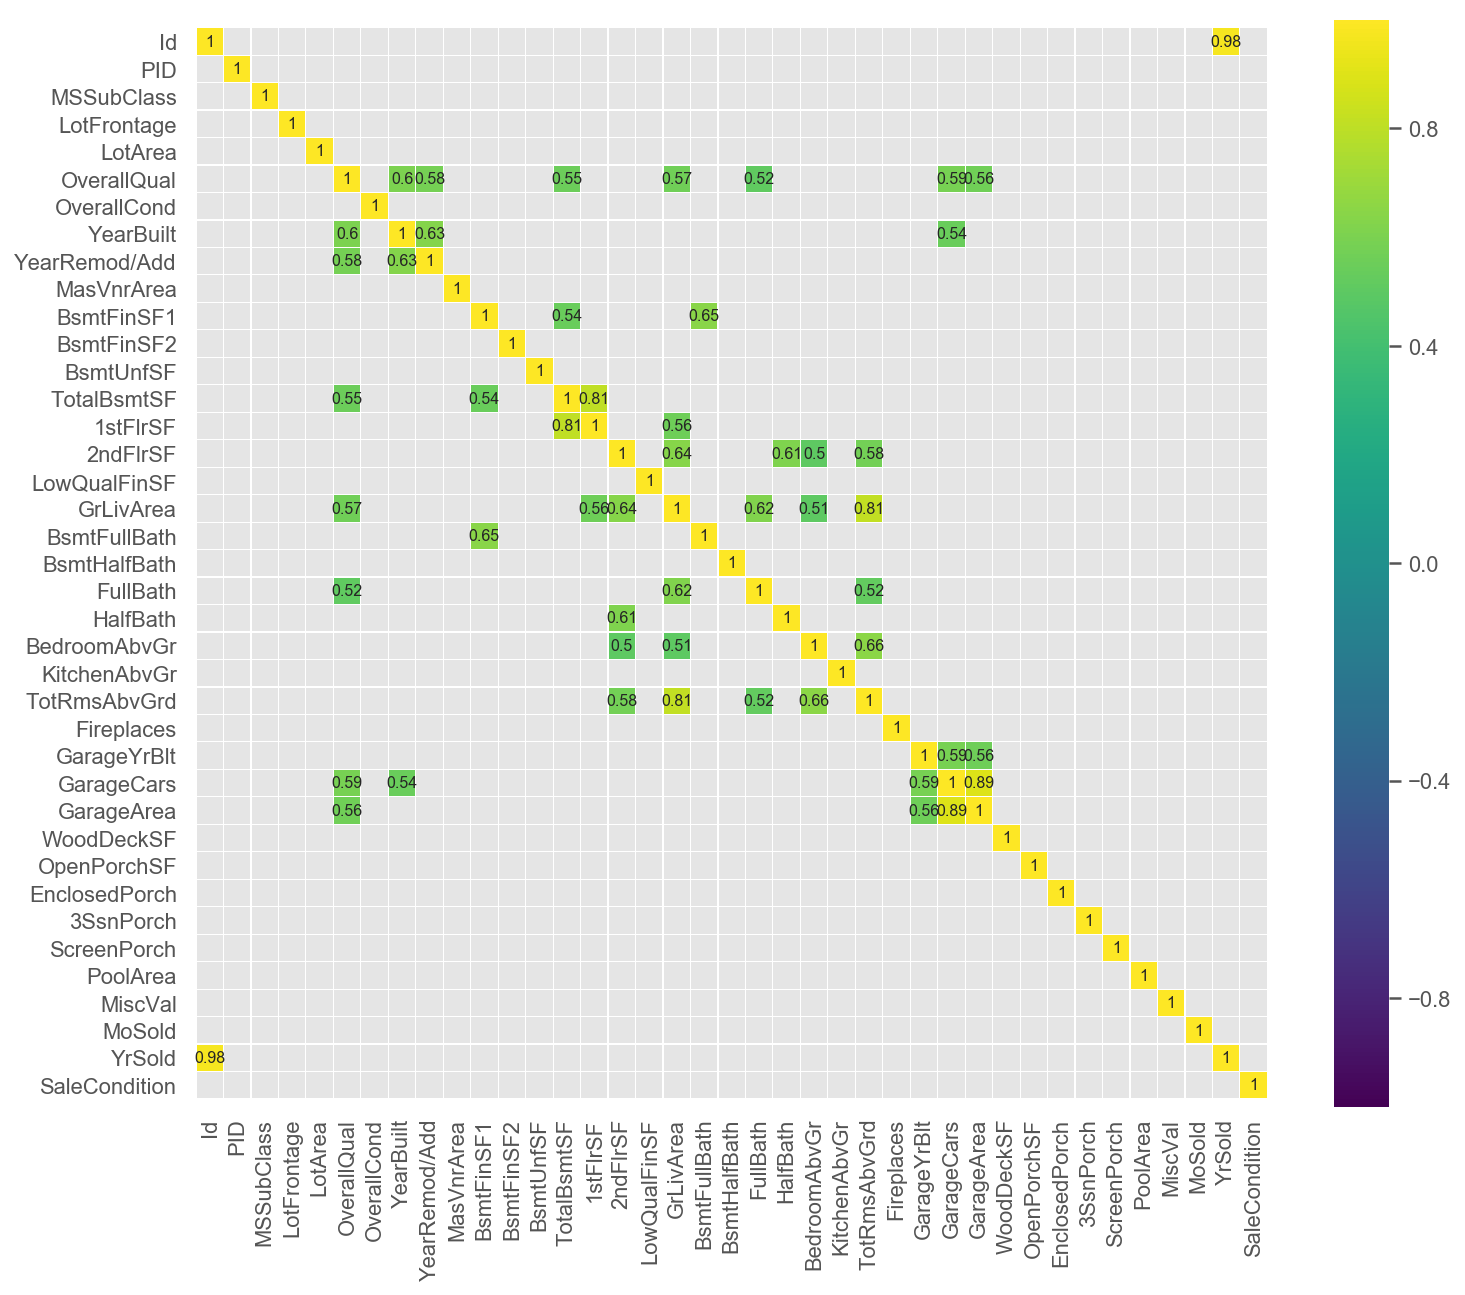

In [145]:
corr = train_df.drop('SalePrice', axis=1).corr().abs() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Finding Correlation with the target (SaleCondition after dummification)


<font color='green'> Sale Condition: We will be trying to predict. While there numerous classes here, you will be predicting whether a sale is abnormal (Abnorml -- Abnormal Sale - trade, foreclosure, short sale) or not an abnormal sale. </font>

In [146]:
set(df1_SCdummy.SaleCondition)


{0, 1}

In [147]:
dd1=df1_SCdummy.corr().abs()['SaleCondition'][:-1]
dd1[abs(dd1) > 0.5].sort_values(ascending=False)

SaleCondition    1.0
Name: SaleCondition, dtype: float64

## <font color='green'>Test Set</font>


In [148]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
Id               879 non-null int64
PID              879 non-null int64
MSSubClass       879 non-null int64
MSZoning         879 non-null object
LotFrontage      879 non-null float64
LotArea          879 non-null int64
Street           879 non-null object
Alley            879 non-null object
LotShape         879 non-null object
LandContour      879 non-null object
Utilities        879 non-null object
LotConfig        879 non-null object
LandSlope        879 non-null object
Neighborhood     879 non-null object
Condition1       879 non-null object
Condition2       879 non-null object
BldgType         879 non-null object
HouseStyle       879 non-null object
OverallQual      879 non-null int64
OverallCond      879 non-null int64
YearBuilt        879 non-null int64
YearRemod/Add    879 non-null int64
RoofStyle        879 non-null object
RoofMatl         879 non-null object
Exterior1st   

In [36]:
#categorical & numerical features test set
categorical_test = [var for var in test_df.columns if test_df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical_test)))
numerical_test = [var for var in test_df.columns if test_df[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical_test)))

There are 42 categorical variables
There are 38 numerical variables


In [37]:
discrete_test = []
for var in numerical_test:
    if len(test_df[var].unique())<20:
        print(var, ' values: ', test_df[var].unique())
        discrete_test.append(var)
        
print('There are {} discrete variables'.format(len(discrete_test)))

MSSubClass  values:  [190  90  60  30  20 160 120  70  80  50  85  45  75 180  40]
OverallQual  values:  [ 6  5  7  4  8  3 10  9  2]
OverallCond  values:  [8 4 5 6 7 9 3 2 1]
LowQualFinSF  values:  [  0 360 431 481  80 392 232 420]
BsmtFullBath  values:  [0. 1. 2.]
BsmtHalfBath  values:  [0. 1.]
FullBath  values:  [2 1 4 3 0]
HalfBath  values:  [0 1 2]
BedroomAbvGr  values:  [4 6 3 2 1 5 0]
KitchenAbvGr  values:  [2 1 0 3]
TotRmsAbvGrd  values:  [ 9 10  7  5  6  3  8  4 11 12]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [1. 2. 4. 0. 3.]
3SsnPorch  values:  [  0 180 130 225 219 360 238  23 174 196 216 320]
PoolArea  values:  [  0 144 555 512 444]
MoSold  values:  [ 4  8  9  7  6  5 10  1  2 11 12  3]
YrSold  values:  [2006 2007 2009 2010 2008]
There are 17 discrete variables


In [38]:
#perecntage of nan values per feature
for var in test_df.columns:
    if test_df[var].isnull().sum()>0:
        print(var, test_df[var].isnull().mean())

LotFrontage 0.1820250284414107
Alley 0.9340159271899886
MasVnrType 0.0011376564277588168
MasVnrArea 0.0011376564277588168
BsmtQual 0.02844141069397042
BsmtCond 0.02844141069397042
BsmtExposure 0.02844141069397042
BsmtFinType1 0.02844141069397042
BsmtFinType2 0.02844141069397042
Electrical 0.0011376564277588168
FireplaceQu 0.4800910125142207
GarageType 0.05005688282138794
GarageYrBlt 0.051194539249146756
GarageFinish 0.051194539249146756
GarageQual 0.051194539249146756
GarageCond 0.051194539249146756
PoolQC 0.9954493742889647
Fence 0.8043230944254836
MiscFeature 0.9533560864618885


In [39]:
# PoolQC , MiscFeature , fence have lots of nan ->>

In [149]:
test_df.columns[test_df.isna().any()].tolist()  #list of features which have nan values

[]

### Handling Nan values -test set


In [150]:
m=test_df.columns[test_df.isna().any()].tolist()

for x in m:
    print(x,"," , test_df[x].dtype)

In [151]:


test_df.Alley=test_df.Alley.fillna('no-access') 
test_df.MasVnrType=test_df.MasVnrType.fillna('None')
test_df.BsmtQual=test_df.BsmtQual.fillna('no-Basement') 
test_df.BsmtCond=test_df.BsmtCond.fillna('no-Basement') 
test_df.BsmtExposure=test_df.BsmtExposure.fillna('no-Basement') 
test_df.BsmtFinType1=test_df.BsmtFinType1.fillna('no-Basement') 
test_df.BsmtFinType2=test_df.BsmtFinType2.fillna('no-Basement') 
test_df.Electrical=test_df.Electrical.fillna('na') 
test_df.FireplaceQu=test_df.FireplaceQu.fillna('no-Fireplace') 
test_df.GarageType=test_df.GarageType.fillna('no-Garage') 
test_df.GarageFinish=test_df.GarageFinish.fillna('no-Garage') 
test_df.GarageQual=test_df.GarageQual.fillna('no-Garage')
test_df.GarageCond=test_df.GarageCond.fillna('no-Garage')
test_df.PoolQC=test_df.PoolQC.fillna('no-pool')
test_df.Fence=test_df.Fence.fillna('no-Fence')
test_df.MiscFeature=test_df.MiscFeature.fillna('None')


In [152]:
m=test_df.columns[test_df.isna().any()].tolist()

for x in m:
    print(x,"," , test_df[x].dtype)

In [153]:
test_df.LotFrontage=test_df.LotFrontage.fillna(0) #numerical var with nan --> fill it with 0
test_df.MasVnrArea=test_df.MasVnrArea.fillna(0) #numerical var with nan --> fill it with 0
test_df.GarageYrBlt=test_df.GarageYrBlt.fillna(0) #numerical var with nan --> fill it with 0


In [154]:
test_df.columns[test_df.isna().any()].tolist()  #list of features which have nan values

[]

### 1. Numerical features-test

In [155]:
discrete_test = []
for var in numerical_test:
    if len(test_df[var].unique())<20:
        print(var, ' values: ', test_df[var].unique())
        discrete_test.append(var)
        
print('There are {} discrete variables'.format(len(discrete_test)))

MSSubClass  values:  [190  90  60  30  20 160 120  70  80  50  85  45  75 180  40]
OverallQual  values:  [ 6  5  7  4  8  3 10  9  2]
OverallCond  values:  [8 4 5 6 7 9 3 2 1]
LowQualFinSF  values:  [  0 360 431 481  80 392 232 420]
BsmtFullBath  values:  [0. 1. 2.]
BsmtHalfBath  values:  [0. 1.]
FullBath  values:  [2 1 4 3 0]
HalfBath  values:  [0 1 2]
BedroomAbvGr  values:  [4 6 3 2 1 5 0]
KitchenAbvGr  values:  [2 1 0 3]
TotRmsAbvGrd  values:  [ 9 10  7  5  6  3  8  4 11 12]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [1. 2. 4. 0. 3.]
3SsnPorch  values:  [  0 180 130 225 219 360 238  23 174 196 216 320]
PoolArea  values:  [  0 144 555 512 444]
MoSold  values:  [ 4  8  9  7  6  5 10  1  2 11 12  3]
YrSold  values:  [2006 2007 2009 2010 2008]
There are 17 discrete variables


#### 1.1 Numerical outliers-test

In [156]:
continuous_test = [var for var in numerical_test if var not in discrete_test ]
continuous_test

['Id',
 'PID',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemod/Add',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal']

C:\Users\R.A\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


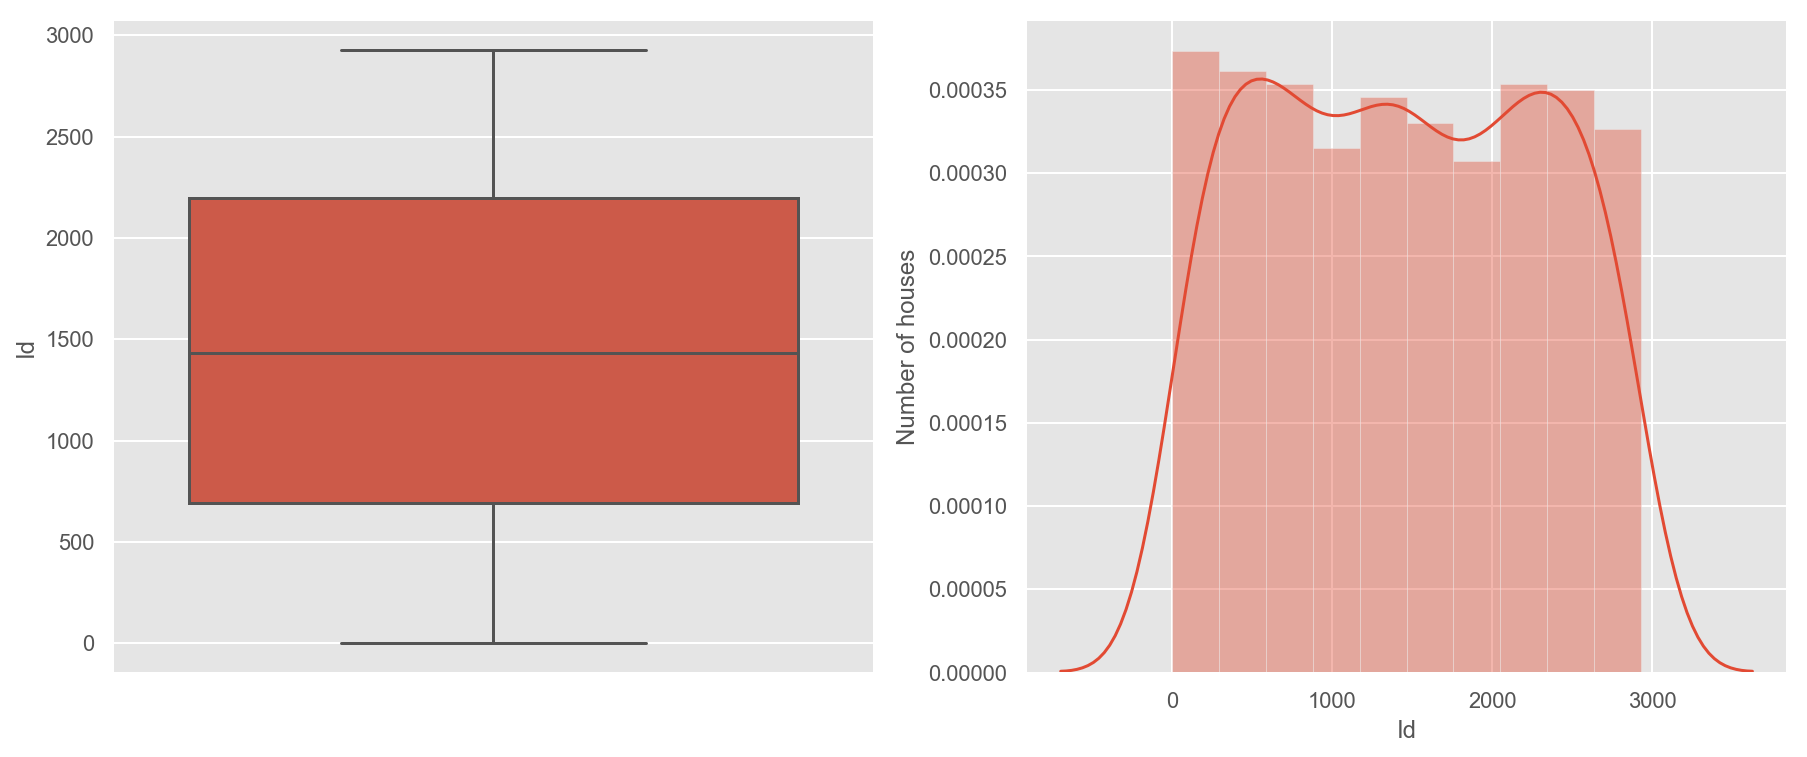

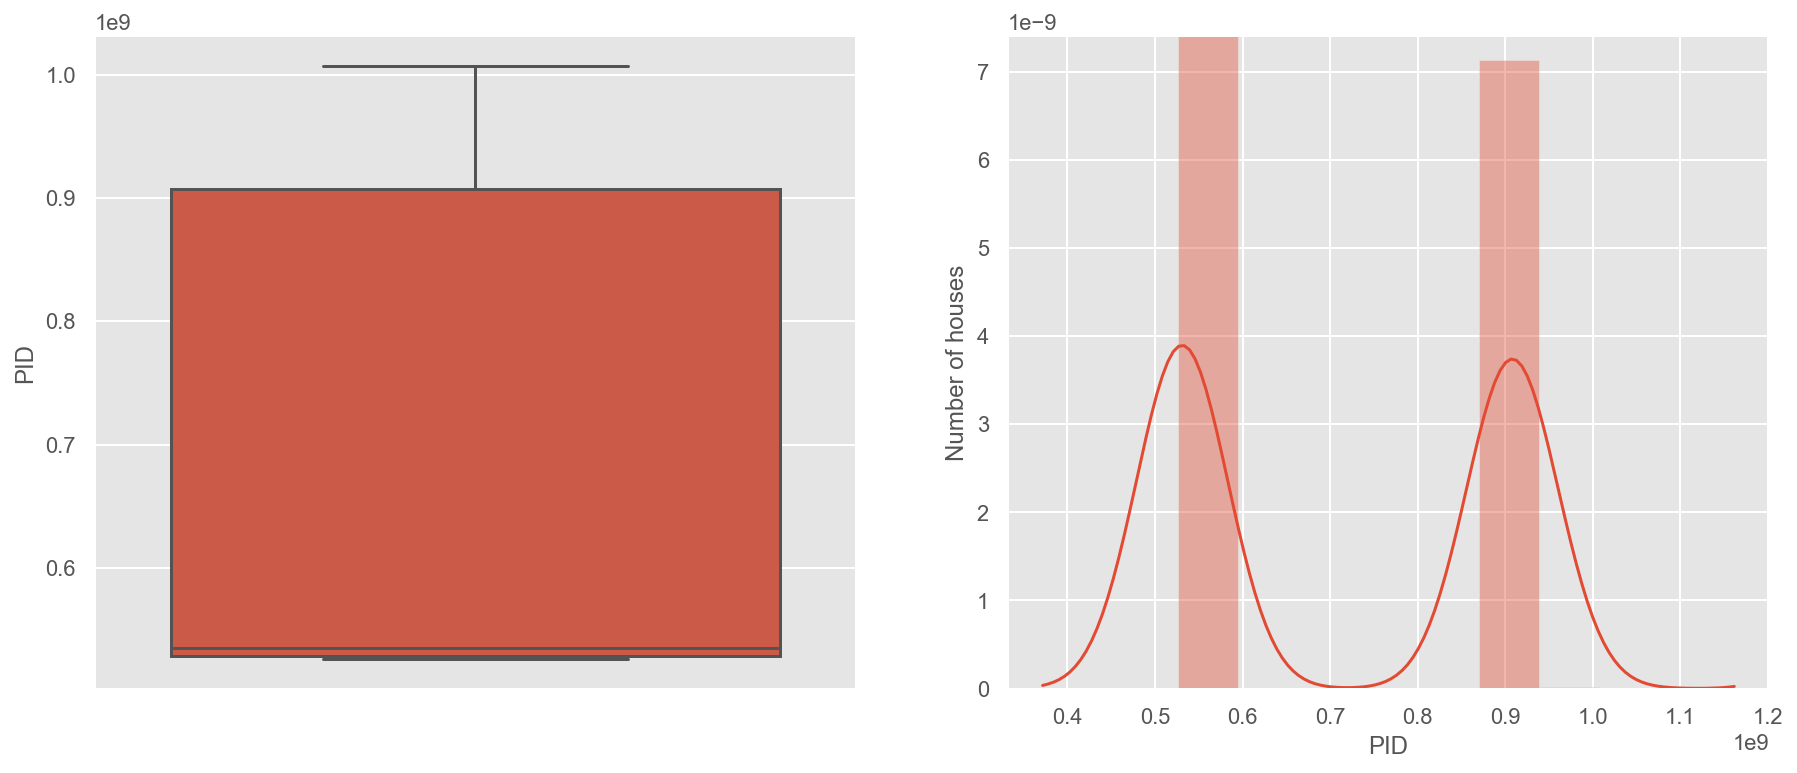

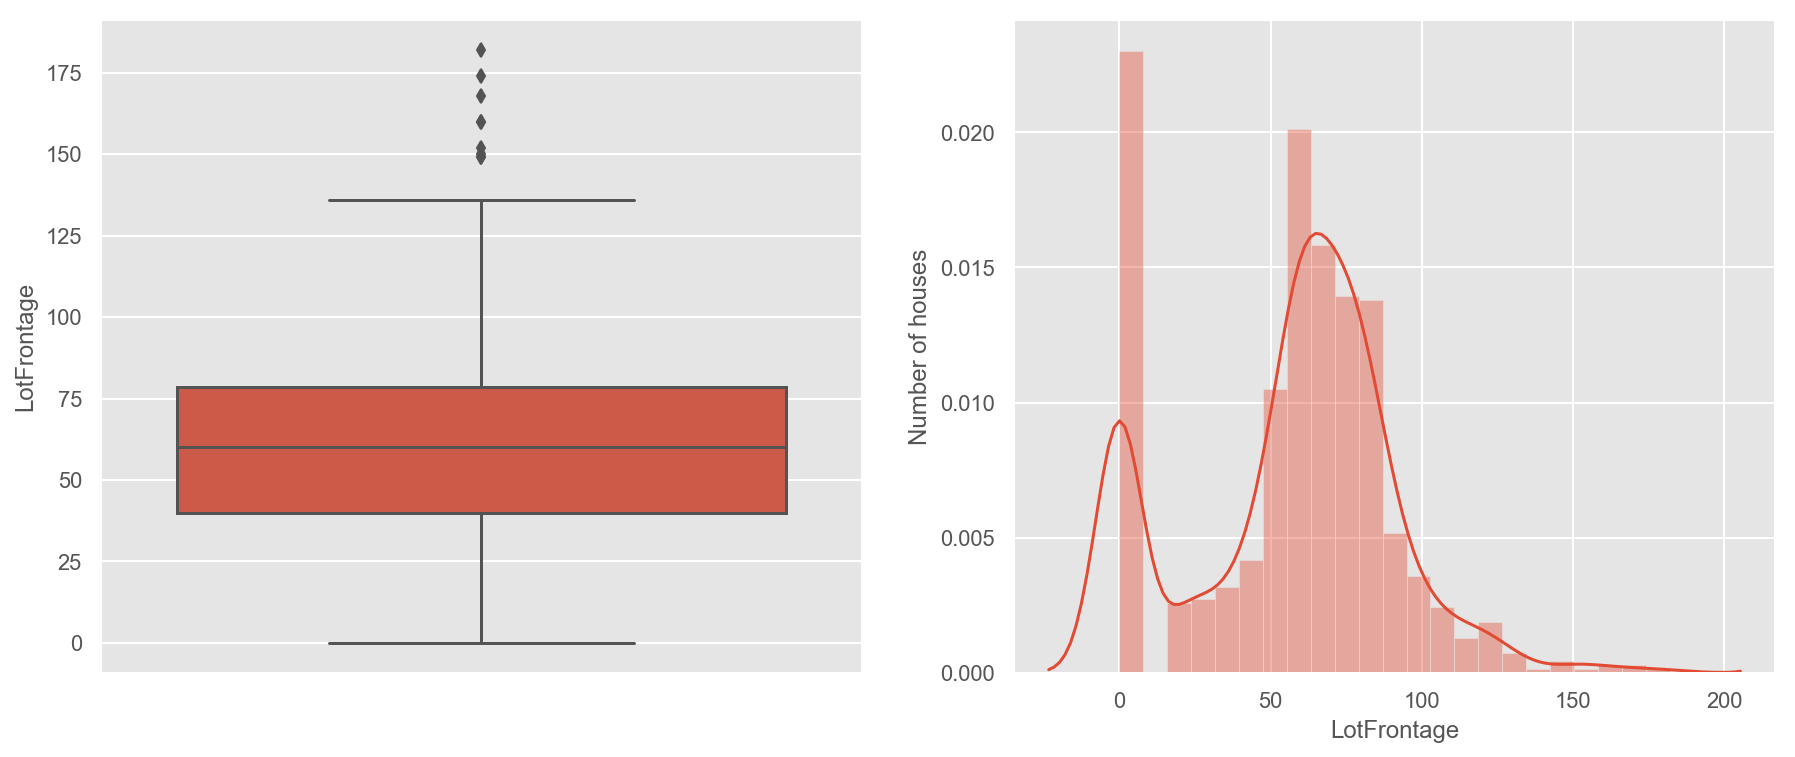

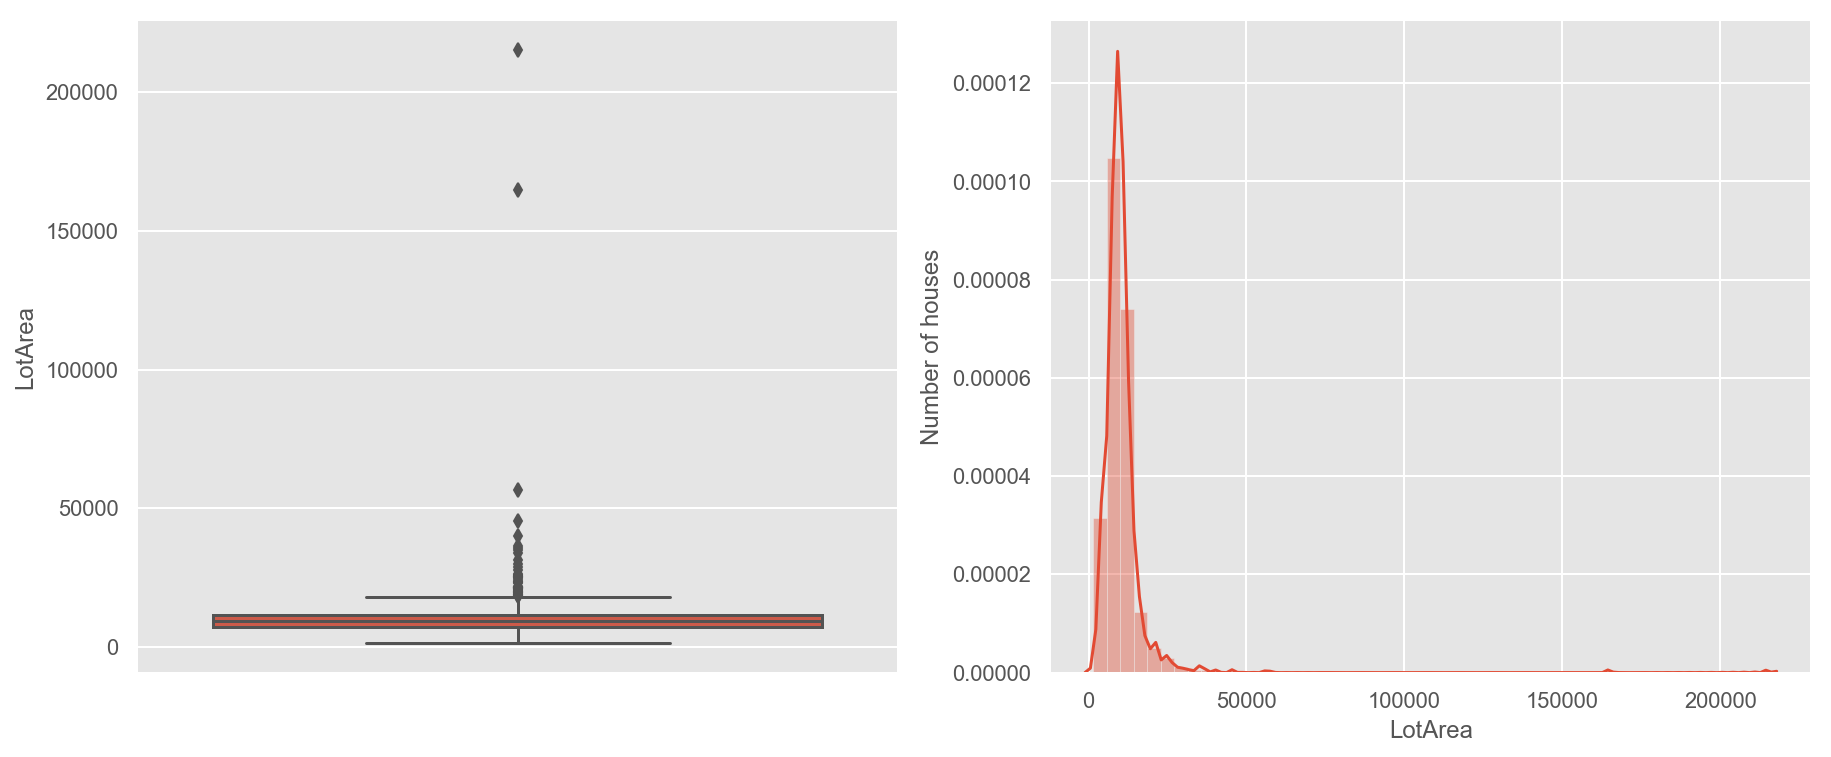

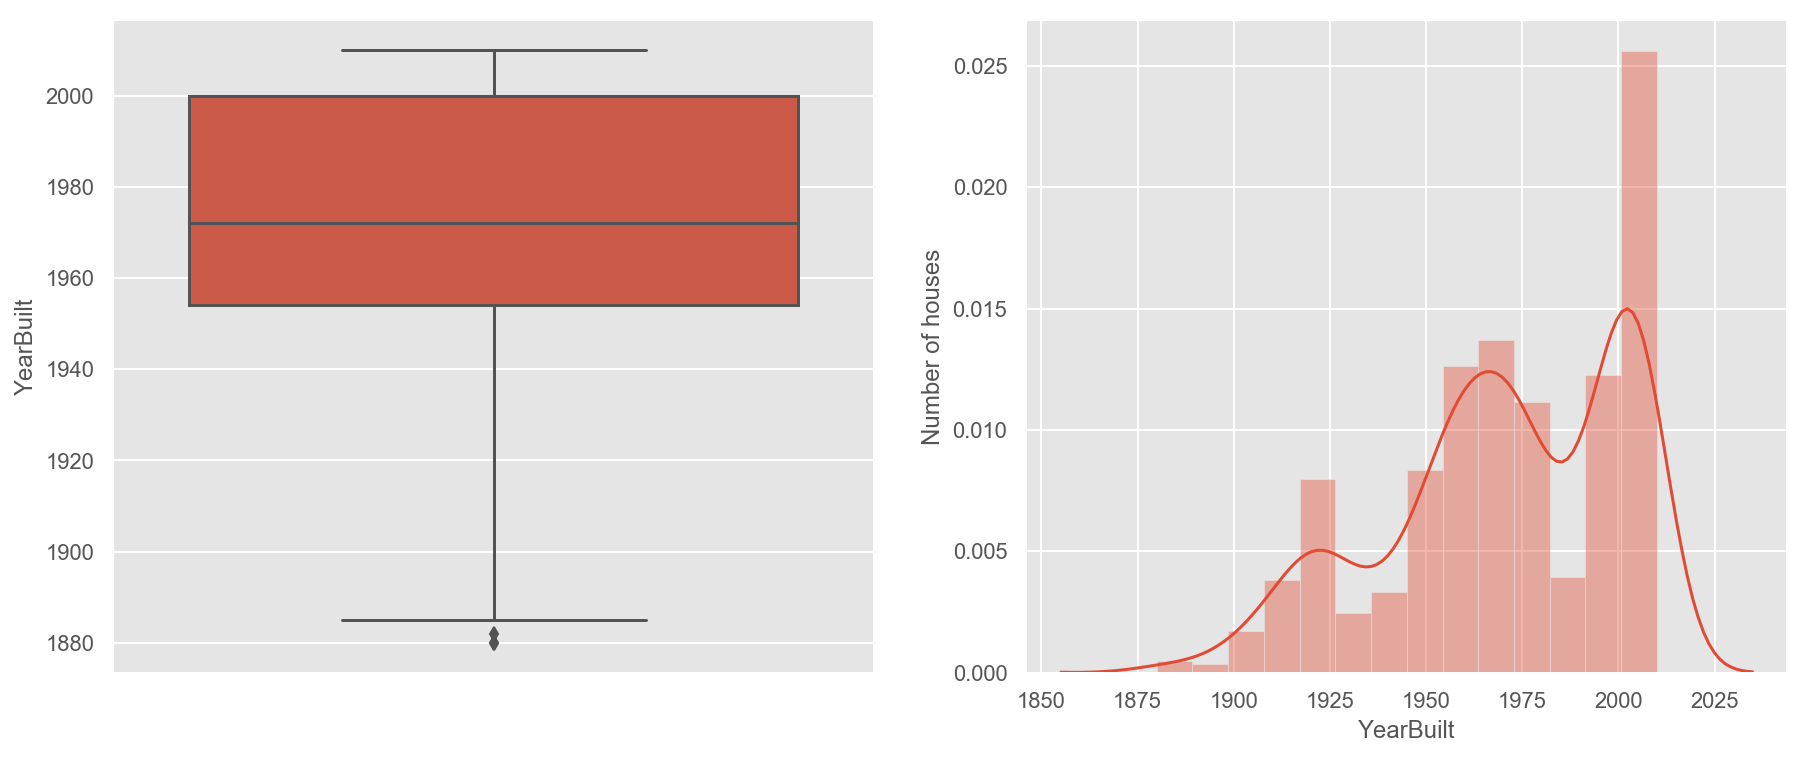

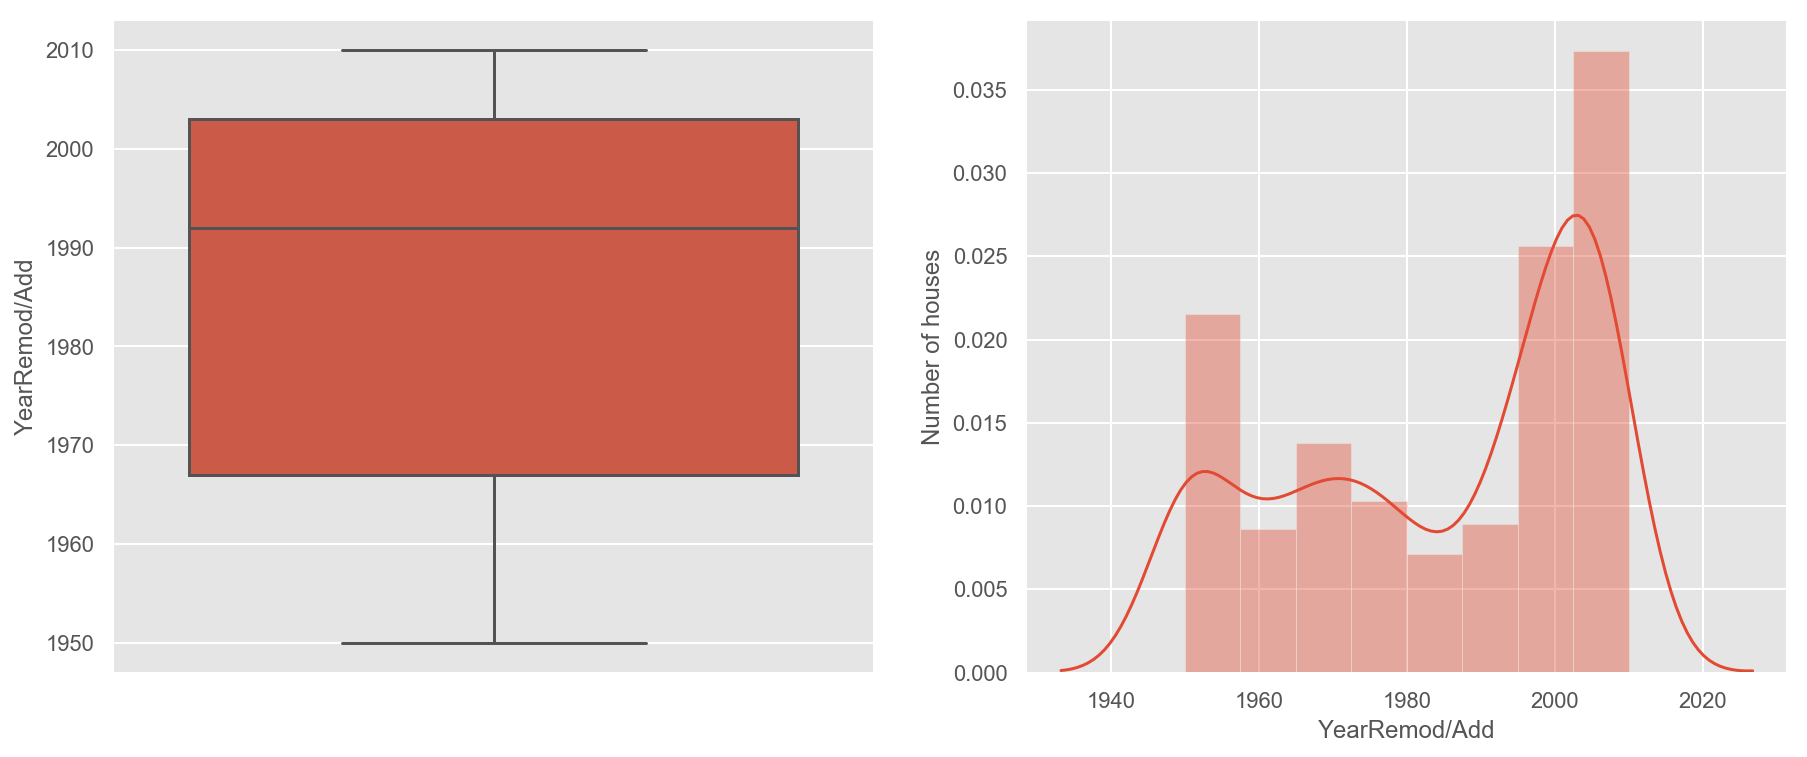

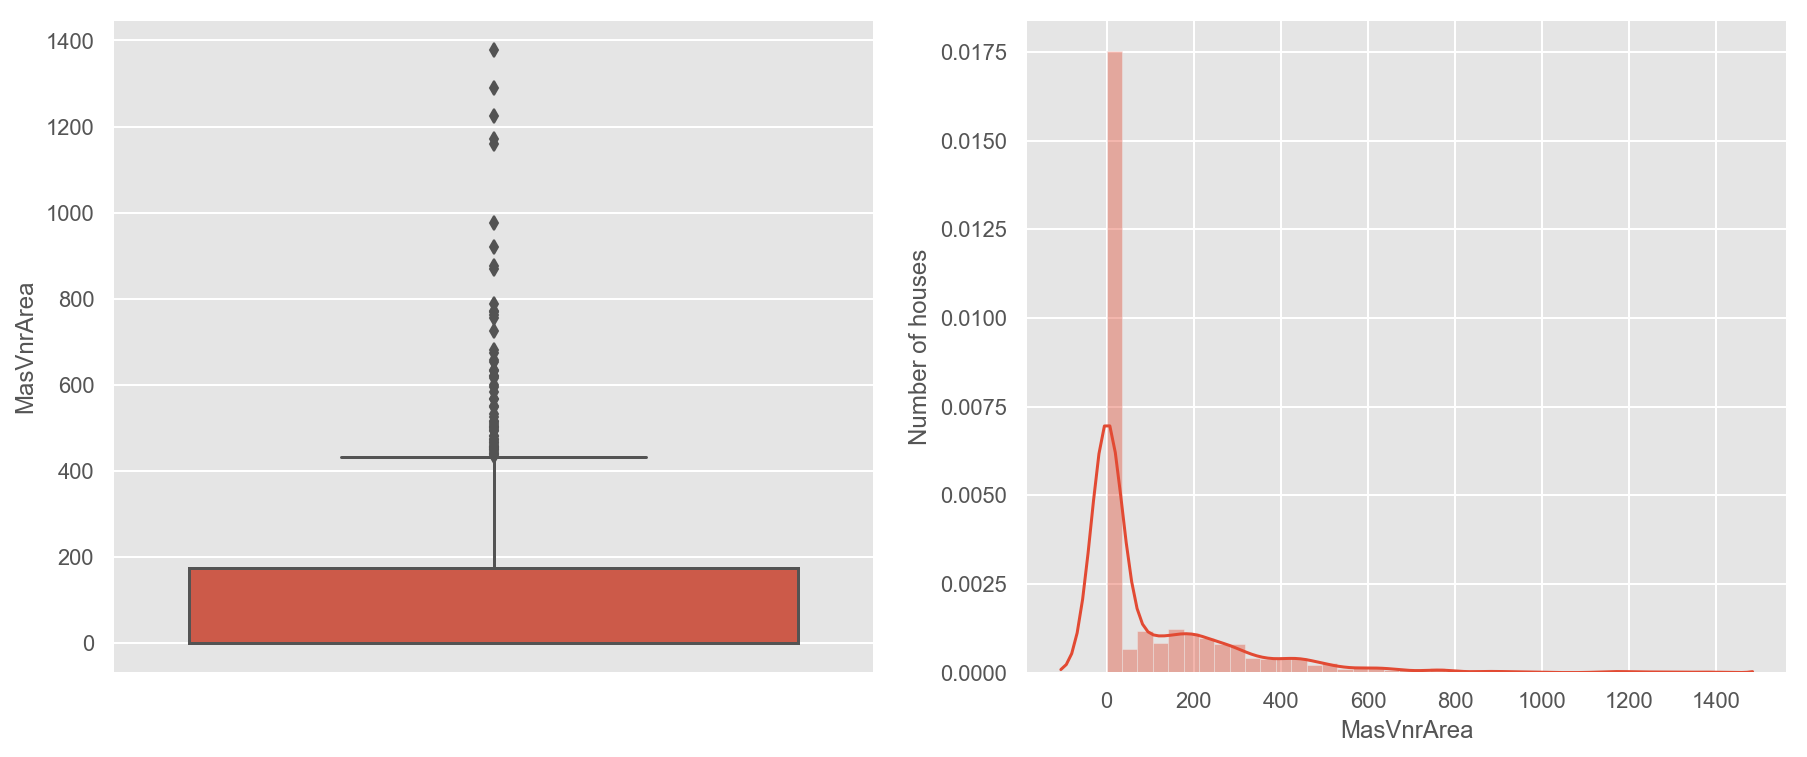

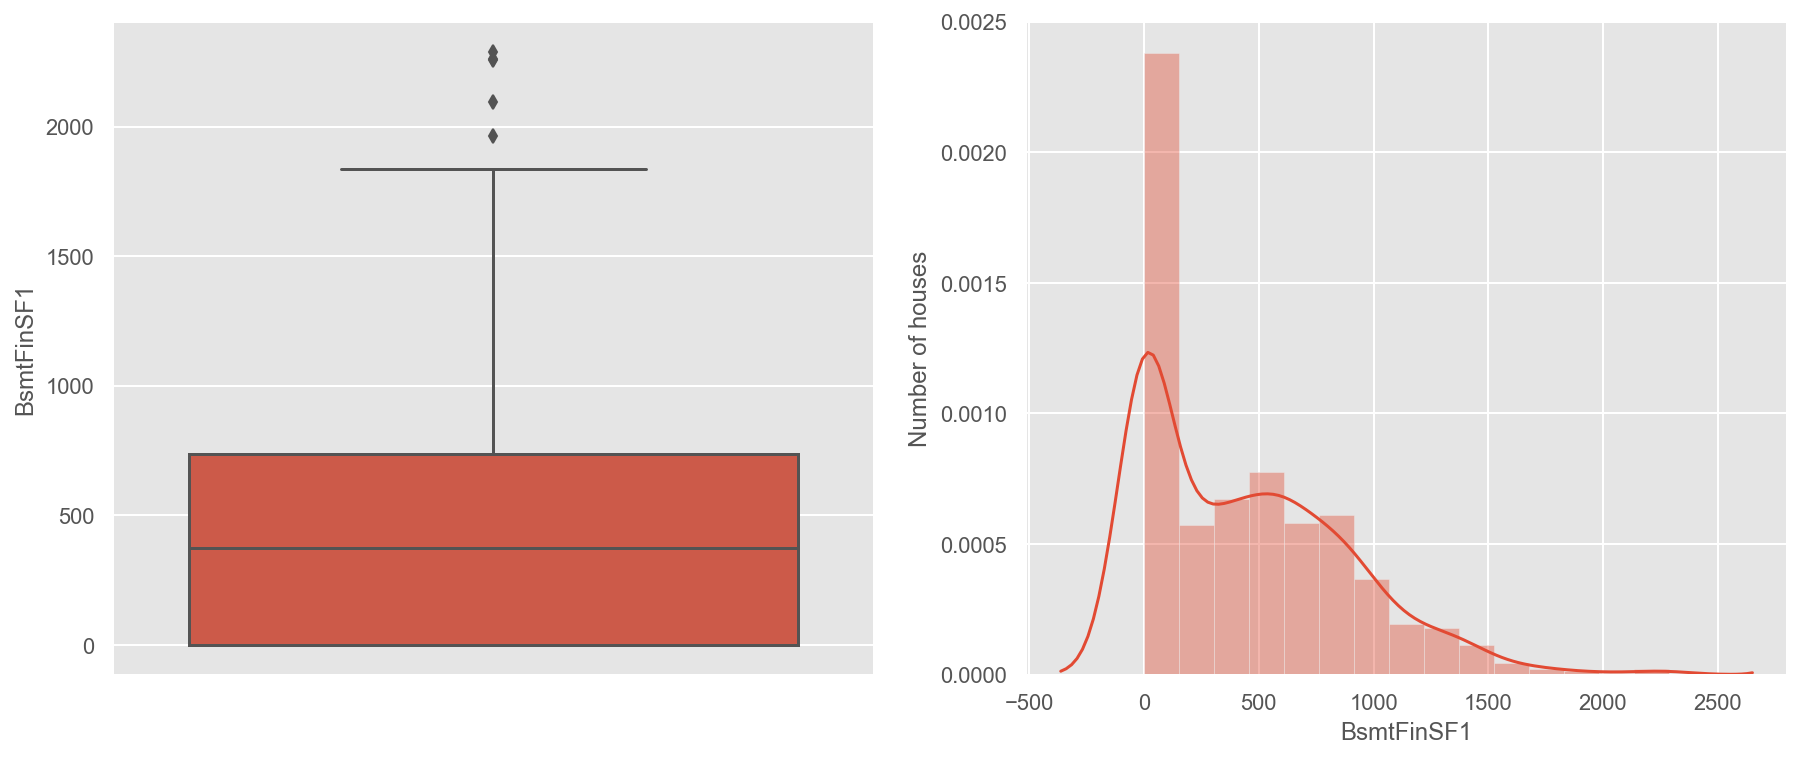

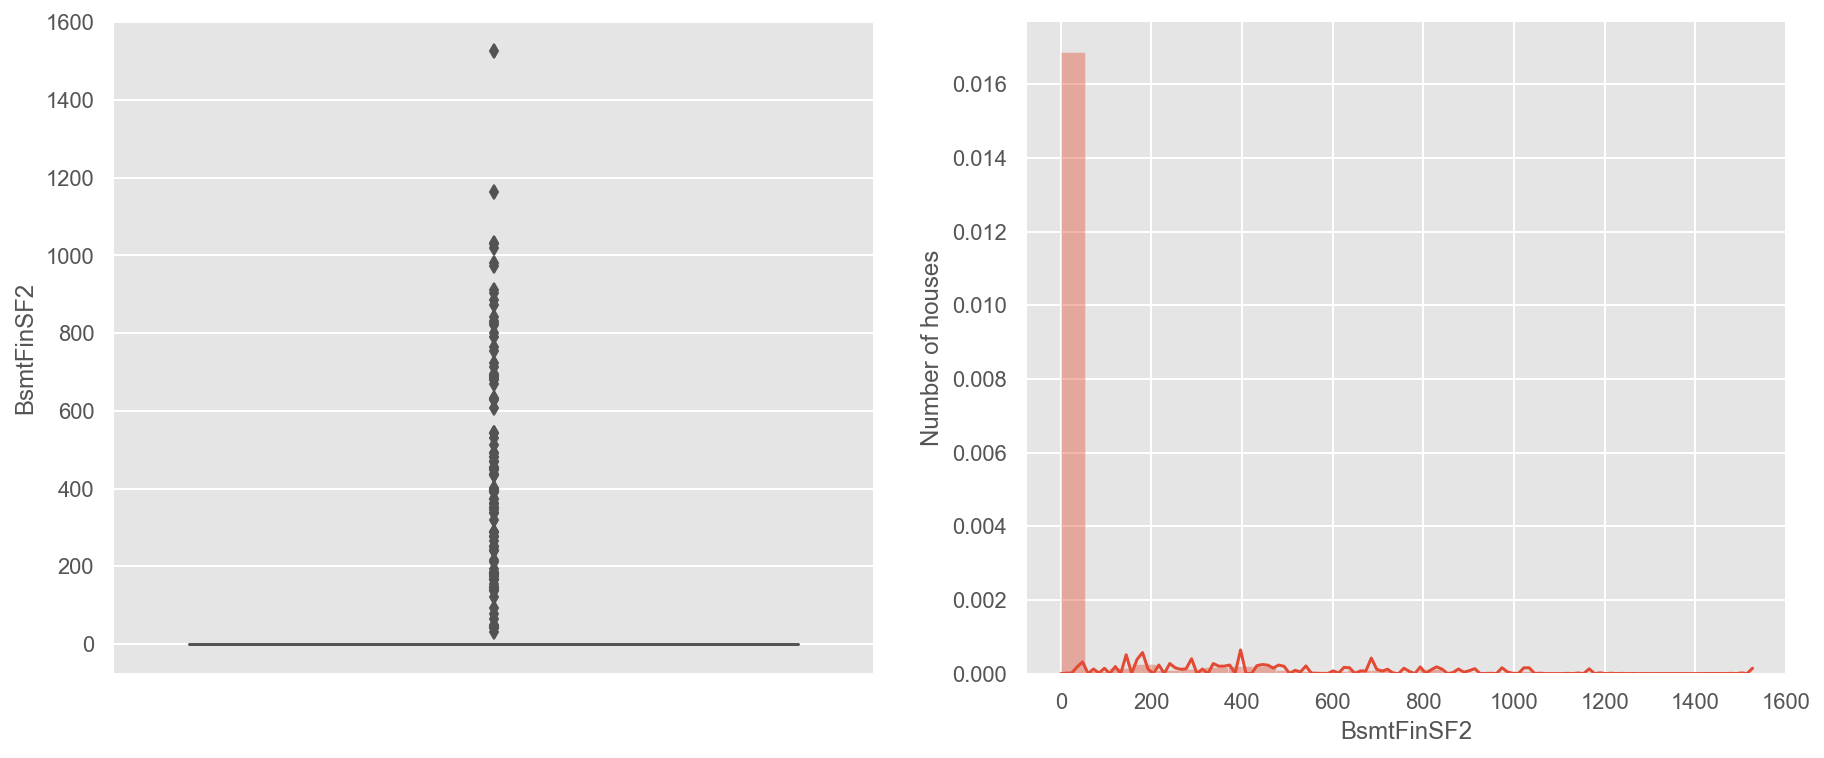

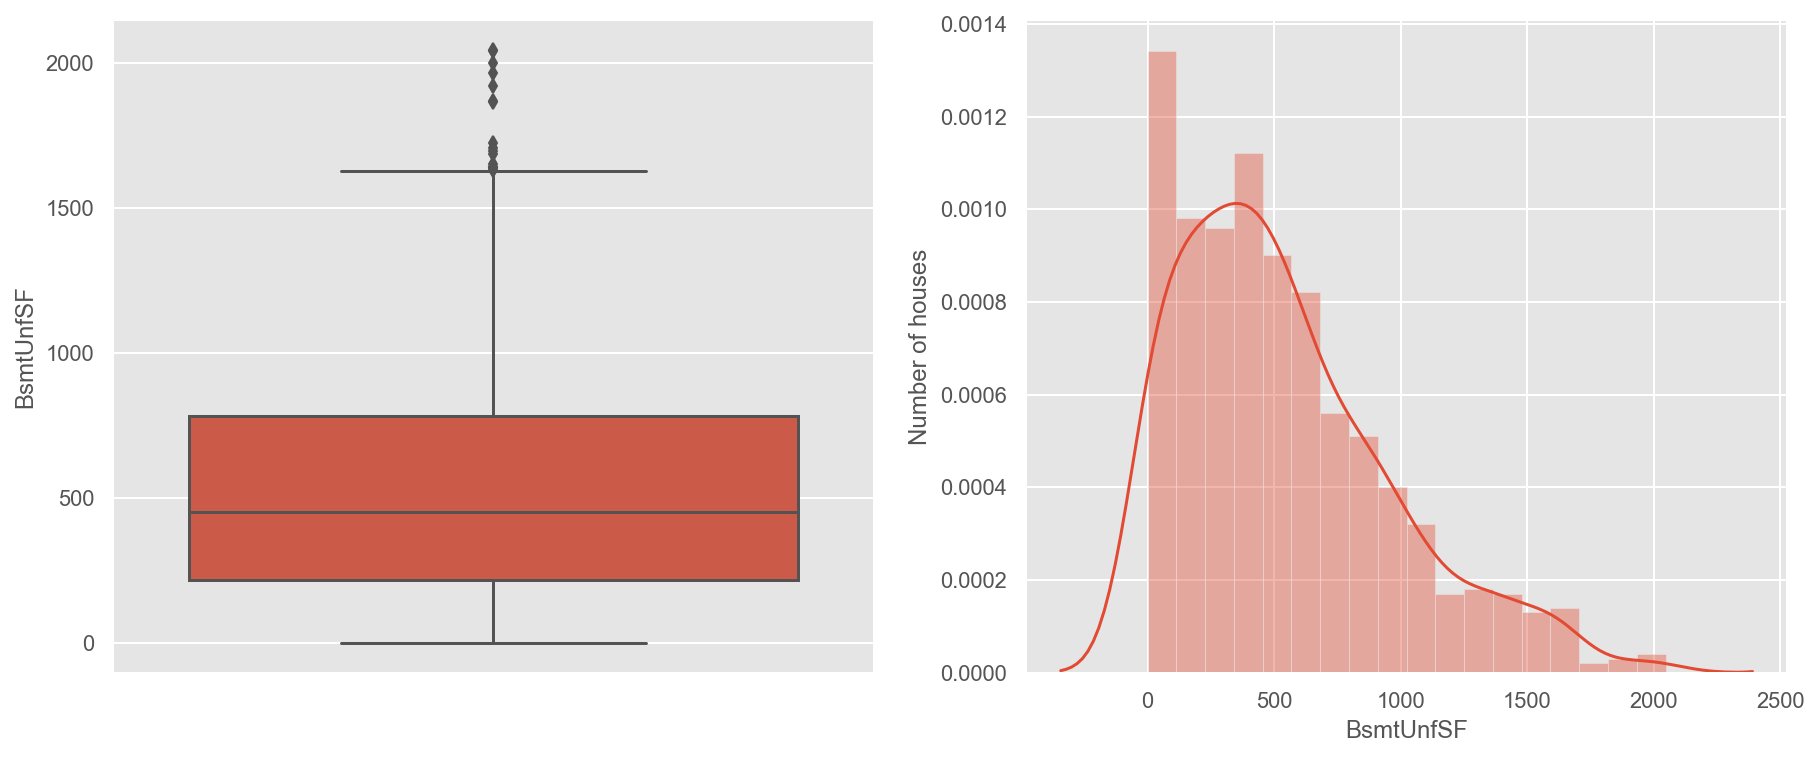

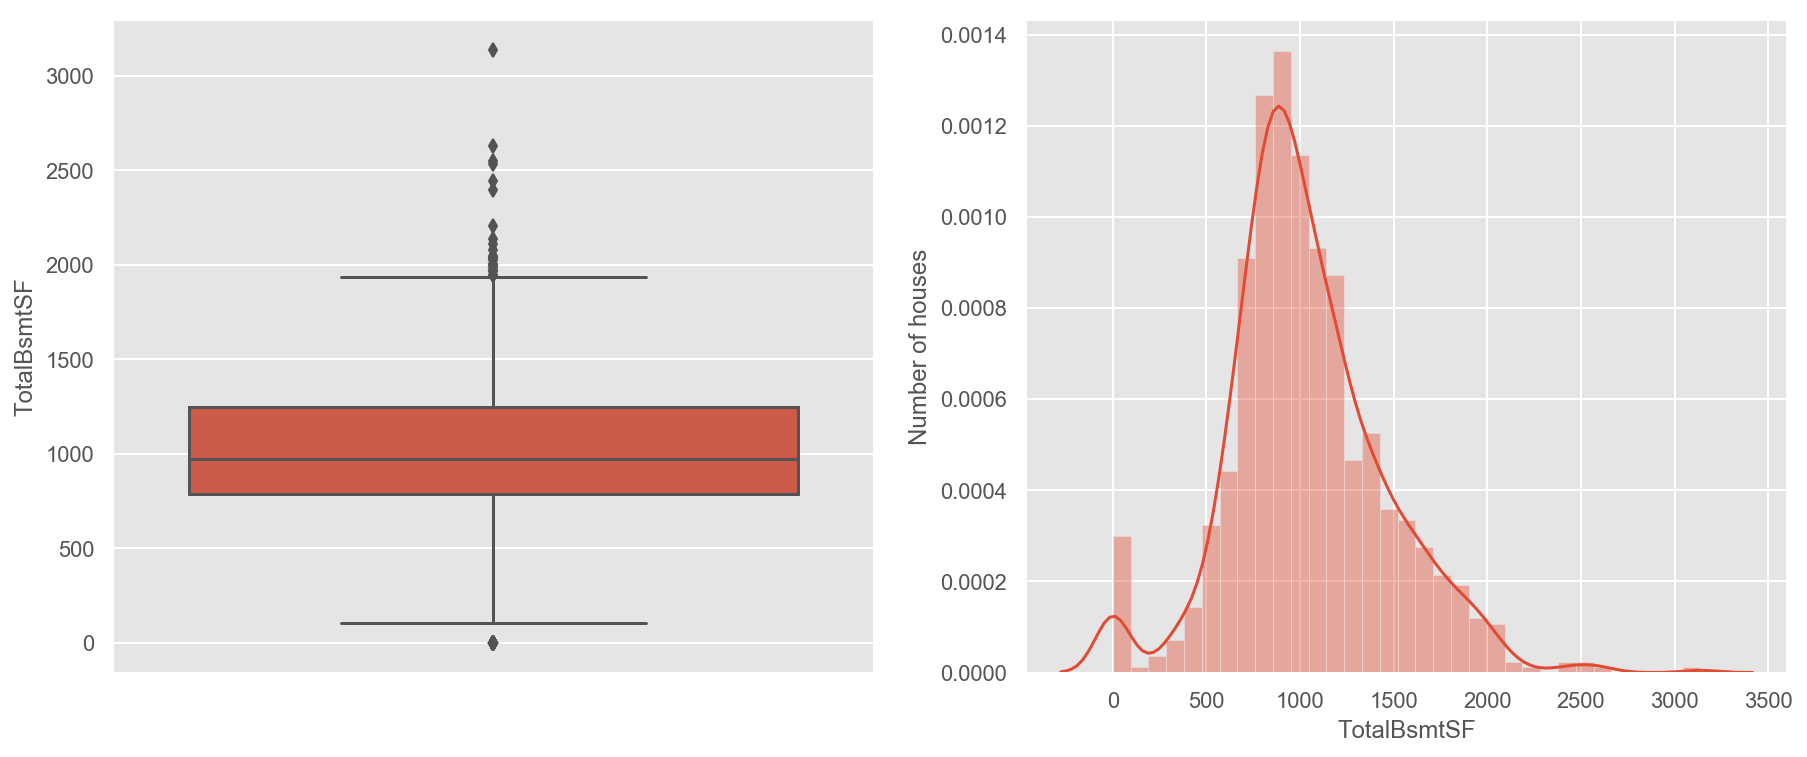

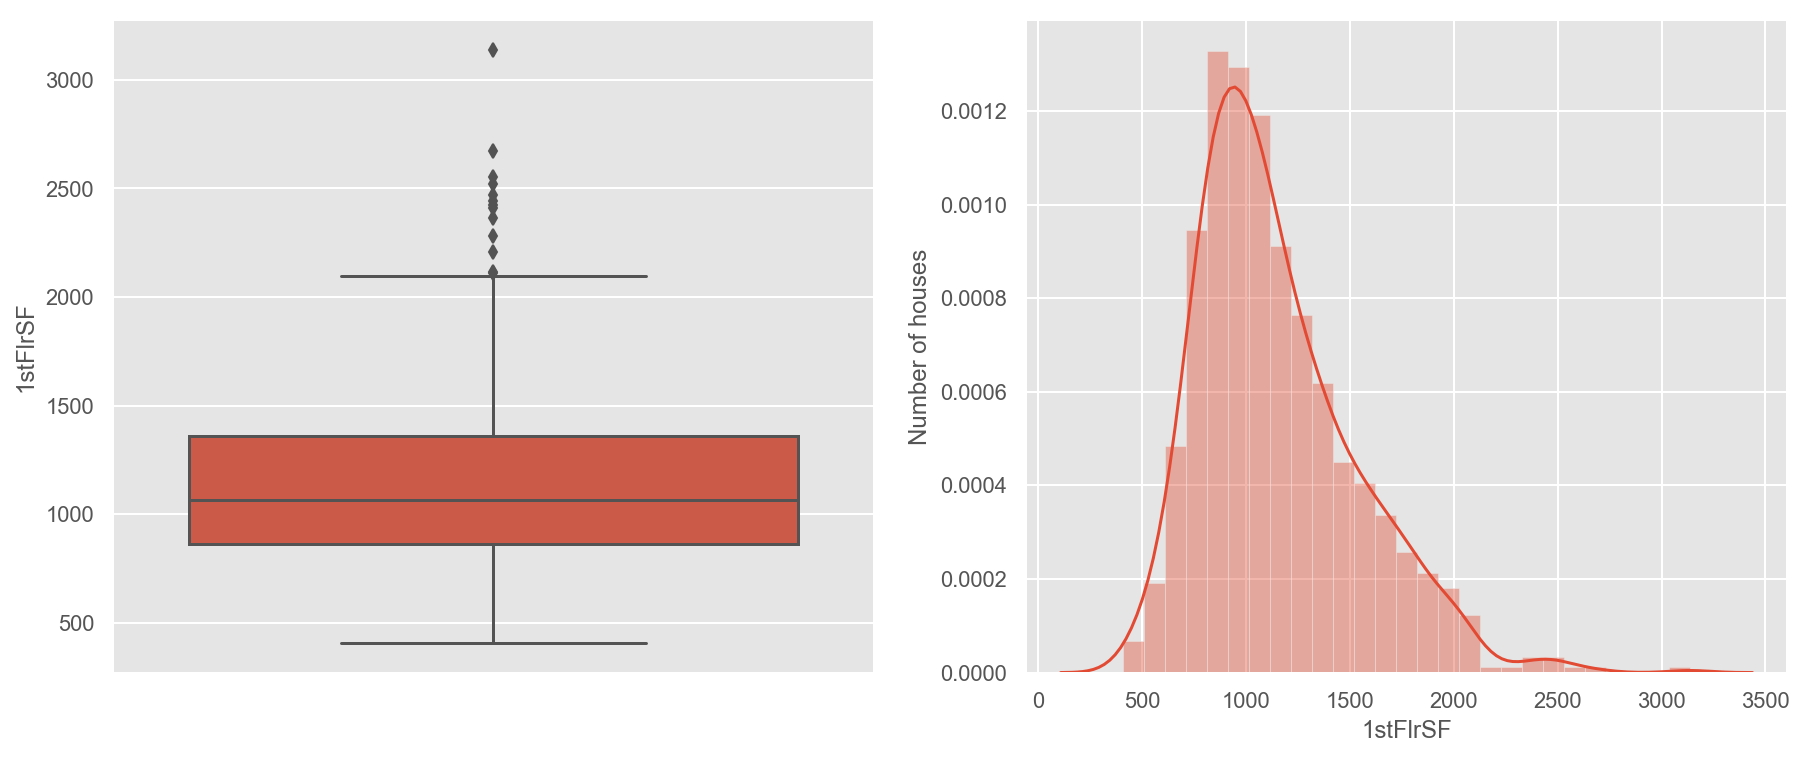

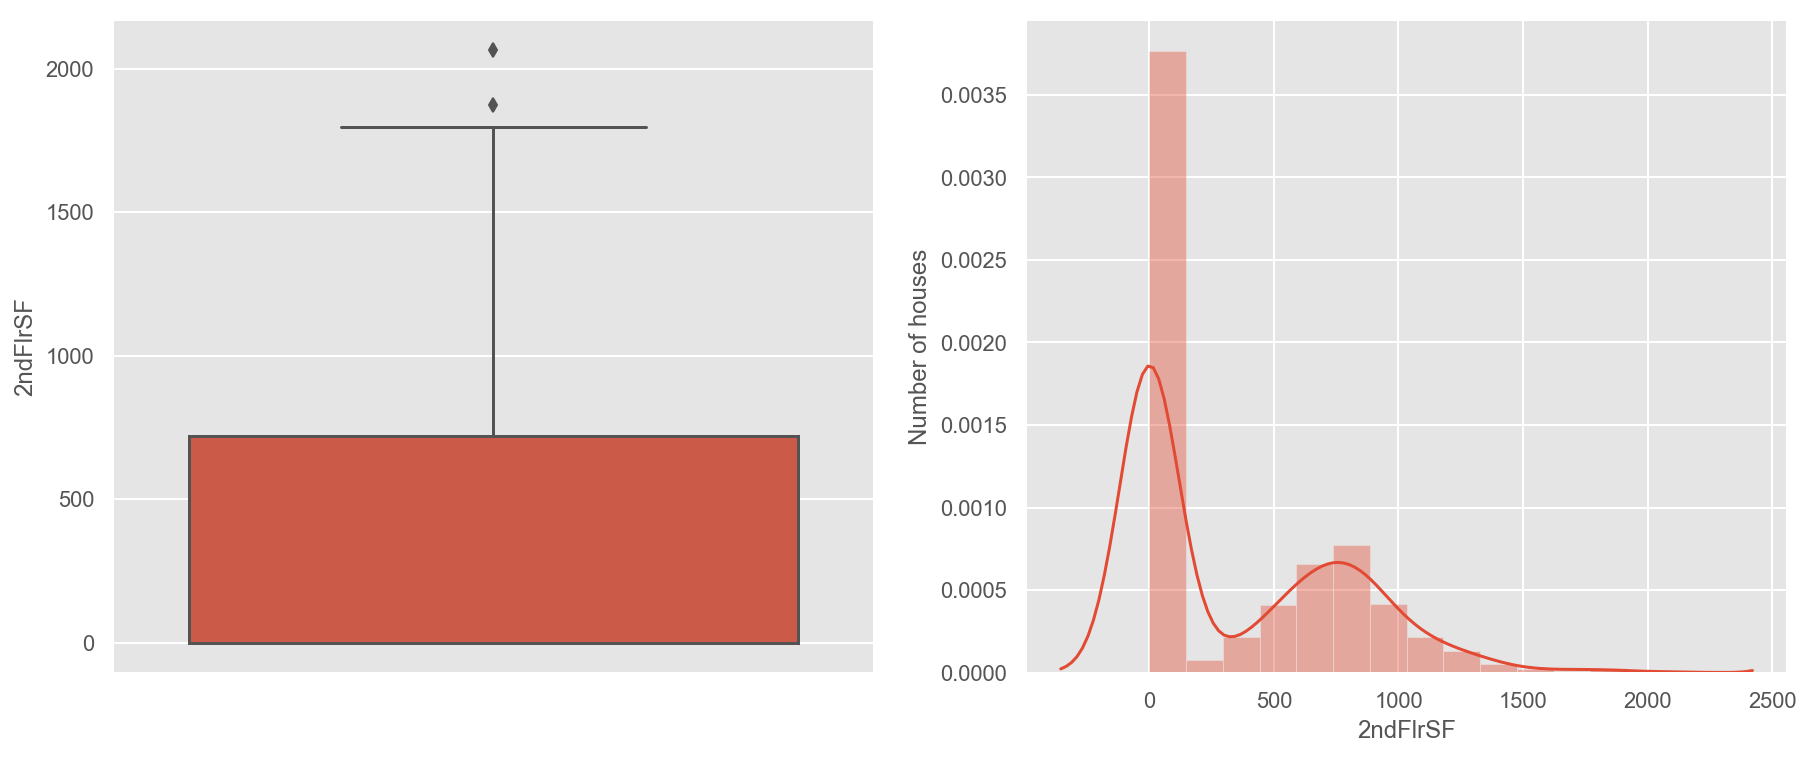

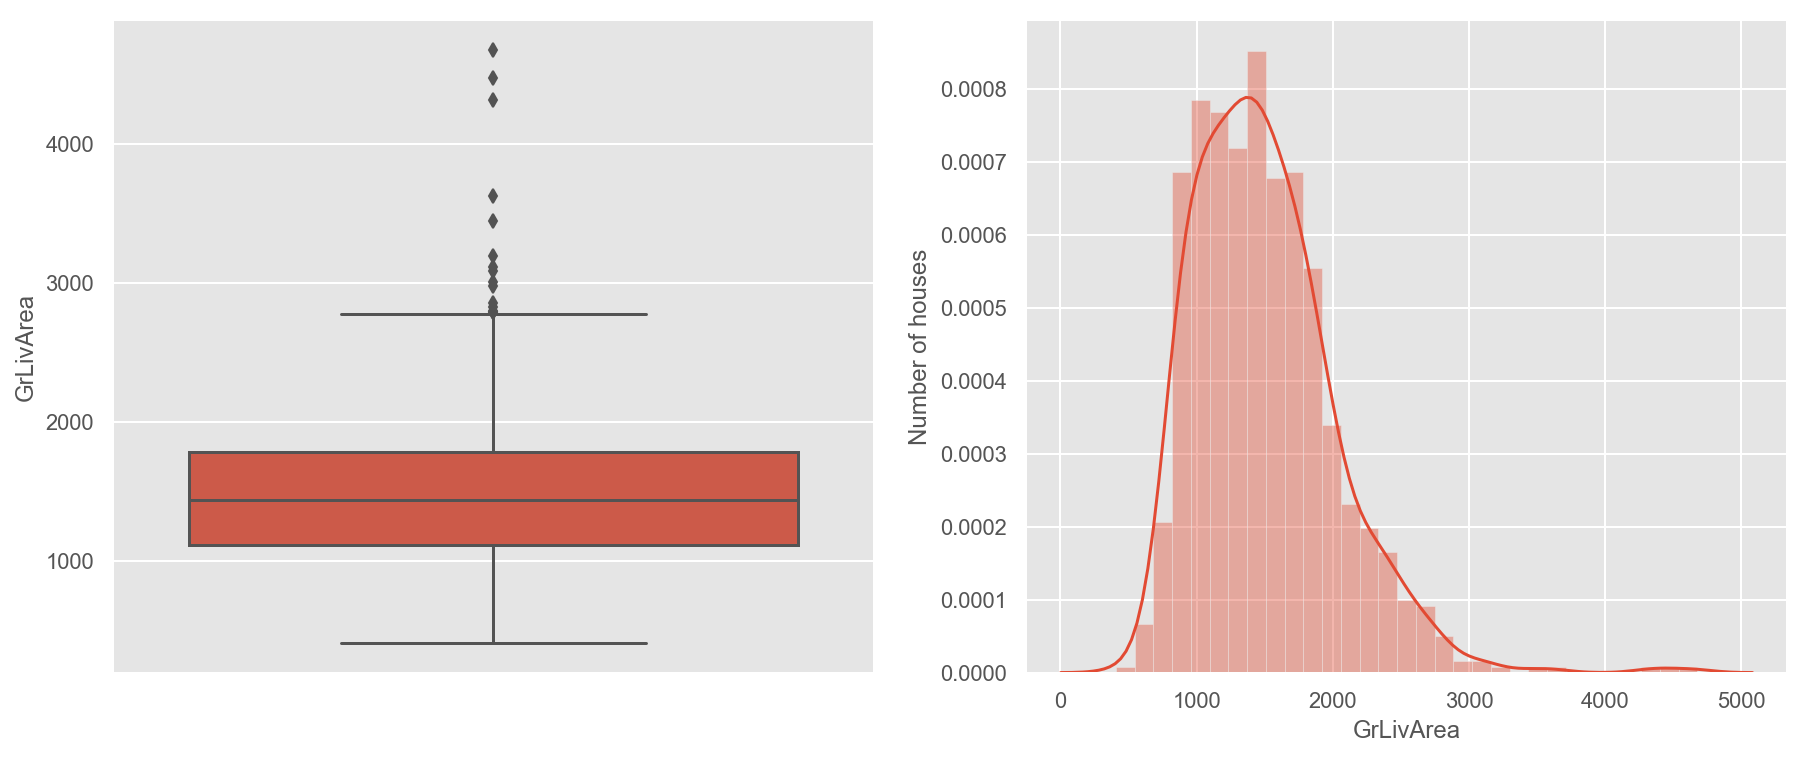

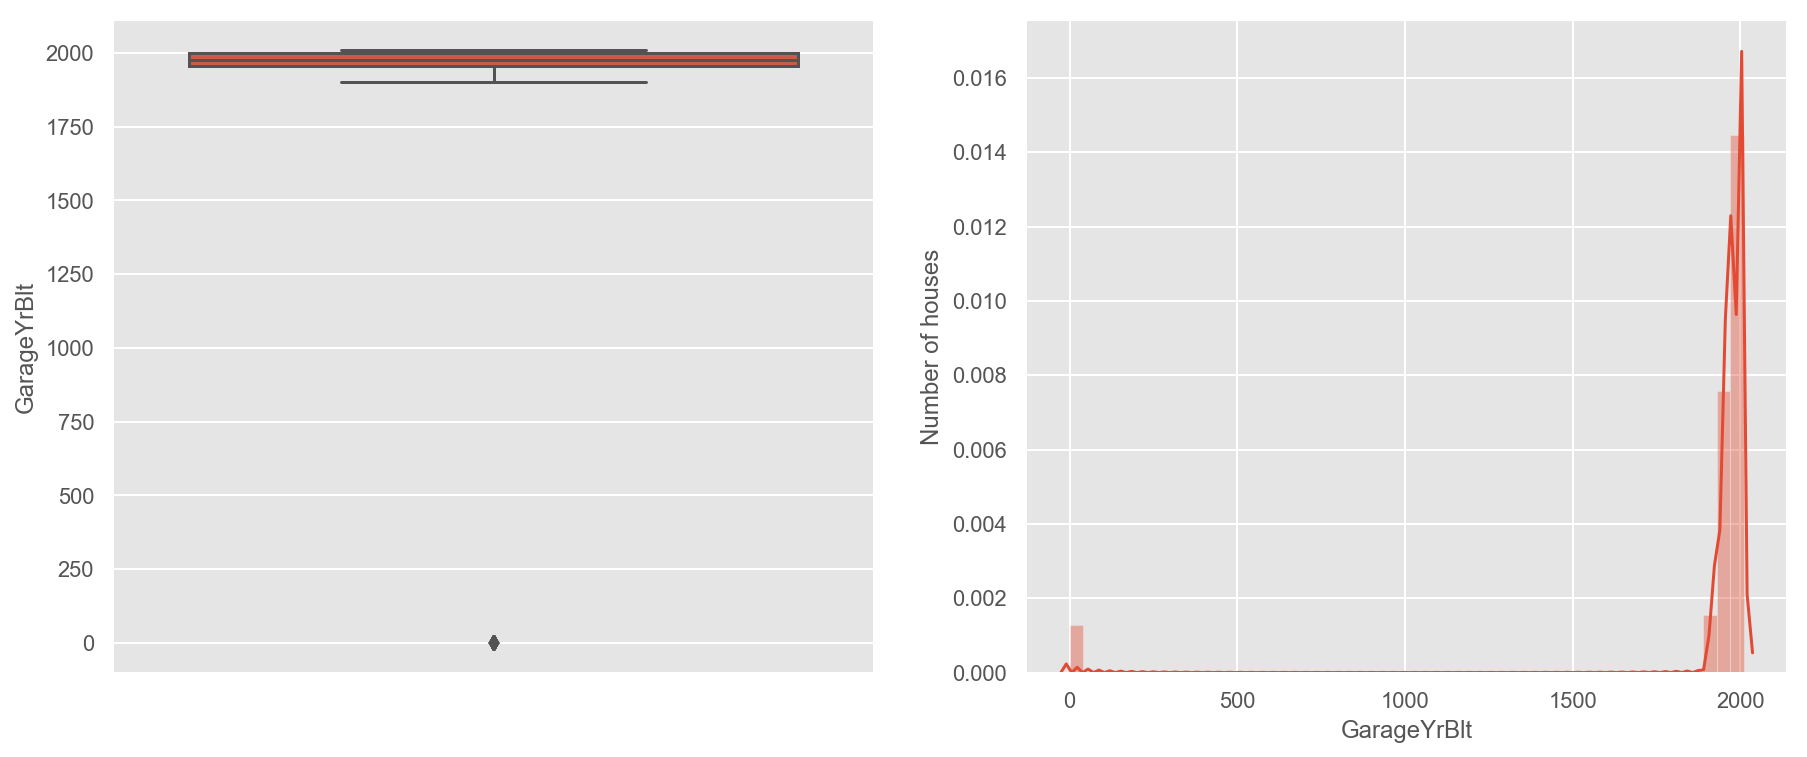

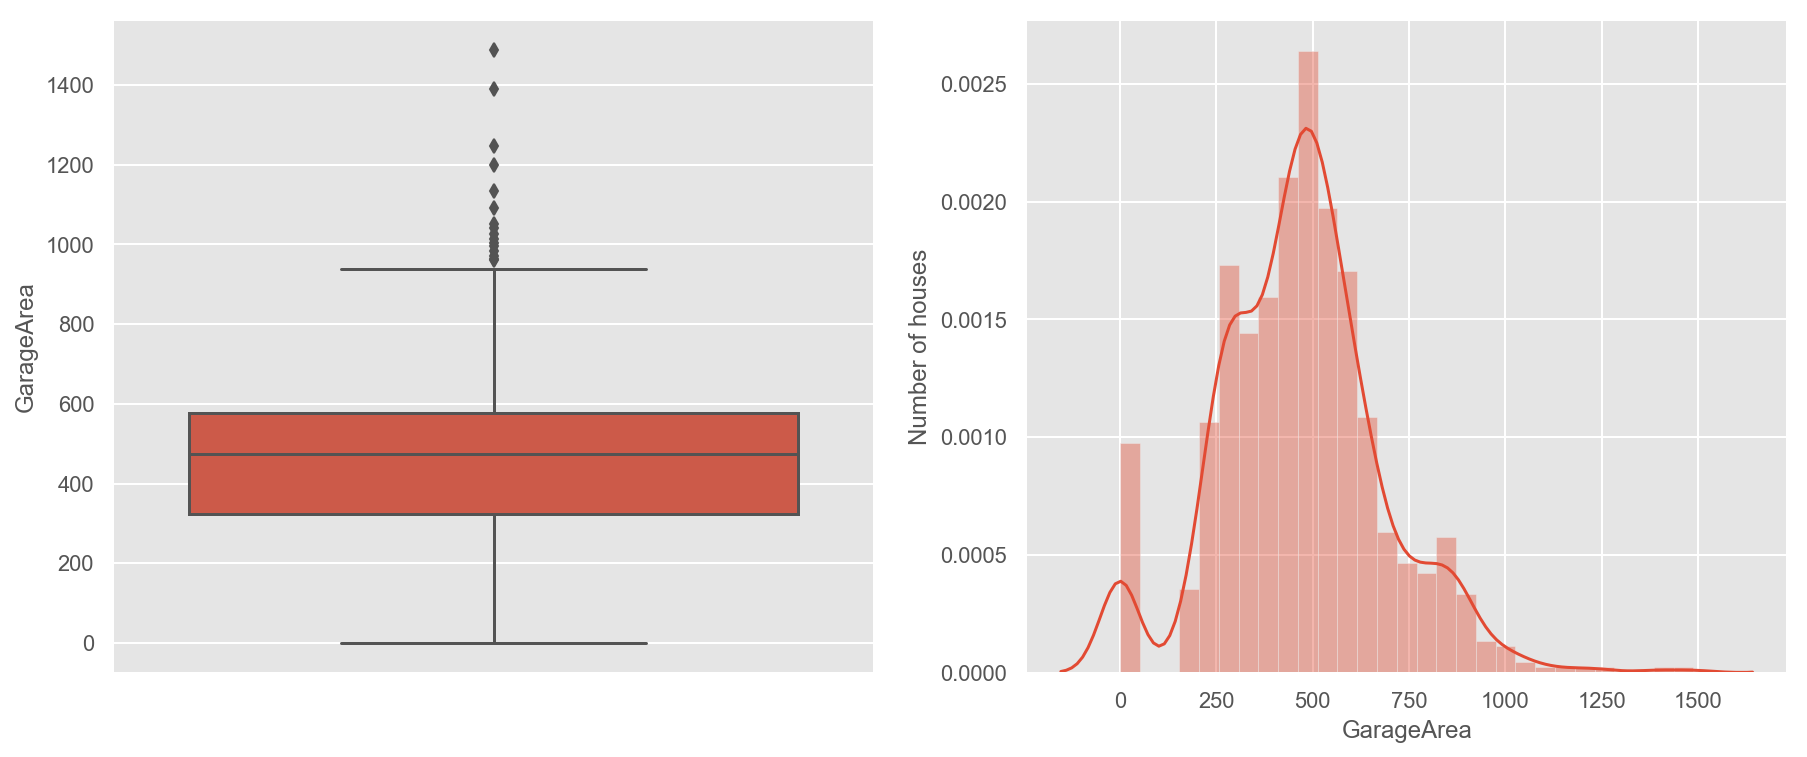

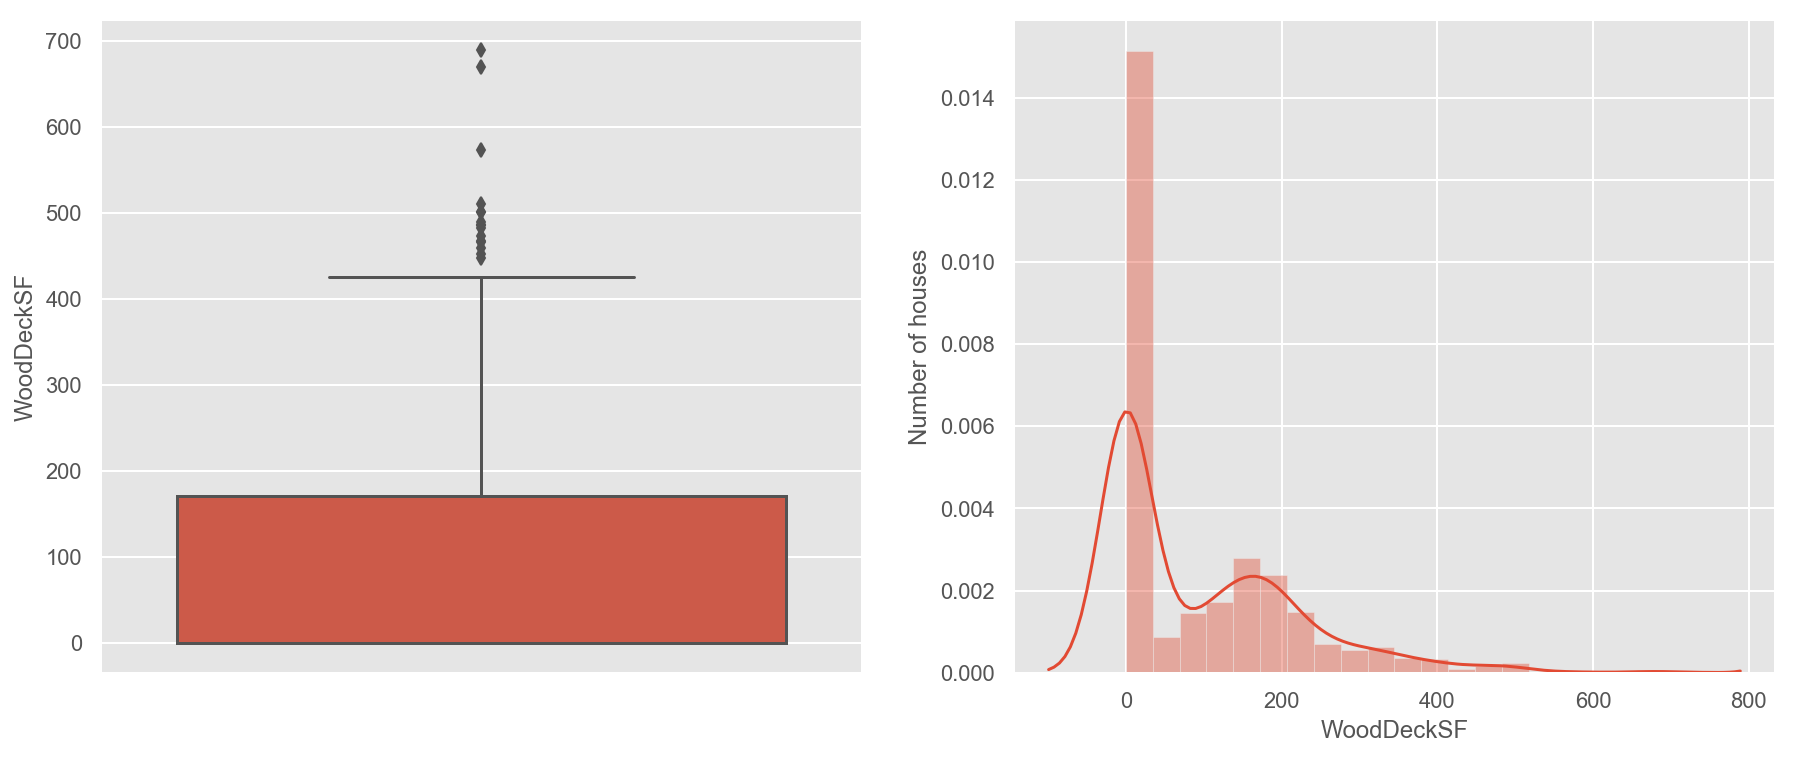

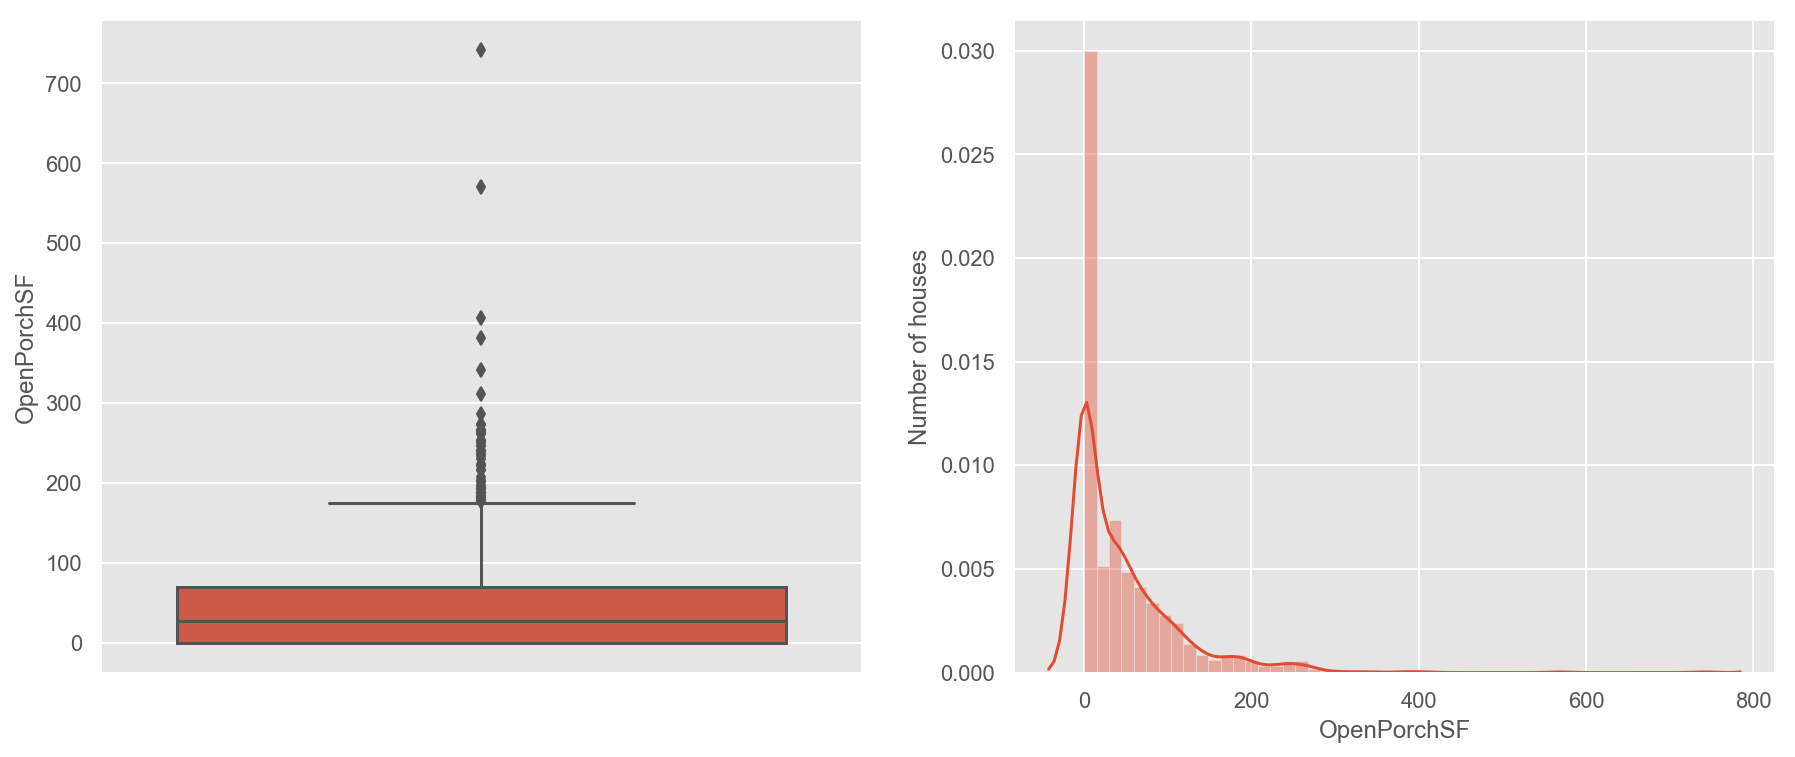

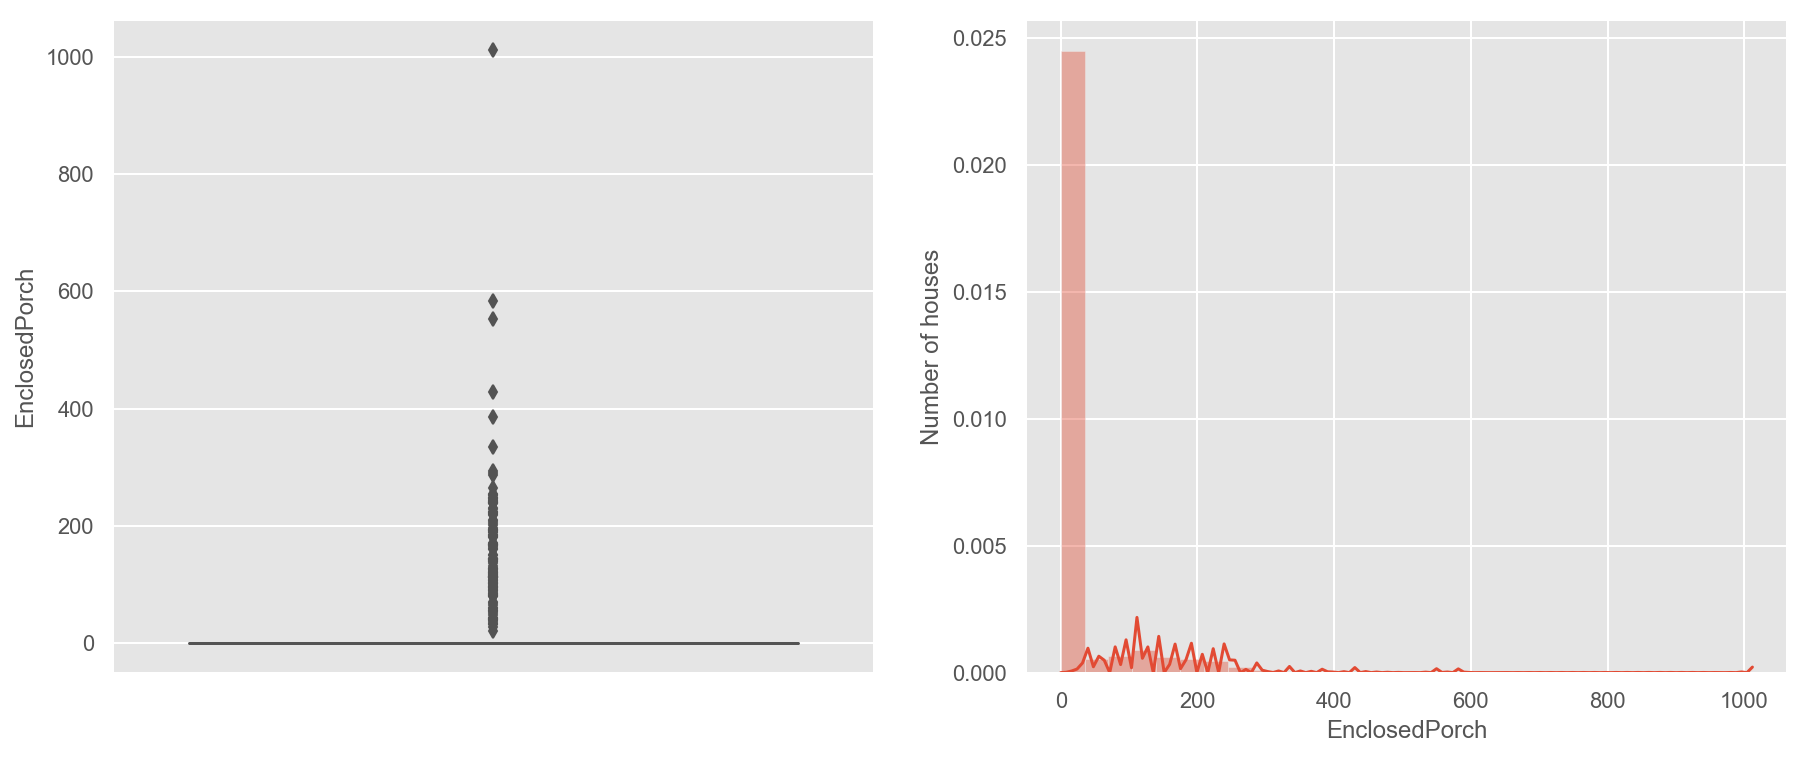

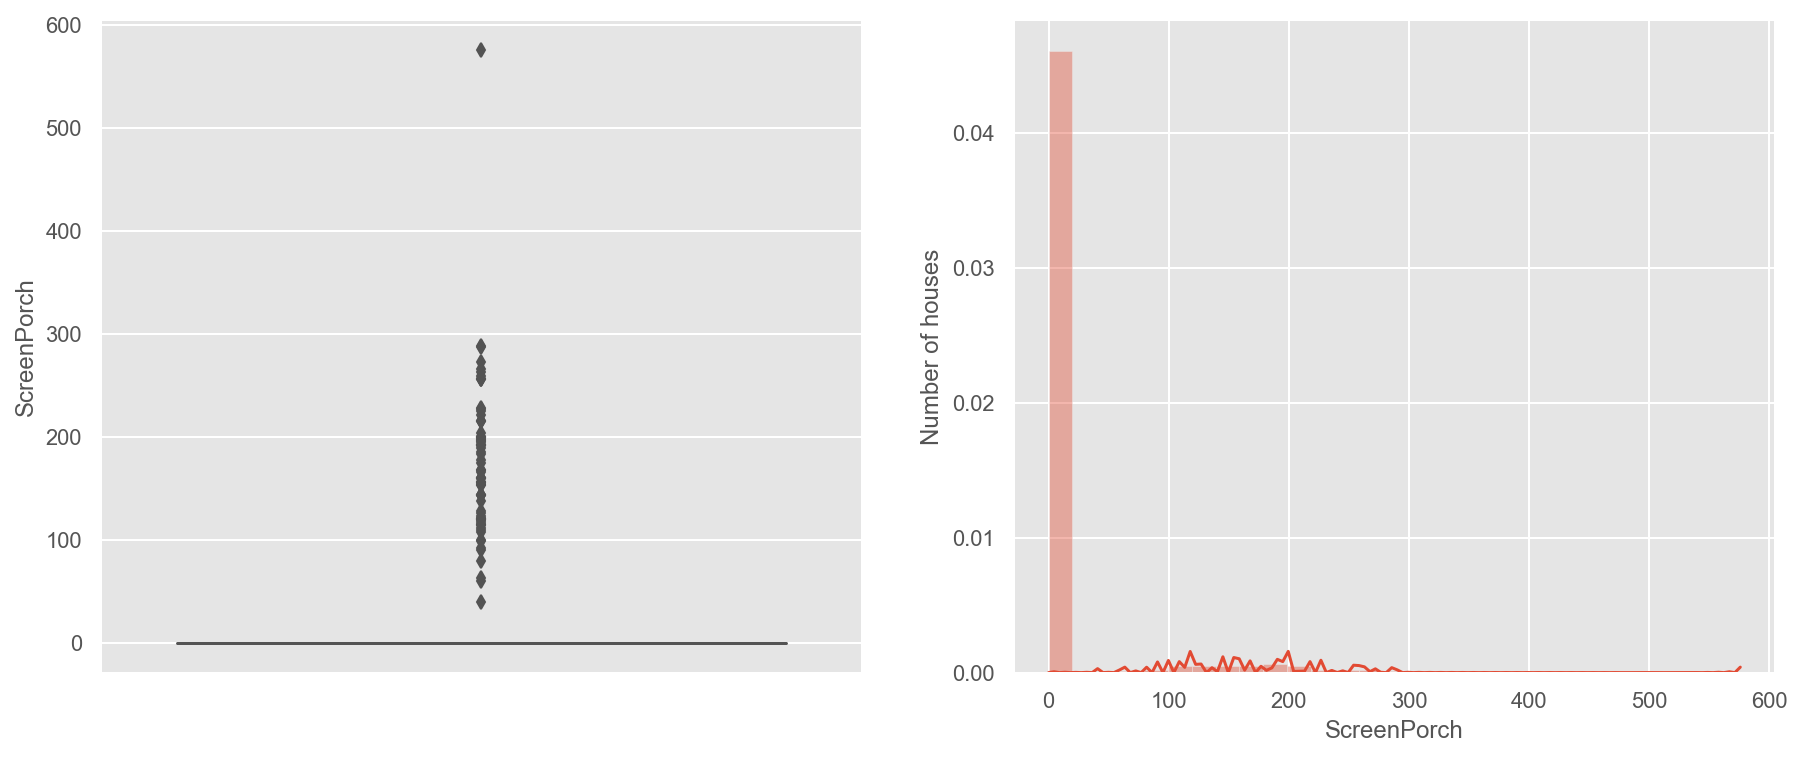

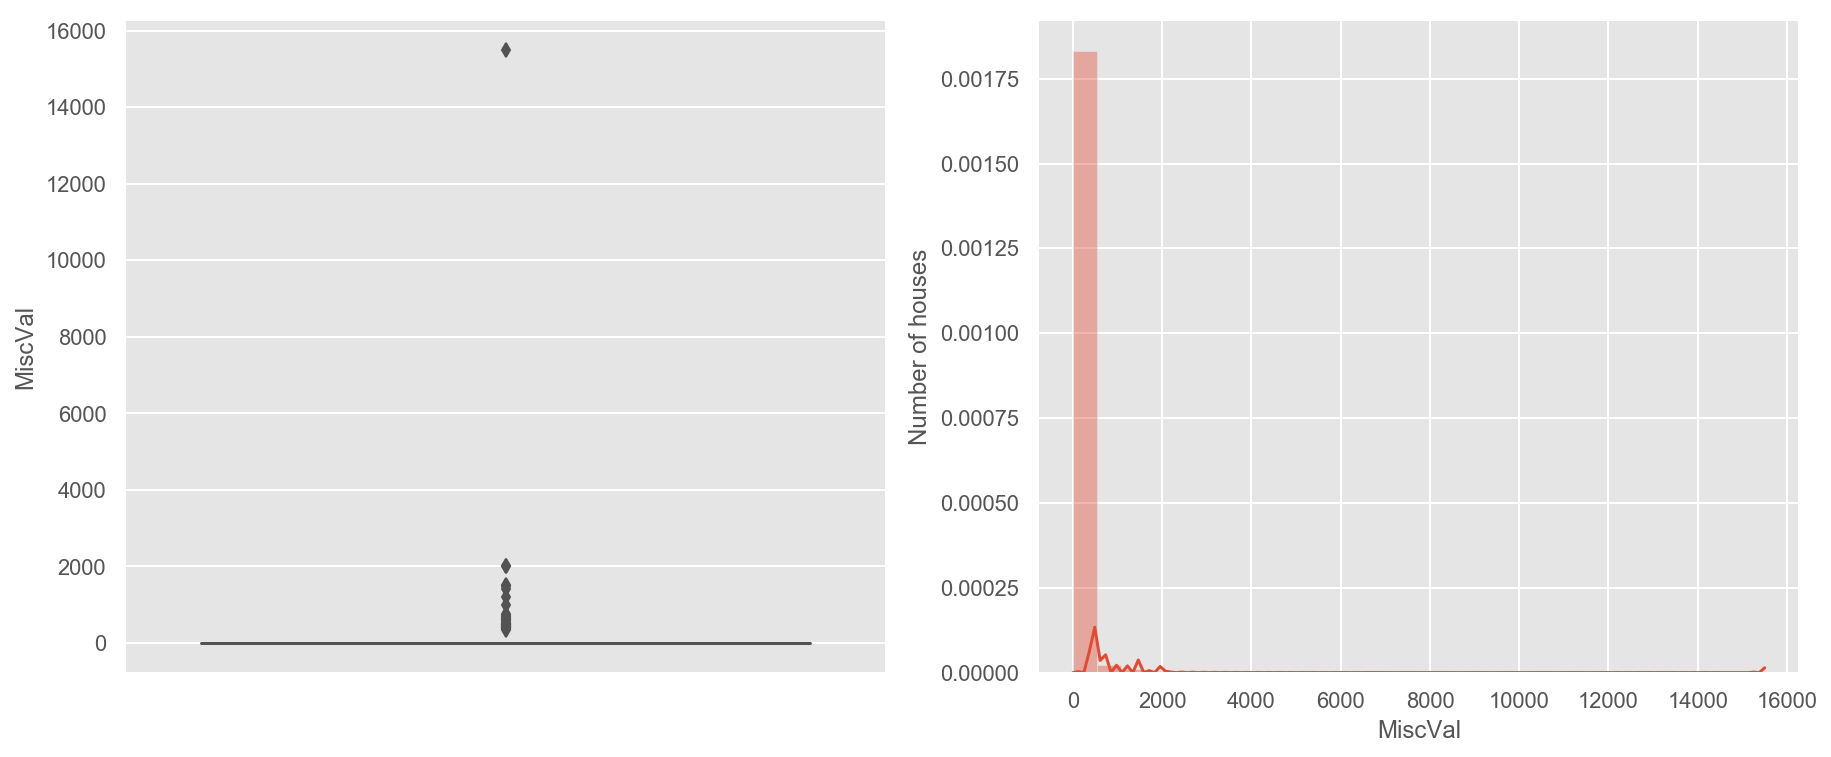

In [157]:
#  boxplots to visualise outliers in the continuous numerical variables 
# and histograms to get an idea of the distribution
#check the outliers 
for var in continuous_test:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=test_df[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(test_df[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

In [49]:
#find the outlies in discrete variables
for var in discrete_test:
    print(test_df[var].value_counts() / np.float(len(test_df)))
    print()

20     0.351536
60     0.205916
50     0.101251
120    0.068259
160    0.046644
70     0.043231
30     0.043231
90     0.038680
80     0.036405
85     0.022753
190    0.017065
75     0.007964
45     0.007964
180    0.006826
40     0.002275
Name: MSSubClass, dtype: float64

5     0.298066
6     0.257110
7     0.194539
8     0.113766
4     0.076223
9     0.034130
3     0.012514
10    0.009101
2     0.004551
Name: OverallQual, dtype: float64

5    0.552901
6    0.187713
7    0.136519
8    0.048919
4    0.035267
3    0.017065
9    0.013652
2    0.004551
1    0.003413
Name: OverallCond, dtype: float64

0      0.992036
481    0.001138
431    0.001138
420    0.001138
392    0.001138
360    0.001138
232    0.001138
80     0.001138
Name: LowQualFinSF, dtype: float64

0.0    0.576792
1.0    0.406143
2.0    0.017065
Name: BsmtFullBath, dtype: float64

0.0    0.944255
1.0    0.055745
Name: BsmtHalfBath, dtype: float64

2    0.496018
1    0.475540
3    0.021615
0    0.004551
4    0.002275
Name: Ful

#### Comparing the test and train numerical features :

In [50]:
df_num_train = test_df.select_dtypes(include = ['float64', 'int64'])
df_num_train.describe().T


count          mean           std          min          25%  \
Id             879.0  1.445588e+03  8.507171e+02          2.0        692.5   
PID            879.0  7.165050e+08  1.889135e+08  526302110.0  528486085.0   
MSSubClass     879.0  5.827076e+01  4.221139e+01         20.0         20.0   
LotFrontage    879.0  5.695563e+01  3.433868e+01          0.0         40.0   
LotArea        879.0  1.034092e+04  1.004734e+04       1477.0       7298.5   
OverallQual    879.0  6.054608e+00  1.374756e+00          2.0          5.0   
OverallCond    879.0  5.565415e+00  1.128422e+00          1.0          5.0   
YearBuilt      879.0  1.970534e+03  3.040353e+01       1880.0       1954.0   
YearRemod/Add  879.0  1.984445e+03  2.045455e+01       1950.0       1967.0   
MasVnrArea     879.0  1.068612e+02  1.882841e+02          0.0          0.0   
BsmtFinSF1     879.0  4.433970e+02  4.424802e+02          0.0          0.0   
BsmtFinSF2     879.0  5.383504e+01  1.785399e+02          0.0          0.0   
BsmtUnfSF      879.0  5.395188e+02  4.260827e+02          0.0        216.0   
TotalBsmtSF    879.0  1.036751e+03  4.192584e+02          0.0        790.0   
1stFlrSF       879.0  1.148053e+03  3.810223e+02        407.0        864.0   
2ndFlrSF       879.0  3.497520e+02  4.345951e+02          0.0          0.0   
LowQualFinSF   879.0  2.725825e+00  3.255412e+01          0.0          0.0   
GrLivArea      879.0  1.500531e+03  5.174133e+02        407.0       1114.0   
BsmtFullBath   879.0  4.402730e-01  5.299830e-01          0.0          0.0   
BsmtHalfBath   879.0  5.574516e-02  2.295596e-01          0.0          0.0   
FullBath       879.0  1.541524e+00  5.609079e-01          0.0          1.0   
HalfBath       879.0  3.993174e-01  5.060450e-01          0.0          0.0   
BedroomAbvGr   879.0  2.879408e+00  8.302491e-01          0.0          2.0   
KitchenAbvGr   879.0  1.047782e+00  2.238440e-01          0.0          1.0   
TotRmsAbvGrd   879.0  6.459613e+00  1.603071e+00          3.0          5.0   
Fireplaces     879.0  6.188851e-01  6.693131e-01          0.0          0.0   
GarageYrBlt    879.0  1.875595e+03  4.366406e+02          0.0       1957.0   
GarageCars     879.0  1.744027e+00  7.511617e-01          0.0          1.0   
GarageArea     879.0  4.708328e+02  2.130702e+02          0.0        323.0   
WoodDeckSF     879.0  9.356086e+01  1.211743e+02          0.0          0.0   
OpenPorchSF    879.0  4.747895e+01  6.920918e+01          0.0          0.0   
EnclosedPorch  879.0  2.403754e+01  7.321224e+01          0.0          0.0   
3SsnPorch      879.0  2.594994e+00  2.494842e+01          0.0          0.0   
ScreenPorch    879.0  1.481342e+01  5.297596e+01          0.0          0.0   
PoolArea       879.0  1.882821e+00  2.989970e+01          0.0          0.0   
MiscVal        879.0  4.844369e+01  5.498584e+02          0.0          0.0   
MoSold         879.0  6.207053e+00  2.644097e+00          1.0          5.0   
YrSold         879.0  2.007825e+03  1.327396e+00       2006.0       2007.0   

                       50%          75%           max  
Id                  1435.0       2197.0  2.928000e+03  
PID            535454160.0  907192140.0  1.007100e+09  
MSSubClass            50.0         70.0  1.900000e+02  
LotFrontage           60.0         78.5  1.820000e+02  
LotArea             9453.0      11606.5  2.152450e+05  
OverallQual            6.0          7.0  1.000000e+01  
OverallCond            5.0          6.0  9.000000e+00  
YearBuilt           1972.0       2000.0  2.010000e+03  
YearRemod/Add       1992.0       2003.0  2.010000e+03  
MasVnrArea             0.0        173.0  1.378000e+03  
BsmtFinSF1           374.0        735.5  2.288000e+03  
BsmtFinSF2             0.0          0.0  1.526000e+03  
BsmtUnfSF            453.0        781.5  2.046000e+03  
TotalBsmtSF          975.0       1248.0  3.138000e+03  
1stFlrSF            1064.0       1358.0  3.138000e+03  
2ndFlrSF               0.0        720.0  2.065000e+03  
LowQualFinSF        

In [158]:
df_num_test = test_df.select_dtypes(include = ['float64', 'int64'])
df_num_test.describe().T

count          mean           std          min          25%  \
Id             879.0  1.445588e+03  8.507171e+02          2.0        692.5   
PID            879.0  7.165050e+08  1.889135e+08  526302110.0  528486085.0   
MSSubClass     879.0  5.827076e+01  4.221139e+01         20.0         20.0   
LotFrontage    879.0  5.695563e+01  3.433868e+01          0.0         40.0   
LotArea        879.0  1.034092e+04  1.004734e+04       1477.0       7298.5   
OverallQual    879.0  6.054608e+00  1.374756e+00          2.0          5.0   
OverallCond    879.0  5.565415e+00  1.128422e+00          1.0          5.0   
YearBuilt      879.0  1.970534e+03  3.040353e+01       1880.0       1954.0   
YearRemod/Add  879.0  1.984445e+03  2.045455e+01       1950.0       1967.0   
MasVnrArea     879.0  1.068612e+02  1.882841e+02          0.0          0.0   
BsmtFinSF1     879.0  4.433970e+02  4.424802e+02          0.0          0.0   
BsmtFinSF2     879.0  5.383504e+01  1.785399e+02          0.0          0.0   
BsmtUnfSF      879.0  5.395188e+02  4.260827e+02          0.0        216.0   
TotalBsmtSF    879.0  1.036751e+03  4.192584e+02          0.0        790.0   
1stFlrSF       879.0  1.148053e+03  3.810223e+02        407.0        864.0   
2ndFlrSF       879.0  3.497520e+02  4.345951e+02          0.0          0.0   
LowQualFinSF   879.0  2.725825e+00  3.255412e+01          0.0          0.0   
GrLivArea      879.0  1.500531e+03  5.174133e+02        407.0       1114.0   
BsmtFullBath   879.0  4.402730e-01  5.299830e-01          0.0          0.0   
BsmtHalfBath   879.0  5.574516e-02  2.295596e-01          0.0          0.0   
FullBath       879.0  1.541524e+00  5.609079e-01          0.0          1.0   
HalfBath       879.0  3.993174e-01  5.060450e-01          0.0          0.0   
BedroomAbvGr   879.0  2.879408e+00  8.302491e-01          0.0          2.0   
KitchenAbvGr   879.0  1.047782e+00  2.238440e-01          0.0          1.0   
TotRmsAbvGrd   879.0  6.459613e+00  1.603071e+00          3.0          5.0   
Fireplaces     879.0  6.188851e-01  6.693131e-01          0.0          0.0   
GarageYrBlt    879.0  1.875595e+03  4.366406e+02          0.0       1957.0   
GarageCars     879.0  1.744027e+00  7.511617e-01          0.0          1.0   
GarageArea     879.0  4.708328e+02  2.130702e+02          0.0        323.0   
WoodDeckSF     879.0  9.356086e+01  1.211743e+02          0.0          0.0   
OpenPorchSF    879.0  4.747895e+01  6.920918e+01          0.0          0.0   
EnclosedPorch  879.0  2.403754e+01  7.321224e+01          0.0          0.0   
3SsnPorch      879.0  2.594994e+00  2.494842e+01          0.0          0.0   
ScreenPorch    879.0  1.481342e+01  5.297596e+01          0.0          0.0   
PoolArea       879.0  1.882821e+00  2.989970e+01          0.0          0.0   
MiscVal        879.0  4.844369e+01  5.498584e+02          0.0          0.0   
MoSold         879.0  6.207053e+00  2.644097e+00          1.0          5.0   
YrSold         879.0  2.007825e+03  1.327396e+00       2006.0       2007.0   

                       50%          75%           max  
Id                  1435.0       2197.0  2.928000e+03  
PID            535454160.0  907192140.0  1.007100e+09  
MSSubClass            50.0         70.0  1.900000e+02  
LotFrontage           60.0         78.5  1.820000e+02  
LotArea             9453.0      11606.5  2.152450e+05  
OverallQual            6.0          7.0  1.000000e+01  
OverallCond            5.0          6.0  9.000000e+00  
YearBuilt           1972.0       2000.0  2.010000e+03  
YearRemod/Add       1992.0       2003.0  2.010000e+03  
MasVnrArea             0.0        173.0  1.378000e+03  
BsmtFinSF1           374.0        735.5  2.288000e+03  
BsmtFinSF2             0.0          0.0  1.526000e+03  
BsmtUnfSF            453.0        781.5  2.046000e+03  
TotalBsmtSF          975.0       1248.0  3.138000e+03  
1stFlrSF            1064.0       1358.0  3.138000e+03  
2ndFlrSF               0.0        720.0  2.065000e+03  
LowQualFinSF        

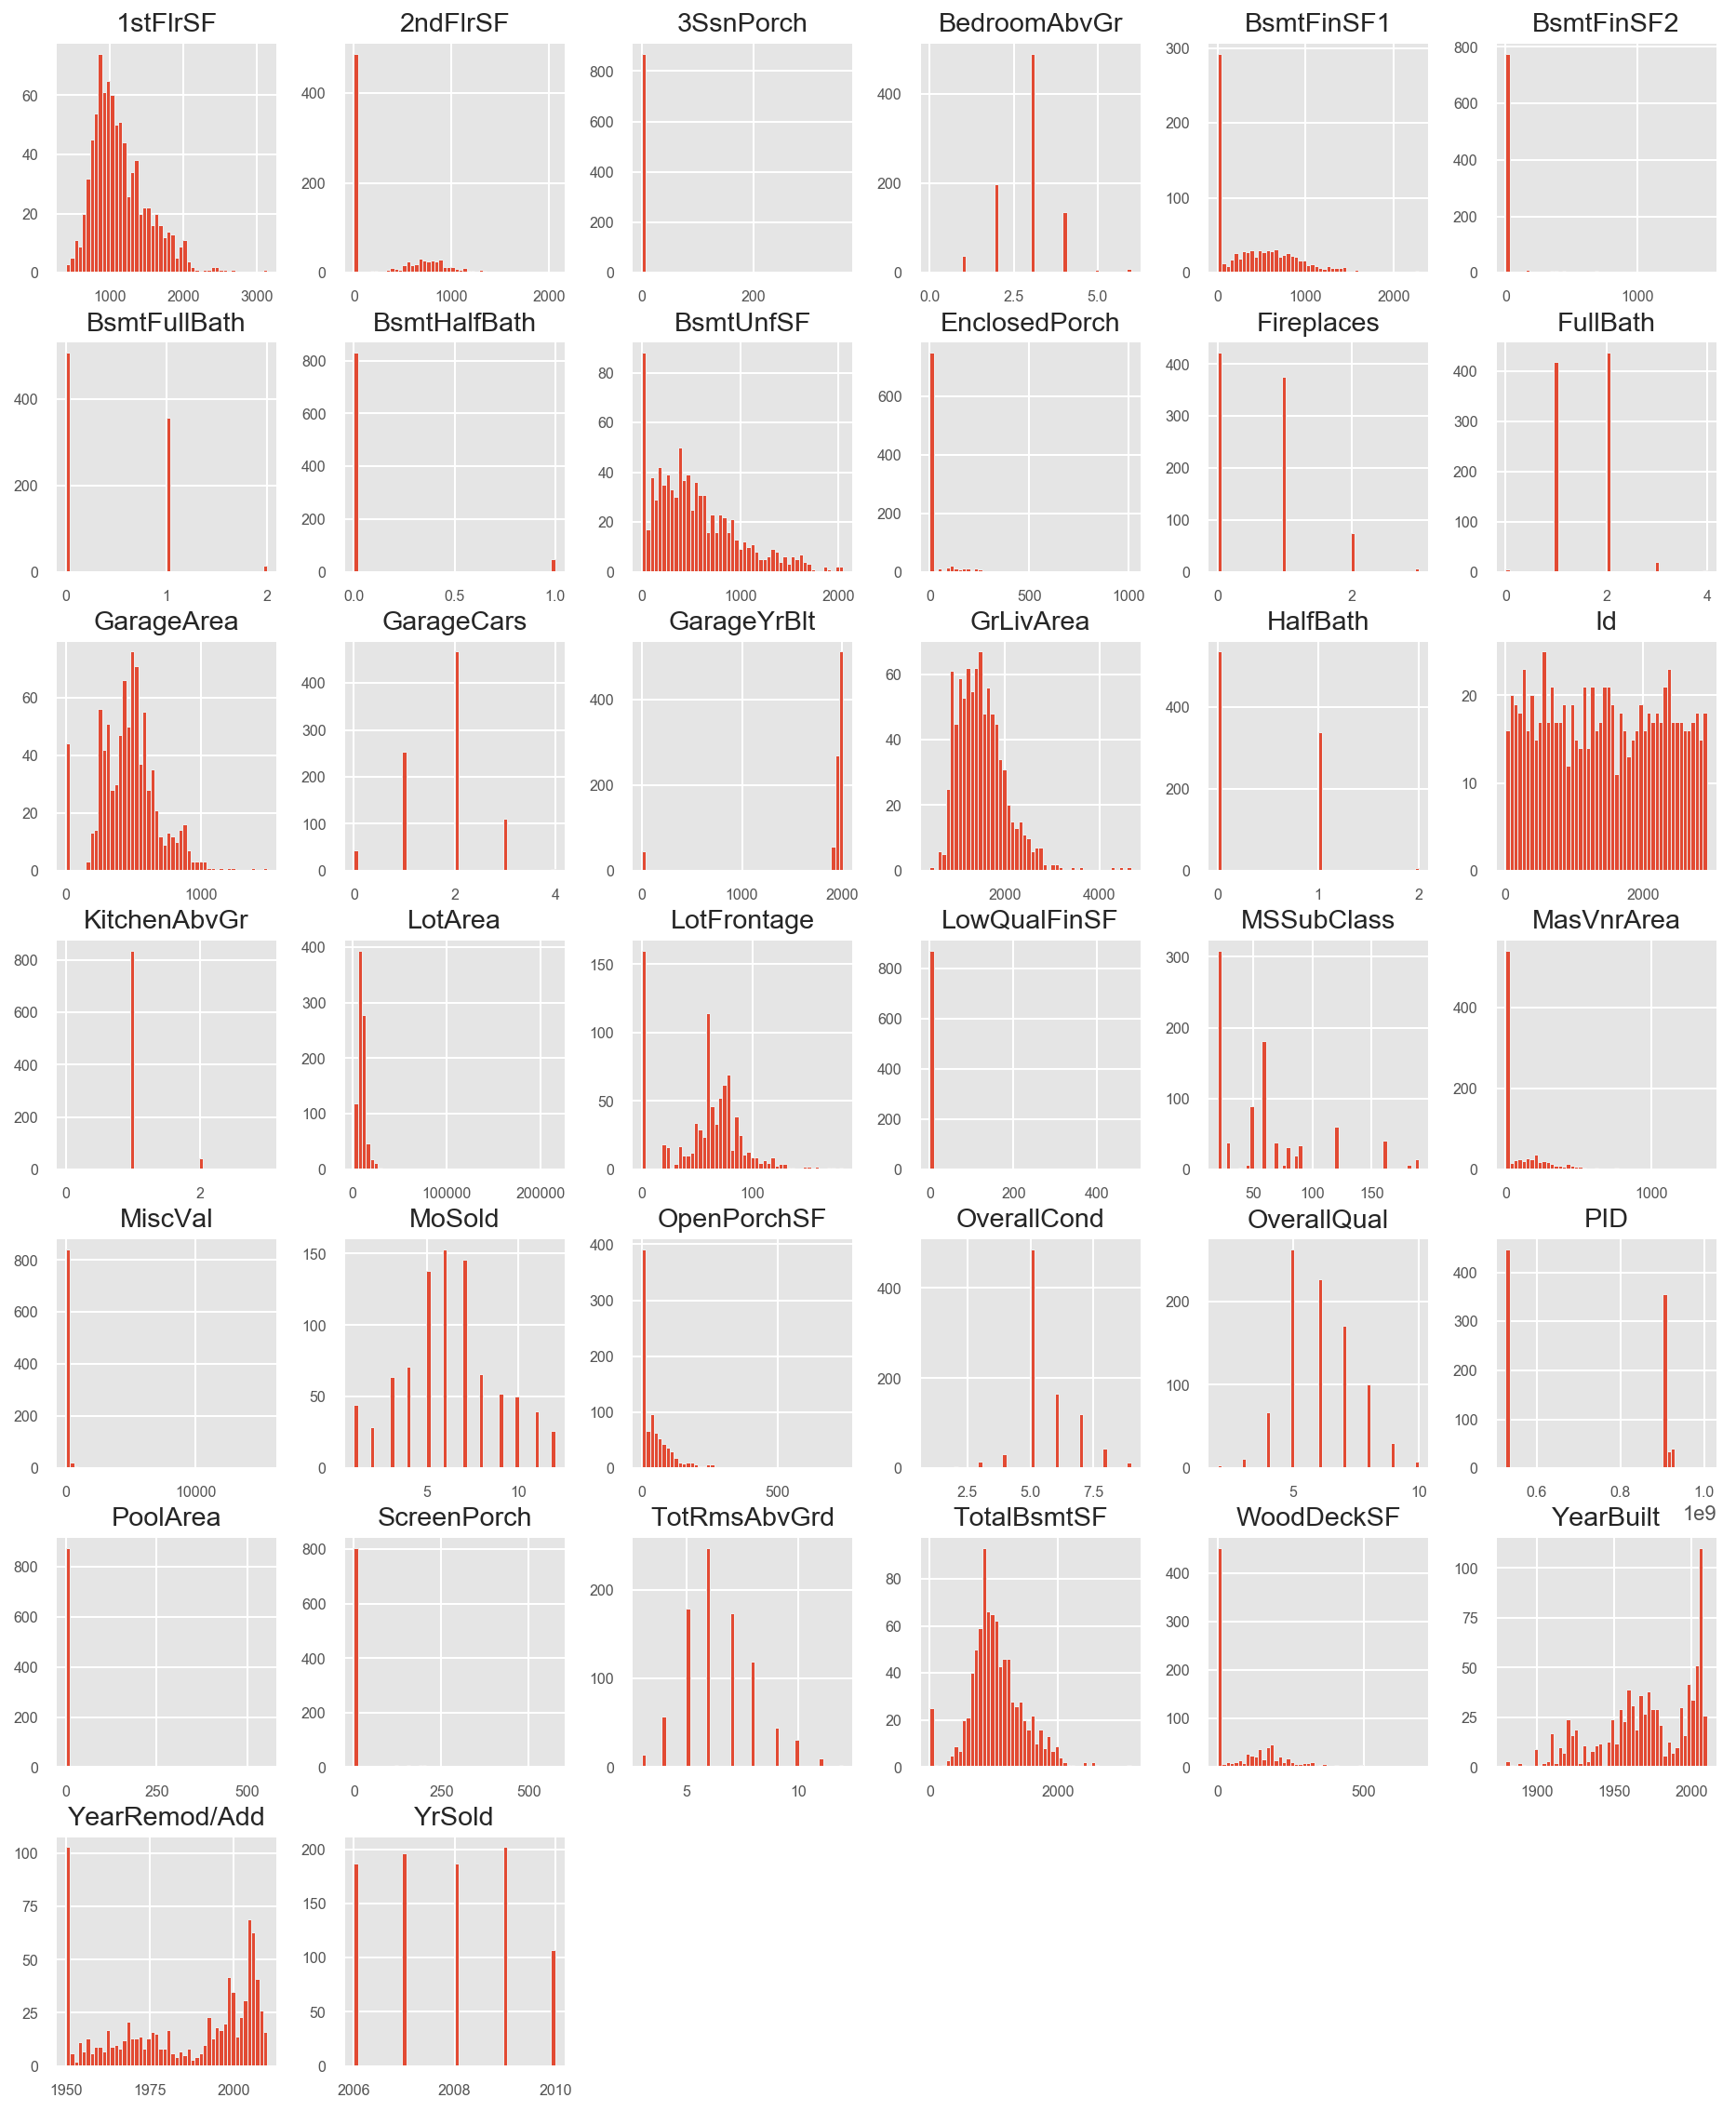

In [159]:
#
df_num_test.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

#####   <font color='red'> 1stFlrSF, BsmtUnfSF,GrLiveArea,GarageArea, and TotalBsmtSF in the testing set have the most similar distribution (right skewed) among other features to the SalePrice's. This might indicate a realtionship to the target </font>

### 2. Categorical data -test


In [53]:
for var in categorical_test:
    print(var, ' contains ', len(test_df[var].unique()), ' labels')

MSZoning  contains  6  labels
Street  contains  2  labels
Alley  contains  3  labels
LotShape  contains  4  labels
LandContour  contains  4  labels
Utilities  contains  2  labels
LotConfig  contains  5  labels
LandSlope  contains  3  labels
Neighborhood  contains  26  labels
Condition1  contains  9  labels
Condition2  contains  4  labels
BldgType  contains  5  labels
HouseStyle  contains  8  labels
RoofStyle  contains  6  labels
RoofMatl  contains  6  labels
Exterior1st  contains  13  labels
Exterior2nd  contains  16  labels
MasVnrType  contains  5  labels
ExterQual  contains  4  labels
ExterCond  contains  5  labels
Foundation  contains  6  labels
BsmtQual  contains  6  labels
BsmtCond  contains  4  labels
BsmtExposure  contains  5  labels
BsmtFinType1  contains  7  labels
BsmtFinType2  contains  7  labels
Heating  contains  4  labels
HeatingQC  contains  4  labels
CentralAir  contains  2  labels
Electrical  contains  5  labels
KitchenQual  contains  5  labels
Functional  contains  6 

In [54]:
categorical_test

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [236]:
# Dummifying the target(SaleCondition)



df1_SCdummy_test=test_df
cc2=pd.get_dummies(df1_SCdummy_test[categorical_test],drop_first=True)
df1_SCdummy_test=df1_SCdummy_test.drop(df1_SCdummy_test[categorical_test],axis=1)
df1_SCdummy_test=df1_SCdummy_test.join(cc2)

df1_SCdummy_test=df1_SCdummy_test.sort_values('Id')
df1_SCdummy_test.head(3)

Id        PID  MSSubClass  LotFrontage  LotArea  OverallQual  \
704   2  526350040          20         80.0    11622            5   
706   4  526353030          20         93.0    11160            7   
120   6  527105030          60         78.0     9978            6   

     OverallCond  YearBuilt  YearRemod/Add  MasVnrArea      ...       \
704            6       1961           1961         0.0      ...        
706            5       1968           1968         0.0      ...        
120            6       1998           1998        20.0      ...        

     MiscFeature_Shed  SaleType_CWD  SaleType_Con  SaleType_ConLD  \
704                 0             0             0               0   
706                 0             0             0               0   
120                 0             0             0               0   

     SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_VWD  \
704               0               0             0             0             0   
706               0               0             0             0             0   
120               0               0             0             0             0   

     SaleType_WD   
704             1  
706             1  
120             1  

[3 rows x 246 columns]

In [161]:
test_df.shape

(879, 80)

In [162]:
df1_SCdummy_test.shape

(879, 246)

#### Integer Encoding & Dummification - Test


In [59]:

## test_enc=test_df
##GarageFinish  contains  4  labels
## GarageQual  contains  5  labels
##GarageCond  contains  6  labels
## PavedDrive  contains  3  labels
## PoolQC  contains  3  labels
##MiscFeature  contains  4  labels

# test_enc["GarageFinish"] = encoder.fit_transform(test_enc["GarageFinish"])
# test_enc["GarageQual"] = encoder.fit_transform(test_enc["GarageQual"])

# test_enc["GarageCond"] = encoder.fit_transform(test_enc["GarageCond"])

# test_enc["PavedDrive"] = encoder.fit_transform(test_enc["PavedDrive"])

# test_enc["PoolQC"] = encoder.fit_transform(test_enc["PoolQC"])
# test_enc["MiscFeature"] = encoder.fit_transform(test_enc["MiscFeature"])


# test_enc

In [60]:
# df_SCdummy_test.to_csv("df_SCdummy_test.csv")  
# df_SCdummy.to_csv("df_SCdummy.csv")

# for c in df_SCdummy_test:
#     if c not in df_SCdummy:
#         print(c)

---

# Classification  Models

In [164]:
from sklearn.preprocessing import StandardScaler

#Standardize Train Features
train_predictors = ['LotArea','YearBuilt', 'OverallQual','1stFlrSF','2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd','GrLivArea','Fireplaces','GarageArea','MiscVal']
Xtrain=df1_SCdummy[train_predictors]
Xtrain=StandardScaler().fit_transform(Xtrain)

ytrain=df1_SCdummy.SaleCondition

#Standardize Test Features

test_predictors = ['LotArea','YearBuilt','OverallQual','1stFlrSF','2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd','GrLivArea','Fireplaces','GarageArea','MiscVal']
Xtest=df1_SCdummy_test[test_predictors]
Xtest=StandardScaler().fit_transform(Xtest)



C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## PCA

In [165]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents_Train = pca.fit_transform(Xtrain)
principalComponents_Test = pca.fit_transform(Xtest)

principalDf_tarin = pd.DataFrame(data = principalComponents_Train
             , columns = ['principal component 1', 'principal component 2'])

principalDf_test= pd.DataFrame(data = principalComponents_Test
             , columns = ['principal component 1', 'principal component 2'])
principalDf_tarin.head()

principal component 1  principal component 2
0               1.209308              -1.040872
1              -0.051831              -0.587831
2               0.541944               0.472555
3              -0.308310              -1.740543
4               0.799698              -2.296308

In [166]:
finalDf_train = pd.concat([principalDf_tarin, ytrain], axis = 1)
finalDf_train

principal component 1  principal component 2  SaleCondition
0                  1.209308              -1.040872              0
1                 -0.051831              -0.587831              0
2                  0.541944               0.472555              1
3                 -0.308310              -1.740543              0
4                  0.799698              -2.296308              0
5                  1.316984               0.462665              0
6                  0.833500               1.010024              0
7                 -0.422486              -0.509701              1
8                  0.499268               0.698131              0
9                 -0.568847              -1.859077              0
10                -1.070852              -2.631635              1
11                 7.682031               1.512175              1
12                -2.896492              -0.555214              0
13                 2.118679              -1.192347              0
14                 1.382269              -0.903327              0
15                 1.026624               0.596172              0
16                -1.452394              -1.250918              1
17                -1.047160              -0.383937              0
18                -1.493500              -0.027816              0
19                -2.637707               0.410916              0
20                 0.017703              -1.881031              0
21                -2.578222               0.397194              0
22                -1.907461               1.224922              0
23                -1.210036              -1.359192              0
24                -0.011915               0.646682              0
25                -2.615459              -1.033857              0
26                 4.037400              -0.366453              0
27                 2.182350              -1.831445              0
28                 1.341894              -1.227448              0
29                 2.531114              -1.595643              0
...                     ...                    ...            ...
2021               1.160425              -1.176671              0
2022               1.716844               0.465050              0
2023               0.939171              -1.050588              0
2024              -0.323558              -0.483600              0
2025               3.456221               0.180299              0
2026              -0.761530              -1.283761              0
2027               1.137779              -1.987344              0
2028              -0.368264              -1.594221              0
2029               0.210058              -1.577318              0
2030              -0.496186              -1.537706              1
2031               2.362884              -1.853897              0
2032               2.973774              -1.568675              0
2033              -1.543757               0.528214              0
2034               0.802748              -1.490587              0
2035              -1.003782              -1.271969              0
2036              -0.805209              -1.345865              0
2037              -0.058718               1.387871              0
2038               3.308569               3.045770              0
2039              -2.392334               0.074470              0
2040               1.454960              -0.084817              0
2041              -4.676502              -0.660264              0
2042              -2.633286               1.356982              1
2043              -2.600245               1.336834              0
2044              -2.998734               1.706850              0
2045               1.030188               0.314144              0
2046              -0.428544              -0.676813              0
2047              -1.213086              -0.545752              0
2048              -2.259583              -0.929803              0
2049              -0.982975              -1.02

Automatically created module for IPython interactive environment

Prediction accuracy for the normal test dataset with PCA
92.86%


Prediction accuracy for the standardized test dataset with PCA
92.86%


PC 1 without scaling:
 [0.19467349 0.22387881 0.32872575 0.2967949  0.23466431 0.34778813
 0.2328051  0.37352686 0.43467403 0.24487315 0.30282537 0.07403147]

PC 1 with scaling:
 [0.18486399 0.22481698 0.33675022 0.29296351 0.2349216  0.3472029
 0.22944253 0.37640038 0.43168821 0.24737904 0.30848121 0.05730111]


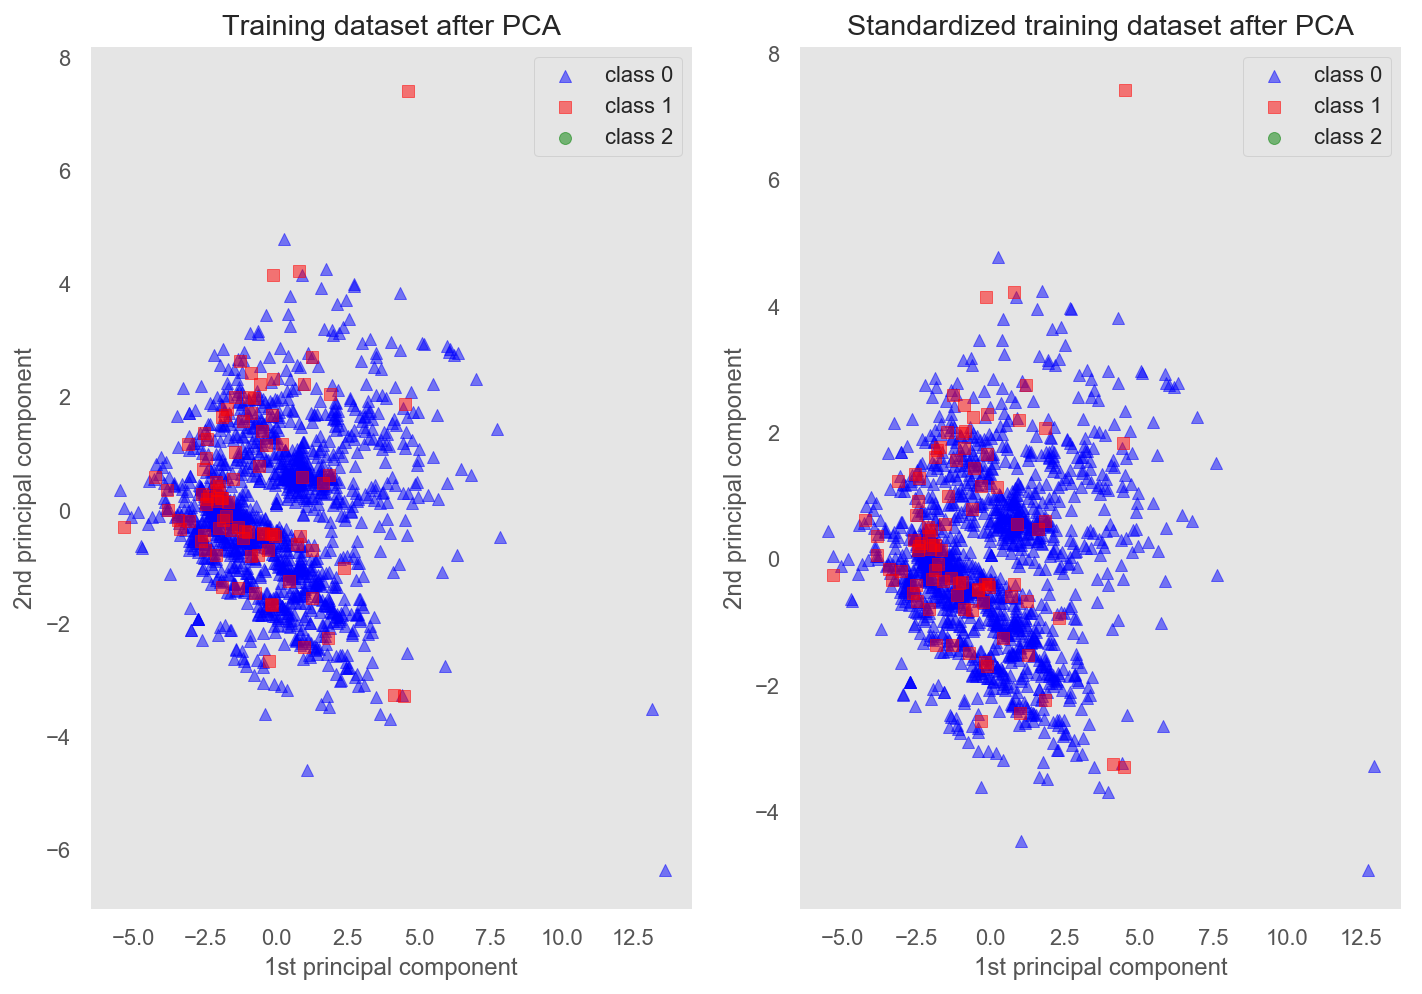

In [167]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
print(__doc__)

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

RANDOM_STATE = 42
FIG_SIZE = (10, 7)


features, target = load_wine(return_X_y=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))

# Extract PCA from pipeline
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

# Show first principal components
print('\nPC 1 without scaling:\n', pca.components_[0])
print('\nPC 1 with scaling:\n', pca_std.components_[0])

# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)


for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train_transformed[y_train == l, 0],
                X_train_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

## train&test split - classification

In [170]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

#train set

# X_train, X_test, y_train, y_test = train_test_split(
#                                     Xtrain, ytrain, random_state=42, test_size=.33)





### KNN Neighbors Classifier

In [209]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtrain, ytrain)
y_predknn = knn.predict(Xtest).astype(int)


print('F1 score training: ', cross_val_score(knn,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(knn,Xtest, y_predknn,cv=5, scoring='f1').mean())

F1 score training:  0.9176248182526932
F1 score testing:  0.8868547468417359


###  Gaussian NB

In [208]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
Y_pred_1=gnb.predict(Xtest)

print('F1 score training: ', cross_val_score(gnb,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(gnb,Xtest, Y_pred_1,cv=5, scoring='f1').mean())




F1 score training:  0.93689294391893
F1 score testing:  0.8590145932401351


## Descion Tree 

In [175]:
from sklearn.tree import tree, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import metrics



In [211]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=4)

classifier.fit(Xtrain, ytrain)

Y_pred = classifier.predict(Xtest)
print('F1 score training: ', cross_val_score(classifier,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(classifier,Xtest, Y_pred,cv=5, scoring='f1').mean())

F1 score training:  0.9343776416109175
F1 score testing:  0.9943573693097456


### Random Forest 

In [212]:
#Best result fir classification

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(Xtrain, ytrain)
y_predrf = random_forest.predict(Xtest)


print('F1 score training: ', cross_val_score(random_forest,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(random_forest,Xtest, y_predrf,cv=5, scoring='f1').mean())


F1 score training:  0.9475537829849638
F1 score testing:  0.9964757709251101


### SVM

In [213]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

from sklearn import svm

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf_svm = GridSearchCV(svc, parameters, cv=5)
clf_svm.fit(Xtrain, ytrain)
Y_SVM= clf_svm.predict(Xtest)


print('F1 score training: ', cross_val_score(clf_svm,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(clf_svm,Xtest, Y_SVM,cv=5, scoring='f1').mean())


F1 score training:  0.9438118267936533
F1 score testing:  0.9693538441723618


### logistic regression


In [181]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


In [218]:

#create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
#use 5 cross-validation folds
LR_model = LogisticRegression()
LR_model.fit(X_train,y_train)

Y_lr = LR_model.predict(Xtest)


print('F1 score training: ', cross_val_score(LR_model,Xtrain, ytrain,cv=5, scoring='f1').mean())
# print('F1 score testing: ', cross_val_score(LR_model,Xtest, Y_lr,cv=5, scoring='f1').mean())



F1 score training:  0.9447336619239236


C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  raise ValueError("multi_class should be either multinomial or "
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  raise ValueError("multi_class should be either multinomial or "
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  raise ValueError("multi_class should be either multinomial or "
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  raise ValueError("multi_class should be either multi

### Random Forest Classifier |2

In [219]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Xtrain, ytrain = make_classification(n_samples=1000, n_features=12,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf_RF= RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)
clf_RF.fit(Xtrain, ytrain)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)



Y_rf=clf_RF.predict(Xtest)
f=clf_RF.feature_importances_
feature_impor=pd.DataFrame(f , columns=['feature_importances_'])
s=pd.DataFrame(df1_SCdummy.columns , columns=['train_col'])
s2=pd.DataFrame(df1_SCdummy_test.columns , columns=['test_col'])

feature_impor=feature_impor.join(s)
feature_impor=feature_impor.join(s2)
yprdict_clf_RF=clf_RF.predict(Xtest)

print('F1 score training: ', cross_val_score(clf_RF,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(clf_RF,Xtest, yprdict_clf_RF,cv=5, scoring='f1').mean())




feature_impor.sort_values(by='feature_importances_' , ascending=False).head(20)

F1 score training:  0.9448583900885174
F1 score testing:  0.9934965883820064


feature_importances_      train_col       test_col
1               0.503472            PID            PID
0               0.127500             Id             Id
7               0.061734      YearBuilt      YearBuilt
3               0.050486    LotFrontage    LotFrontage
10              0.043911     BsmtFinSF1     BsmtFinSF1
4               0.040169        LotArea        LotArea
5               0.036999    OverallQual    OverallQual
9               0.036728     MasVnrArea     MasVnrArea
8               0.035235  YearRemod/Add  YearRemod/Add
11              0.032661     BsmtFinSF2     BsmtFinSF2
2               0.018570     MSSubClass     MSSubClass
6               0.012533    OverallCond    OverallCond

#### Gradient Boosting Classifier  

In [ ]:
# need to download SMOTE
# !pip install -U imbalanced-learn
# conda install -c glemaitre imbalanced-learn

In [222]:
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,IsolationForest
from imblearn.over_sampling import SMOTE

m0=SMOTE()
X_res, y_res=m0.fit_sample(Xtrain,ytrain)
gbc=GradientBoostingClassifier(max_depth=2,n_estimators=2000,min_samples_split=0.23,min_impurity_decrease=4,learning_rate=0.05)
gbc.fit(X_res,y_res)
y_predict_gbc=gbc.predict(Xtest)

print('F1 score training: ', cross_val_score(gbc,Xtrain, ytrain,cv=5, scoring='f1').mean())
print('F1 score testing: ', cross_val_score(gbc,Xtest, y_predict_gbc,cv=5, scoring='f1').mean())


F1 score training:  0.9448583900885174
F1 score testing:  0.9954994622892276


### Kaggle Submission - classification

In [225]:

S=df1_SCdummy_test[['Id']]
df_id=pd.DataFrame(S, columns=['Id'])
sale_cond=pd.DataFrame(y_predict_gbc, columns=['SaleCondition'])  # Only change y_predict 
sale_result=df_id.join(sale_cond)

sale_result.to_csv('y_predict_gbc_result.csv', index=False)
sale_result

Id  SaleCondition
704     2              1
706     4              1
120     6              1
312     7              1
401    17              0
316    18              1
791    22              0
608    27              0
391    31              0
753    36              1
317    39              1
324    40              1
710    42              1
453    46              1
168    53              1
620    58              0
201    61              0
643    72              1
469    79              0
441    80              1
393    82              1
479    83              1
587    85              0
49     88              1
794    92              1
345    93              1
8      95              1
636   102              1
648   103              1
346   106              1
..    ...            ...
244  2825              1
270  2828              1
637  2831              1
125  2843              1
435  2845              0
252  2847              0
336  2855              1
198  2856              0
679  2859              1
287  2865              0
560  2867              1
368  2869              1
311  2870              1
490  2874              1
646  2876              1
734  2889              1
717  2892              1
89   2895              0
418  2898              0
766  2901              1
750  2902              1
114  2908              1
509  2909              1
582  2916              0
483  2917              0
537  2919              1
179  2921              1
829  2922              1
669  2925              0
675  2928              1

[879 rows x 2 columns]

-----

# Predicting SalesPrices - Regression Problem :

##  Data Prep:


In [227]:
from sklearn.preprocessing import StandardScaler

#Standardize Train Features
train_predictors = ['LotArea','YearBuilt','TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd','GrLivArea','Fireplaces','GarageArea','MiscVal']
Xtrain_r=df1_SCdummy[train_predictors]
# Xtrain_r=StandardScaler().fit_transform(Xtrain)

ytrain_r=df1_SCdummy.SalePrice

#Standardize Test Features

test_predictors = ['LotArea','YearBuilt','TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd','GrLivArea','Fireplaces','GarageArea','MiscVal']
Xtest_r=df1_SCdummy_test[test_predictors]
# Xtest_r=StandardScaler().fit_transform(Xtest)



#### Target(SalePrice) Analysis

In [ ]:
# Most of the following feaetures have  have positive linear relationship with the saleprice.
#  ['LotArea','YearBuilt','1stFlrSF','OverallQual',2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd','GrLivArea','Fireplaces','GarageArea','MiscVal']

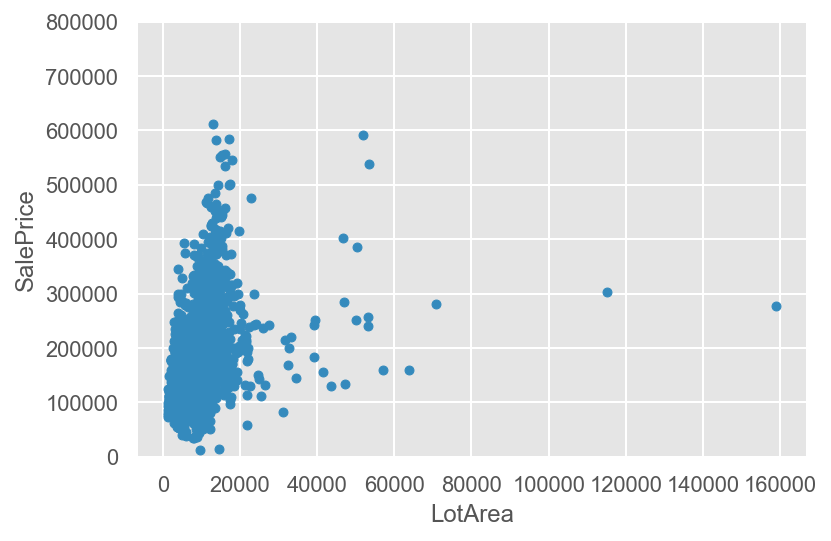

In [228]:


var = 'LotArea'
data = pd.concat([df1_SCdummy['SalePrice'], df1_SCdummy[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

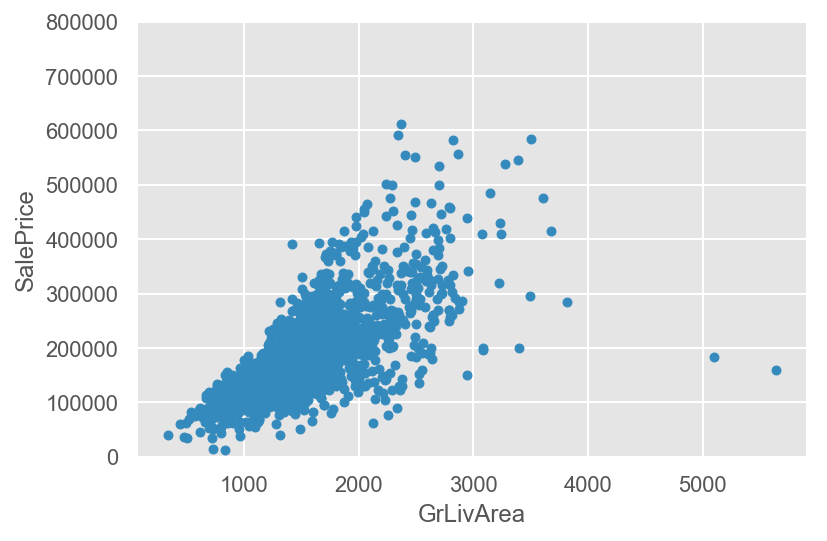

In [229]:
var = 'GrLivArea'
data = pd.concat([df1_SCdummy['SalePrice'], df1_SCdummy[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

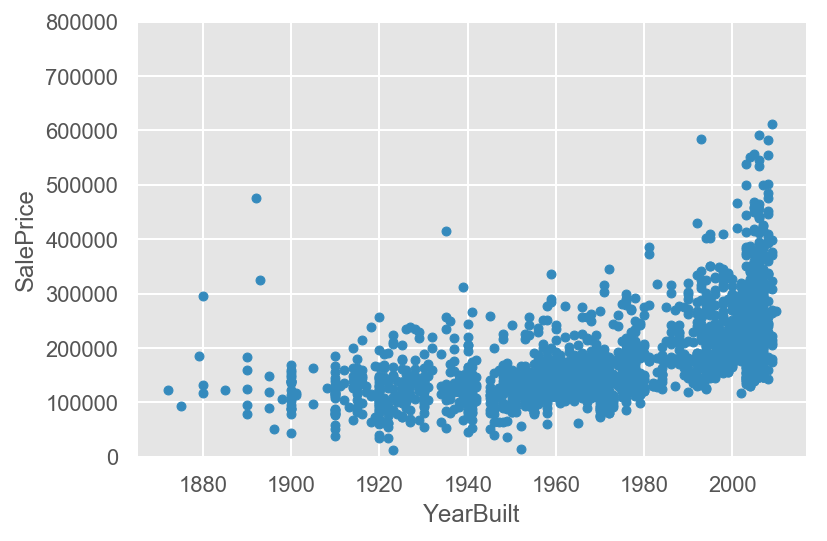

In [230]:
var = 'YearBuilt'
data = pd.concat([df1_SCdummy['SalePrice'], df1_SCdummy[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

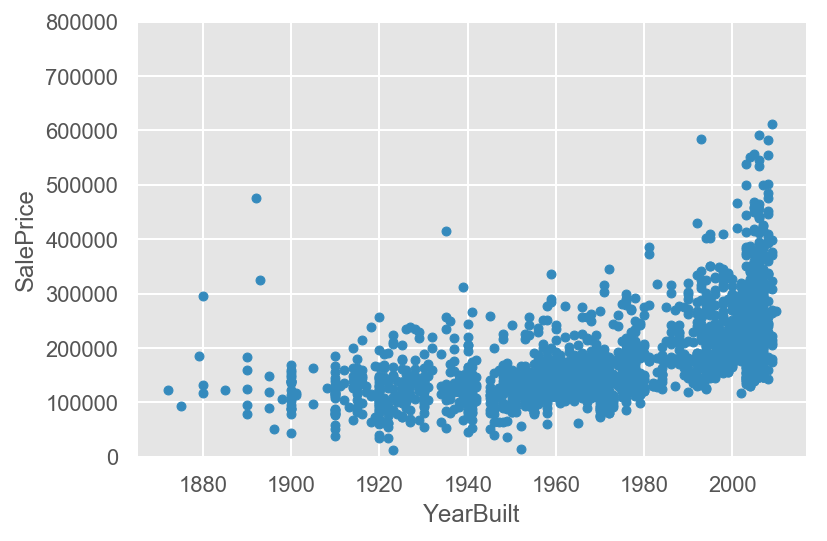

In [231]:
VAR='1stFlrSF'
data = pd.concat([df1_SCdummy['SalePrice'], df1_SCdummy[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

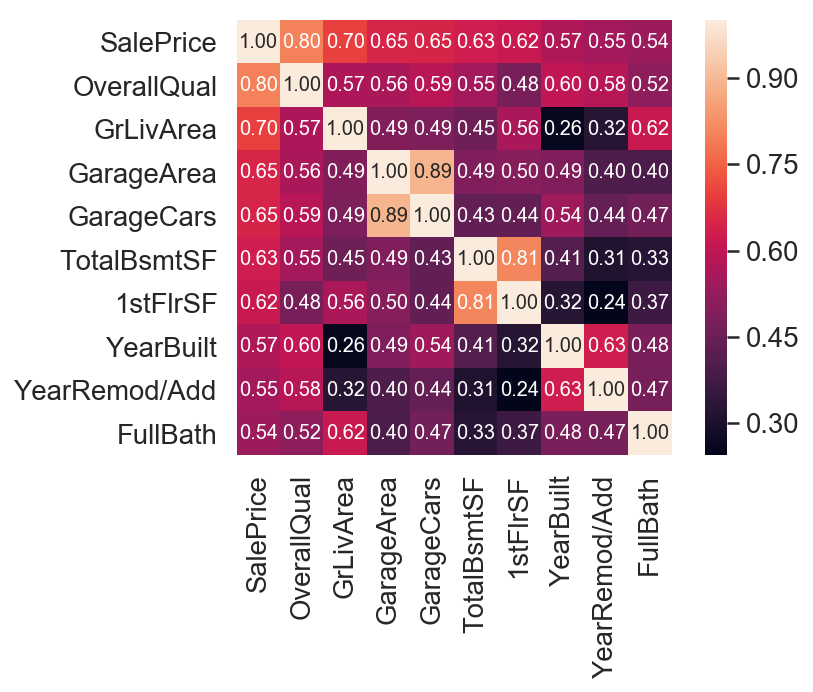

In [232]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = df1_SCdummy.corr()

cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df1_SCdummy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\Users\R.A\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


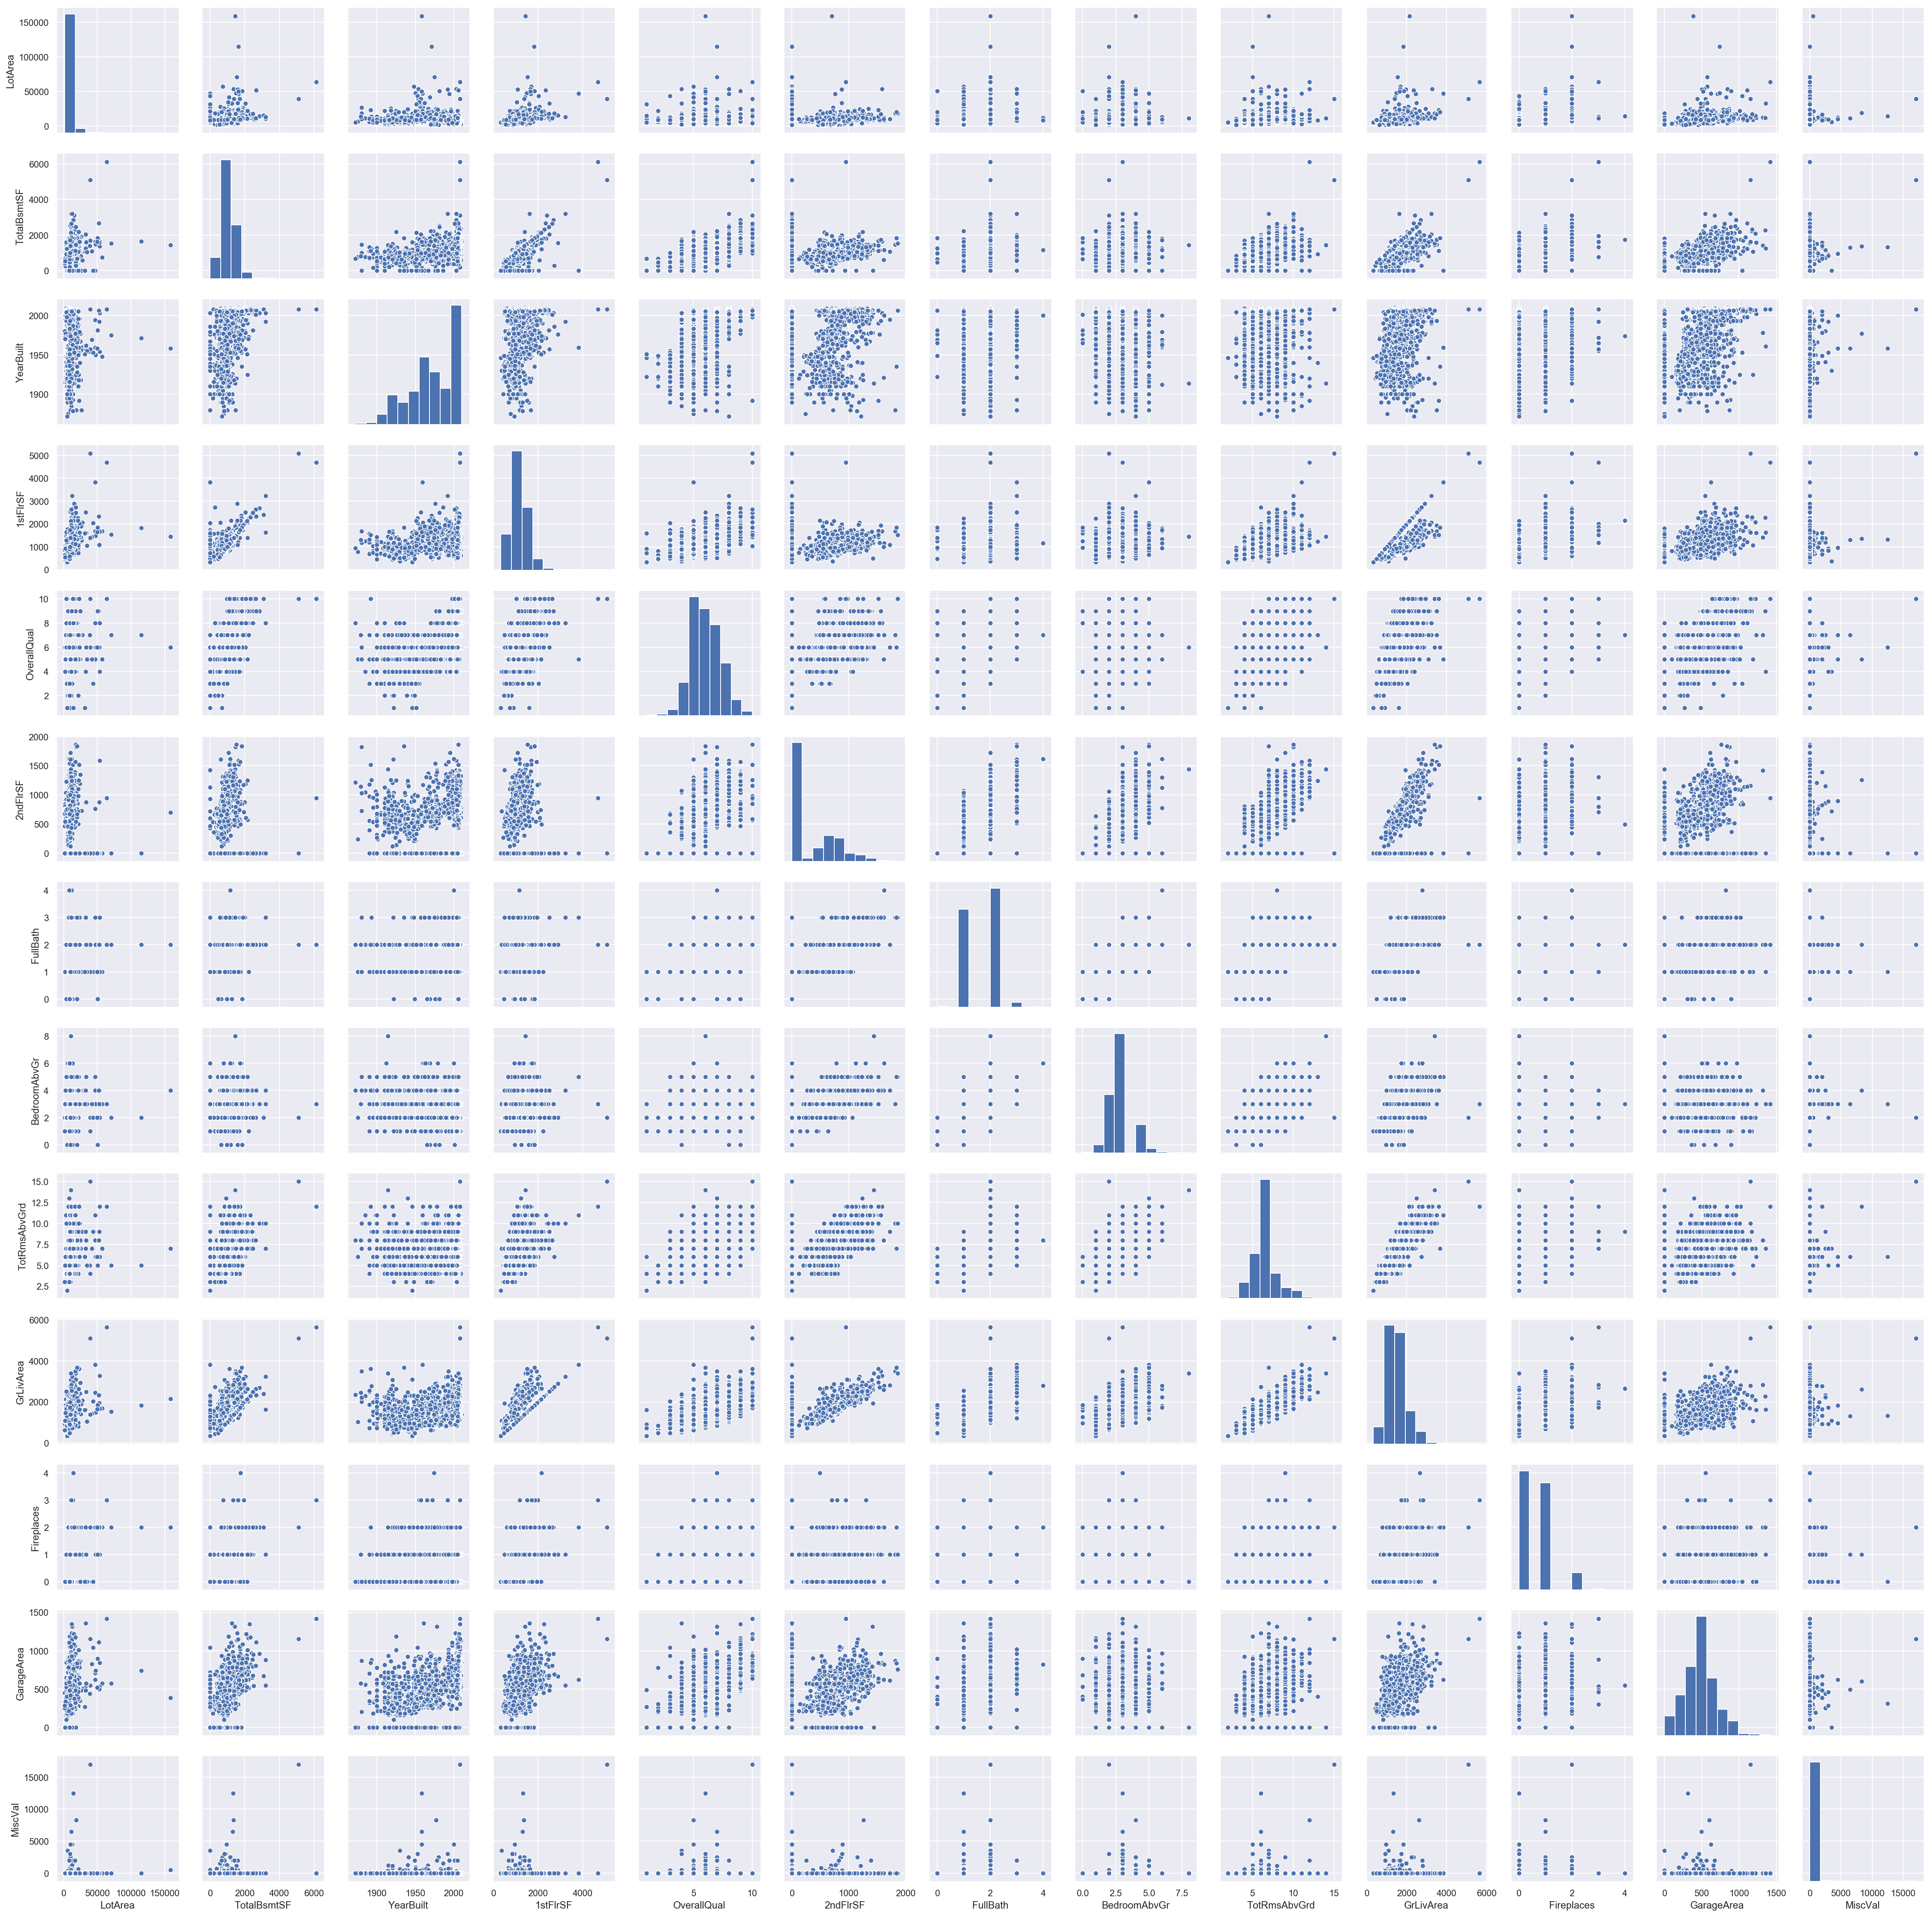

In [233]:
sns.set()
cols = ['LotArea','TotalBsmtSF','YearBuilt','1stFlrSF','OverallQual','2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd','GrLivArea','Fireplaces','GarageArea','MiscVal']
sns.pairplot(df1_SCdummy[cols], size = 2.5)
plt.show();

In [93]:
# 'TotalBsmtSF' and 'GrLiveArea

#### applying log transformation


In [ ]:
from scipy.stats import norm
#to normalize the sets
df1_SCdummy['SalePrice'] = np.log(df1_SCdummy['SalePrice']) #train
df1_SCdummy_test['SalePrice'] = np.log(df1_SCdummy_test['SalePrice']) #test

sns.distplot(df1_SCdummy['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1_SCdummy['SalePrice'], plot=plt)

In [ ]:
#normlize the train & test sets
df1_SCdummy[train_predictors] = np.log(df1_SCdummy[train_predictors])
df1_SCdummy_test[test_predictors] = np.log(df1_SCdummy_test[test_predictors])


In [239]:
 Xtrain_r.shape, ytrain_r.shape , Xtest_r.shape

((2051, 12), (2051,), (879, 12))

## Regression Models

#### Linear Model - Lasso

In [242]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


lasso=LassoCV()
# Fit the model on our data
lasso.fit(Xtrain_r, ytrain_r)
cv_l=cross_val_score(lasso,Xtrain_r,ytrain_r,cv=5,scoring='neg_mean_squared_error')
y_lasso=lasso.predict(Xtest_r)

print('Cross-validation RMSE:',np.sqrt(np.abs(cv_l)).mean())
print('training           r2:',lasso.score(Xtrain_r,ytrain_r))
print('test               r2:',lasso.score(Xtest_r,y_lasso))
print('training         rmse:',np.sqrt(mean_squared_error(ytrain_r,lasso.predict(Xtrain_r))))
print('testing          rmse:',np.sqrt(mean_squared_error(y_lasso,lasso.predict(Xtest_r))))

C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. Th

Cross-validation RMSE: 43207.06534799064
training           r2: 0.728959381752405
test               r2: 1.0
training         rmse: 41253.23511944745
testing          rmse: 0.0


#### GradientBoostingRegressor

In [243]:
from sklearn.ensemble import GradientBoostingRegressor


m1=GradientBoostingRegressor(max_depth=2,n_estimators=2000,min_samples_split=0.22,min_impurity_decrease=4,learning_rate=0.05)
cv=cross_val_score(m1,Xtrain_r,ytrain_r,cv=5,scoring='neg_mean_squared_error')
m1.fit(Xtrain_r,ytrain_r)
ghr=m1.predict(Xtest_r)

print('Cross-validation RMSE:',np.sqrt(np.abs(cv)).mean())
print('training           r2:',m1.score(Xtrain_r,ytrain_r))
print('test               r2:',m1.score(Xtest_r,ghr))
print('training         rmse:',np.sqrt(mean_squared_error(ytrain_r,m1.predict(Xtrain_r))))
print('testing          rmse:',np.sqrt(mean_squared_error(ghr,m1.predict(Xtest_r))))ra

Cross-validation RMSE: 29821.052363579336
training           r2: 0.9448465524196279
test               r2: 1.0
training         rmse: 18609.176492536502
testing          rmse: 0.0


#### Decision Tree Regressor:

In [246]:
from sklearn.tree import DecisionTreeRegressor

# Define model. Specify a number for random_state to ensure same results each run
dt = DecisionTreeRegressor(random_state=1)
dt.fit(Xtrain_r, ytrain_r)
y_predict_dtr=dt.predict(Xtest_r)

print('Cross-validation RMSE:',np.sqrt(np.abs(cv)).mean())
print('training           r2:',dt.score(Xtrain_r,ytrain_r))
print('test               r2:',dt.score(Xtest_r,y_predict_dtr))
print('training         rmse:',np.sqrt(mean_squared_error(ytrain_r,dt.predict(Xtrain_r))))
print('testing          rmse:',np.sqrt(mean_squared_error(y_predict_dtr,dt.predict(Xtest_r))))

Cross-validation RMSE: 29821.052363579336
training           r2: 0.9999745994253287
test               r2: 1.0
training         rmse: 399.3581883721182
testing          rmse: 0.0


####  ElasticNet

In [249]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression


Xtrain_r, ytrain_r = make_regression(n_features=12, random_state=0)
regr = ElasticNet(random_state=0)
regr.fit(Xtrain_r, ytrain_r)
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
# print(regr.coef_) 
# print(regr.intercept_) 
y_elastic=regr.predict(Xtest_r)


print('Cross-validation RMSE:',np.sqrt(np.abs(cv)).mean())
print('training           r2:',dt.score(Xtrain_r,ytrain_r))
print('test               r2:',dt.score(Xtest_r,y_elastic))
print('training         rmse:',np.sqrt(mean_squared_error(ytrain_r,dt.predict(Xtrain_r))))
print('testing          rmse:',np.sqrt(mean_squared_error(y_elastic,dt.predict(Xtest_r))))

Cross-validation RMSE: 29821.052363579336
training           r2: -386383.4427614511
test               r2: -0.5167397277390691
training         rmse: 69199.94991848308
testing          rmse: 413113.74998524744


#### Bagging Regressor

In [250]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.linear_model import Lasso


In [251]:
bag_r=BaggingRegressor(GradientBoostingRegressor())
cv=cross_val_score(bag_r,Xtrain_r,ytrain_r,cv=5,scoring='r2')

In [253]:
a= RandomForestRegressor(max_features=12)
a.fit(Xtrain_r,ytrain_r)
y_predict_baggingregressor=a.predict(Xtest_r)

print('Cross-validation RMSE:',np.sqrt(np.abs(cv)).mean())
print('training           r2:',dt.score(Xtrain_r,ytrain_r))
print('test               r2:',dt.score(Xtest_r,y_predict_baggingregressor))
print('training         rmse:',np.sqrt(mean_squared_error(ytrain_r,dt.predict(Xtrain_r))))
print('testing          rmse:',np.sqrt(mean_squared_error(y_predict_baggingregressor,dt.predict(Xtest_r))))

Cross-validation RMSE: 0.7604930565829999
training           r2: -386383.4427614511
test               r2: -17058104.847487435
training         rmse: 69199.94991848308
testing          rmse: 197294.2044457566


C:\Users\R.A\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## SalePrice Kaggle Submission

In [255]:

S=df1_SCdummy_test[['Id']]
df_id=pd.DataFrame(S, columns=['Id'])
sale_cond=pd.DataFrame(ghr, columns=['SalePrice'])  # Only change y_predict 
sale_result=df_id.join(sale_cond)



sale_result.to_csv('ghr_result.csv', index=False)
sale_result.head()

Id      SalePrice
704   2  355983.873537
706   4  153785.386269
120   6  220964.520539
312   7  209865.132970
401  17   99533.936830

---

## Resources:


In [ ]:
#Resources:
# https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512
# https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-42fd0a43b009
#https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights